In [1]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [2]:
# !pip install Orange3

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder, normalize, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, KFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_roc_curve, roc_auc_score, classification_report, roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC, LinearSVC
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.semi_supervised import LabelSpreading, LabelPropagation
from imblearn.over_sampling import SMOTE
from sklearn.semi_supervised import SelfTrainingClassifier
import warnings
import Orange
warnings.filterwarnings("ignore")
import random
from sklearn.impute import SimpleImputer
from matplotlib import pyplot
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.models import Model
from keras.models import load_model
from xgboost import XGBRFClassifier
from scipy.stats import friedmanchisquare
from sklearn.utils import shuffle
from sklearn.metrics import PrecisionRecallDisplay

## 1. Self Learning
a) Online Shoppers Intention Data

<BarContainer object of 2 artists>

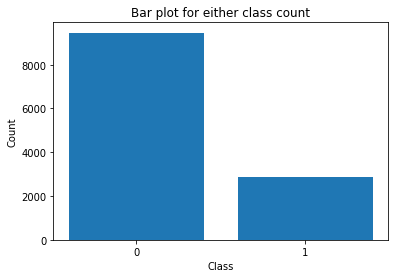

In [27]:
shoppper_df = pd.read_csv('online_shoppers_intention.csv')
shooper_label_dict = dict(shoppper_df['Weekend'].value_counts())
plt.title('Bar plot for either class count')
plt.xlabel('Class')
plt.ylabel('Count')
plt.bar(['0', '1'], shooper_label_dict.values())

In [ ]:
shoppper_df[:20]

Administrative  Administrative_Duration  ...  Weekend  Revenue
0                0                      0.0  ...    False    False
1                0                      0.0  ...    False    False
2                0                      0.0  ...    False    False
3                0                      0.0  ...    False    False
4                0                      0.0  ...     True    False
5                0                      0.0  ...    False    False
6                0                      0.0  ...    False    False
7                1                      0.0  ...     True    False
8                0                      0.0  ...    False    False
9                0                      0.0  ...    False    False
10               0                      0.0  ...    False    False
11               0                      0.0  ...    False    False
12               0                      0.0  ...    False    False
13               0                      0.0  ...    False    False
14               0                      0.0  ...    False    False
15               2                     53.0  ...    False    False
16               0                      0.0  ...    False    False
17               0                      0.0  ...     True    False
18               0                      0.0  ...    False    False
19               0                      0.0  ...    False    False

[20 rows x 18 columns]

The shoppers dataset is imbalanced as seen from the above bar plot. 

#### Checking if there are any Nan values

In [ ]:
shoppper_df.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [ ]:
shoppper_df.VisitorType.value_counts()

Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: VisitorType, dtype: int64

#### Preprocessing of Shoppers Dataset
The dataset contains some categorical values and also a feature 'Month' that needs cyclic transformation.
__Handling of Categorical Values__ is done using OneHotEncoder(), __Normalization__ is done using MinMaxScaler().<br>
The fetaure 'Month' requires cyclic transformation, meaning the cycle of occurence of the values should be preserved and used for training, hence, this is done by using a sin curve

In [9]:
scaler = StandardScaler()
encoder_hot = OneHotEncoder()
encoder_ord_m = OrdinalEncoder(categories=[['June', 'Jul', 'Aug', 'Sep', 'Oct', 'Dec', 'Mar', 'Nov', 'May', 'Feb']])
encoder_ord_v = OrdinalEncoder(categories=['Other', 'New_Visitor', 'Returning_Visitor'])
encoder_ord = OrdinalEncoder()
# shoppper_df['Revenue'] = encoder_hot.fit_transform(shoppper_df.Revenue.values.reshape(-1, 1)).toarray()
# shoppper_df['Weekend'] = encoder_hot.fit_transform(shoppper_df.Weekend.values.reshape(-1, 1)).toarray()
# shoppper_df['VisitorType'] = encoder_hot.fit_transform(shoppper_df.VisitorType.values.reshape(-1, 1)).toarray()
# shoppper_df['Month'] = encoder_hot.fit_transform(shoppper_df.Month.values.reshape(-1,1)).toarray()

shoppper_df['Month'] = encoder_ord.fit_transform(shoppper_df[['Month']])
shoppper_df['Revenue'] = encoder_ord.fit_transform(shoppper_df[['Revenue']])
shoppper_df['Weekend'] = encoder_ord.fit_transform(shoppper_df[['Weekend']])
shoppper_df['VisitorType'] = encoder_ord.fit_transform(shoppper_df[['VisitorType']])

# for i in range(len(shoppper_df.columns)-1):
#   if shoppper_df.columns[i] != 'Month':
#     shoppper_df[shoppper_df.columns[i]] = normalize(shoppper_df[[shoppper_df.columns[i]]])

# shoppper_df['Administrative_Duration'] = normalize(shoppper_df[['Administrative_Duration']])
# shoppper_df['ProductRelated'] = normalize(shoppper_df[['ProductRelated']])
# shoppper_df['ProductRelated_Duration'] = normalize(shoppper_df[['ProductRelated_Duration']])
# shoppper_df['PageValues'] = normalize(shoppper_df[['PageValues']])

shoppper_df['Administrative_Duration'] = scaler.fit_transform(shoppper_df[['Administrative_Duration']])
shoppper_df['ProductRelated'] = scaler.fit_transform(shoppper_df[['ProductRelated']])
shoppper_df['ProductRelated_Duration'] = scaler.fit_transform(shoppper_df[['ProductRelated_Duration']])
shoppper_df['PageValues'] = scaler.fit_transform(shoppper_df[['PageValues']])

shoppper_df['Revenue'] = encoder_ord.fit_transform(shoppper_df[['Revenue']])

month_sin = np.cos(shoppper_df.Month)
shoppper_df['month_sin'] = month_sin
shoppper_df = shoppper_df.drop(columns='Month')

### Feature Selection
I used dimensionality reduction using correlation between fetaures and the target class. A threshold was set to remove the fetaures having correlation below that. The threshold was selected after experimenting on a range of values in Assignment 2.

In [10]:
def Best_Features(dataframe, target_class, threshold):
  X = dataframe.drop(columns=[target_class])
  Y = dataframe[target_class]
  mod = ExtraTreesClassifier()
  mod.fit(X, Y)
  #plot graph of feature importances for better visualization
  feat_importances = pd.Series(mod.feature_importances_, index=X.columns)
  feat_importances.nlargest(18).plot(kind='barh')
  sns.set(rc={'figure.figsize':(5,5)})
  plt.show()
  ff = pd.DataFrame(feat_importances)
  cc = ff.sort_values(by=[0], ascending=False)
  select = cc.loc[cc[0] >= threshold]
  selectedFeat = list(select.T.columns)
  print("Selected Features: ",selectedFeat)
  best_feature = dataframe[selectedFeat]
  return X

In [ ]:
# cor1 = shoppper_df.corr()
# sns.heatmap(cor,annot=True,cmap='Blues')

In [11]:
corr1 = shoppper_df.corr()["Revenue"][1:]
abs_corr1 = abs(corr1)
abs_corr1 = abs_corr1.sort_values(ascending=False)
pd.set_option('display.max_rows', 200) # To display the rankings of all the features
print("Total Number of Rows :",len(abs_corr1))
print(abs_corr1)

Total Number of Rows : 17
Revenue                    1.000000
PageValues                 0.492569
ExitRates                  0.207071
ProductRelated             0.158538
ProductRelated_Duration    0.152373
BounceRates                0.150673
VisitorType                0.104726
Informational              0.095200
Administrative_Duration    0.093587
SpecialDay                 0.082305
Informational_Duration     0.070345
Weekend                    0.029295
Browser                    0.023984
OperatingSystems           0.014668
Region                     0.011595
month_sin                  0.011411
TrafficType                0.005113
Name: Revenue, dtype: float64


In [12]:
to_drop1 = abs(shoppper_df.corr()['Revenue'][abs(shoppper_df.corr()['Revenue'])<0.01]).index.tolist()
shoppper_df.drop(to_drop1,axis=1,inplace=True)
shoppper_df_X = shoppper_df.loc[:,shoppper_df.columns!='Revenue'].values
shoppper_df_y = shoppper_df.Revenue.values

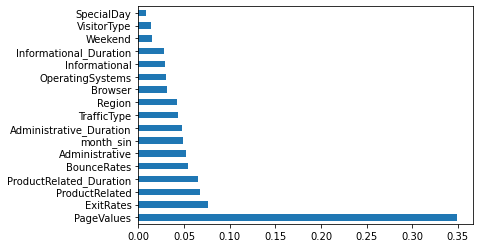

Selected Features:  ['PageValues', 'ExitRates', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'Administrative', 'month_sin', 'Administrative_Duration', 'TrafficType', 'Region']


In [ ]:
shopper_df_best = np.asanyarray(Best_Features(shoppper_df, 'Revenue', 0.04))
Y_shopper = np.asanyarray(shoppper_df['Revenue'])

#### Undersampling the majority class of shoppers dataset


In [13]:
X_train, X_test, y_train, y_test = train_test_split(shoppper_df_X, shoppper_df_y, test_size=0.3, random_state=42)
undersample = RandomUnderSampler(sampling_strategy='majority')
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

#### Oversampling of the minority Class of Shoppers Dataset

In [14]:
oversamp = SMOTE(random_state=12, sampling_strategy=1.0)                #F1Score - 0.663
    # oversamp = RandomOverSampler(sampling_strategy='minority')   F1Score - 0.660
X_train_over, y_train_over = oversamp.fit_resample(X_train, y_train)

#### b)Customer Personality Analysis

In [15]:
customer_df = pd.read_csv('marketing_campaign.csv', delimiter='\t')

In [16]:
customer_df.Education.unique()

array(['Graduation', 'PhD', 'Master', 'Basic', '2n Cycle'], dtype=object)

In [ ]:
# for i in range(len(customer_df['Teenhome'])):
#   if customer_df['Teenhome'][i] > 1:
#     customer_df['Teenhome'][i] = 1

# imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
# dataset['Income'] = imputer.fit_transform(dataset[['Income']]).ravel()
# customer_df_clean = customer_df.drop(columns=['ID', 'Dt_Customer', 'Education', 'Marital_Status', 'Teenhome' 
#                                             ])

# for i in range(len(customer_df_clean.columns)):
#   customer_df_clean[customer_df_clean.columns[i]] = normalize(customer_df_clean[[customer_df_clean.columns[i]]])

# for i in range(len(customer_df['Dt_Customer'])):
#   day, month, year = customer_df['Dt_Customer'][i].split('-')
#   customer_df['Dt_Customer'][i] = float(day) + float(month)*100


# # customer_df['Dt_Customer_year'] = normalize(customer_df[['Dt_Customer_year']])

# customer_df_clean['Dt_Customer_cyc'] = np.sin(customer_df['Dt_Customer'].astype(np.float64))

# enc = OneHotEncoder()
# onc = OrdinalEncoder(categories=[['Basic', 'Graduation', '2n Cycle', 'Master', 'PhD']])
# lab = LabelEncoder()
# customer_df['Teenhome'] = enc.fit_transform(customer_df.Teenhome.values.reshape(-1,1)).toarray()
# # customer_df['Teenhome'] = lab.fit_transform(customer_df[['Teenhome']])
# # customer_df['Education'] = enc.fit_transform(customer_df.Education.values.reshape(-1,1)).toarray()
# customer_df['Education'] = onc.fit_transform(customer_df[['Education']])
# customer_df['Marital_Status'] = enc.fit_transform(customer_df.Marital_Status.values.reshape(-1,1)).toarray()
# # customer_df['Marital_Status'] = enc.fit_transform(customer_df[['Marital_Status']])

# customer_df_clean['Education'] = customer_df['Education']
# customer_df_clean['Marital_Status'] = customer_df['Marital_Status']
# customer_df_clean['Teenhome'] = customer_df['Teenhome']


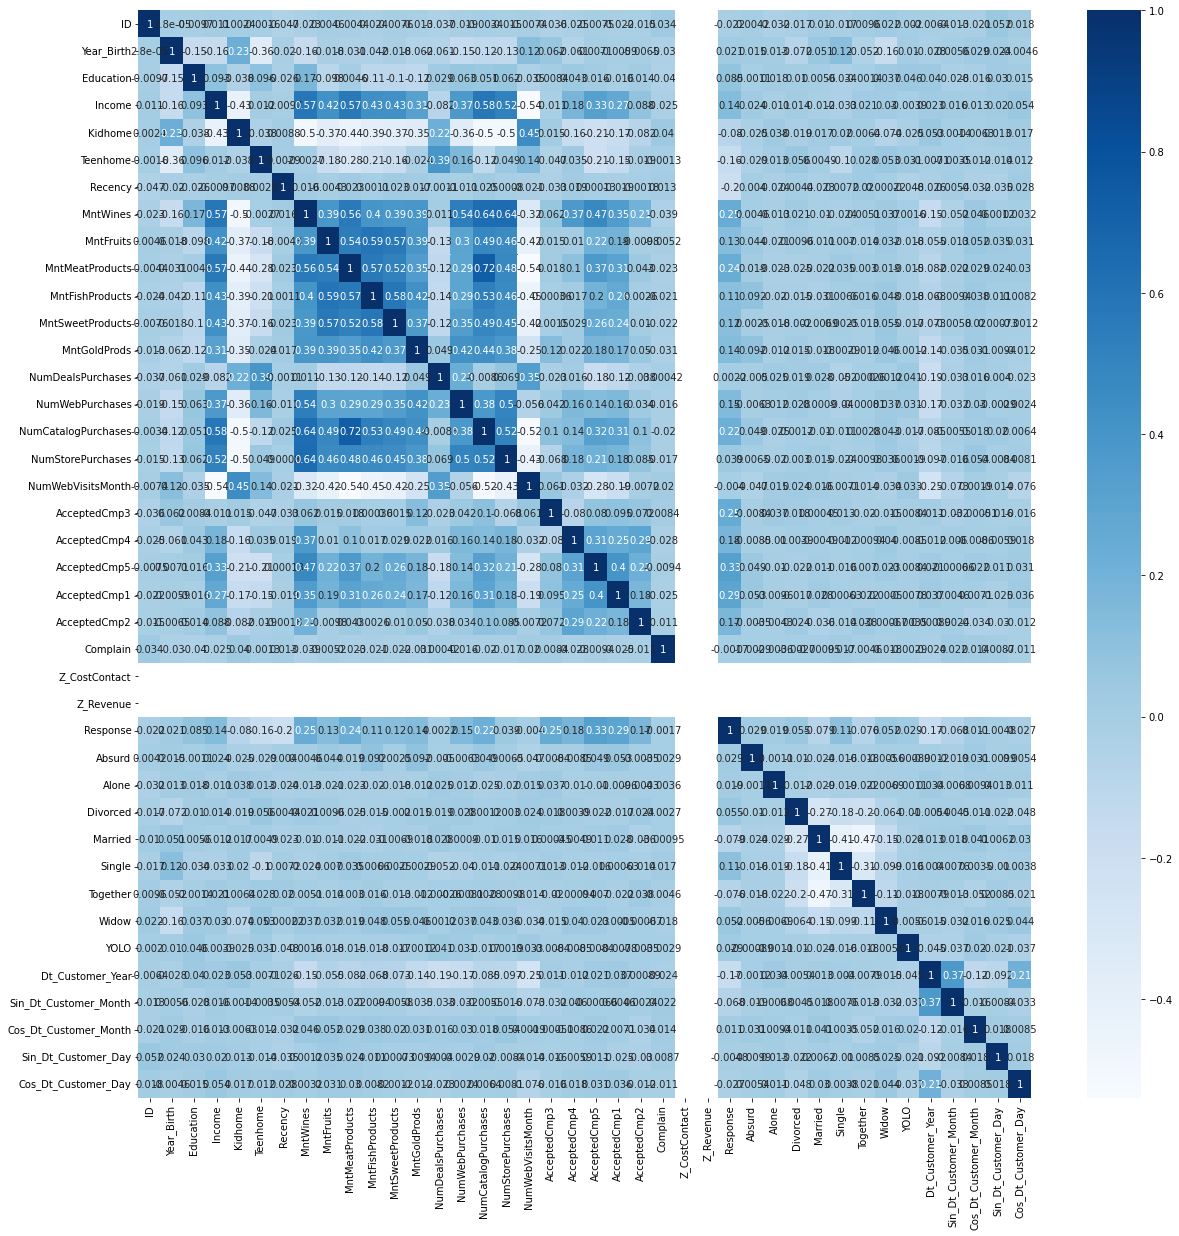

In [17]:
customer_df["Teenhome"] = (customer_df['Teenhome']>0)
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
customer_df['Income'] = imputer.fit_transform(customer_df[['Income']]).ravel()

onc = OrdinalEncoder(categories=[['Basic', 'Graduation', '2n Cycle', 'Master', 'PhD']])
customer_df['Education'] = onc.fit_transform(customer_df[['Education']])

enc = OneHotEncoder(sparse=False,handle_unknown='ignore')
encoded_feature = enc.fit_transform(customer_df[["Marital_Status"]])

#to merge the encoded features for train data
new_columns_train = pd.DataFrame(encoded_feature, columns=list(enc.categories_[0]))
customer_df.drop("Marital_Status",axis=1,inplace=True)
customer_df = pd.concat([customer_df,new_columns_train],axis=1)

customer_df['Dt_Customer'] = pd.to_datetime(customer_df['Dt_Customer'])
customer_df['Dt_Customer_Year'] = customer_df['Dt_Customer'].dt.year
customer_df['Dt_Customer_Month'] = customer_df['Dt_Customer'].dt.month
customer_df['Dt_Customer_Day'] = customer_df['Dt_Customer'].dt.day
customer_df.drop('Dt_Customer',inplace=True,axis=1)

# Taking Sin and Cos of Month
customer_df['Sin_Dt_Customer_Month'] = np.sin(2*np.pi*customer_df['Dt_Customer_Month'] / max(customer_df['Dt_Customer_Month']))
customer_df['Cos_Dt_Customer_Month'] = np.cos(2*np.pi*customer_df['Dt_Customer_Month'] / max(customer_df['Dt_Customer_Month']))

#Droping the Month Column
customer_df.drop(['Dt_Customer_Month'],inplace=True,axis=1)

customer_df['Sin_Dt_Customer_Day'] = np.sin(2*np.pi*customer_df['Dt_Customer_Day'] / max(customer_df['Dt_Customer_Day']))
customer_df['Cos_Dt_Customer_Day'] = np.cos(2*np.pi*customer_df['Dt_Customer_Day'] / max(customer_df['Dt_Customer_Day']))

#Droping the Day Column
customer_df.drop(['Dt_Customer_Day'],inplace=True,axis=1)

scaler = StandardScaler()

n_data = ['Year_Birth','Income','Recency','MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds',\
                'NumDealsPurchases','NumWebPurchases','NumCatalogPurchases','NumStorePurchases','NumWebVisitsMonth']

customer_df[n_data] = scaler.fit_transform(customer_df[n_data])

plt.figure(figsize=(20,20))
cor = customer_df.corr()
sns.heatmap(cor,annot=True,cmap='Blues')



In [18]:
customer_df.drop(["Z_CostContact","Z_Revenue","ID"],axis=1,inplace=True)
corr = customer_df.corr()["Teenhome"][1:]
abs_corr = abs(corr)
abs_corr = abs_corr.sort_values(ascending=False)
pd.set_option('display.max_rows', 200) # To display the rankings of all the features
print("Total Number of Rows :",len(abs_corr))
print(abs_corr[:10])

Total Number of Rows : 36
Teenhome             1.000000
NumDealsPurchases    0.394173
MntMeatProducts      0.275840
MntFishProducts      0.210868
AcceptedCmp5         0.205445
MntFruits            0.182316
MntSweetProducts     0.164644
Response             0.161356
NumWebPurchases      0.157645
AcceptedCmp1         0.147731
Name: Teenhome, dtype: float64


In [21]:
to_drop = abs(customer_df.corr()['Teenhome'][abs(customer_df.corr()['Teenhome'])<0.01]).index.tolist()
customer_df.drop(to_drop,axis=1,inplace=True)
customer_df_X = customer_df.loc[:,customer_df.columns!='Teenhome'].values
customer_df_y = customer_df.Teenhome.values

In [ ]:
# customer_df_clean.head()

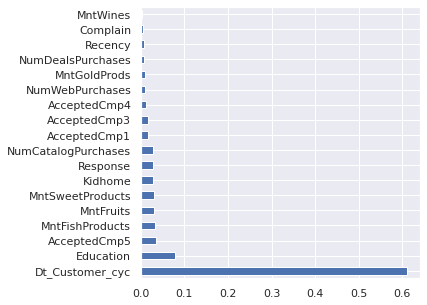

Selected Features:  ['Dt_Customer_cyc', 'Education', 'AcceptedCmp5', 'MntFishProducts', 'MntFruits', 'MntSweetProducts', 'Kidhome', 'Response', 'NumCatalogPurchases', 'AcceptedCmp1', 'AcceptedCmp3']


In [ ]:
# customer_df_best = np.asanyarray(Best_Features(customer_df_clean, 'Teenhome', 0.015))
# Y_customer = np.asanyarray(customer_df['Teenhome'])

In [ ]:
customer_df_clean.head()

Year_Birth  Income  Kidhome  ...  Education  Marital_Status  Teenhome
0         1.0     1.0      0.0  ...        1.0             0.0       1.0
1         1.0     1.0      1.0  ...        1.0             0.0       0.0
2         1.0     1.0      0.0  ...        1.0             0.0       1.0
3         1.0     1.0      1.0  ...        1.0             0.0       1.0
4         1.0     1.0      1.0  ...        4.0             0.0       1.0

[5 rows x 28 columns]

In [ ]:
# corr = customer_df_clean.corr()
# sns.set(rc={'figure.figsize':(20,20)})
# sns.heatmap(corr, annot=True, cmap='Blues')
# plt.show()
# cor_vals = abs(corr["Teenhome"])#Selecting highly correlated features
# cor_vals = pd.DataFrame(cor_vals)
# cor_vals_sort = cor_vals.sort_values(by=['Teenhome'], ascending=False)
# select_ = cor_vals_sort.loc[cor_vals_sort['Teenhome'] >= 0.01]
# selectedFeat_ = list(select_.T.columns)
# selectedFeat_.remove('Teenhome')
# train_x = np.asanyarray(customer_df_clean[[i for i in selectedFeat_]])
# Y_ = customer_df_clean['Teenhome']
# sns.set(rc={'figure.figsize':(5,5)})

In [ ]:
# selectedFeat_

In [22]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(customer_df_X, customer_df_y, test_size=0.2, random_state=42)

#### c) Heart Disease Dataset

In [23]:
data3 = pd.read_csv('heart.csv')
for i in range(len(data3.columns)):
  data3[data3.columns[i]] = normalize(data3[[data3.columns[i]]])

X3 = np.asanyarray(data3.drop(columns=['target']))
Y3 = np.asanyarray(data3['target'])

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, Y3, test_size=0.2, random_state=0)

# Task 1 Self Supervised Learning

In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test, pos=0):
  '''
  The evaluation Metrics are:
  Confusion Matrix
  Accuracy Score
  F1 Score
  Precision Score
  Recall Score
  ROC Plot
  '''
  eval_metirc = {}
  start = time.time()
  model = model.fit(X_train, y_train)
  preds = model.predict(X_test)
  end = time.time() - start
  print("Runtime for predicting: ", end)
  print("\nConfusion Matrix: \n", confusion_matrix(y_test, preds))
  print("\nAccuracy for the model: ", accuracy_score(y_test, preds))
  print("F1 Score for the model: ", f1_score(y_test, preds))
  print("Precision Score for the model: ", precision_score(y_test, preds))
  print("Recall Score for the model: ", recall_score(y_test, preds))

  plot_roc_curve(model, X_test, y_test, pos_label=pos)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.show()
  return f1_score(y_test, preds)


In [ ]:
clf = RandomForestClassifier()
clf = clf.fit(X_train, y_train)
new_x = []
new_y = []
drop = []
preds_proba = clf.predict_proba(X_test)
pred = clf.predict(X_test)
pr_0 = preds_proba[:,0]
pr_1 = preds_proba[:,1]
df = pd.DataFrame([])
df['pred'] = pred
df['0'] = pr_0
df['1'] = pr_1
bestprobs = pd.concat([df.loc[df['0'] > 0.9],
                        df.loc[df['1'] > 0.9]],
                      axis=0)

print(bestprobs)
print([bestprobs.index])

      pred     0     1
0      0.0  0.96  0.04
5      0.0  1.00  0.00
6      0.0  1.00  0.00
7      0.0  1.00  0.00
9      0.0  0.94  0.06
...    ...   ...   ...
3363   1.0  0.09  0.91
3371   1.0  0.02  0.98
3494   1.0  0.04  0.96
3638   1.0  0.07  0.93
3697   1.0  0.07  0.93

[2502 rows x 3 columns]
[Int64Index([   0,    5,    6,    7,    9,   10,   11,   12,   13,   14,
            ...
            2768, 2938, 3159, 3255, 3345, 3363, 3371, 3494, 3638, 3697],
           dtype='int64', length=2502)]


In [ ]:
def self_training(clf, X_train, y_train, X_test, y_test, percent_of_unlabel, pos=0):
  # x = X_train[:int(len(X_train)*(1-percent_of_unlabel))]
  # y = y_train[:int(len(X_train)*(1-percent_of_unlabel))]
  # randomlist = random.sample(range(len(X_train)), int(len(X_train)*(1-percent_of_unlabel)))
  # x = X_train[randomlist]

  # ssl_test = X_train[int(len(X_train)*(1-percent_of_unlabel)):]
  # ssl_test_y = y_train[int(len(X_train)*(1-percent_of_unlabel)):]
  x, ssl_test, y, ssl_test_y = train_test_split(X_train, y_train, test_size=percent_of_unlabel, random_state=425)
  clf = clf.fit(x, y)
  start = time.time()
  bestprobs = [0]
  while(len(bestprobs)!=0):
    new_x = []
    new_y = []
    drop = []
    try:
      preds_proba = clf.predict_proba(ssl_test)
      pred = clf.predict(ssl_test)
      pr_0 = preds_proba[:,0]
      pr_1 = preds_proba[:,1]
    except:
      break

    df = pd.DataFrame([])
    df['pred'] = pred
    df['0'] = pr_0
    df['1'] = pr_1
    bestprobs = pd.concat([df.loc[df['0'] > 0.9],
                           df.loc[df['1'] > 0.9]],
                          axis=0)
    # print(len(bestprobs))
    # print(len(x))
    # print(len(y))
    x = np.concatenate((x, ssl_test[bestprobs.index]))
    y = np.concatenate((y, bestprobs.pred))
    ssl_test = np.delete(ssl_test, list(bestprobs.index), 0)
    # print(len(x))
    # print(len(y))

    clf = clf.fit(x, y)
  
  end = time.time() - start

  predictions = clf.predict(X_test)
  # print(predictions)
  predictions_proba = clf.predict_proba(X_test)
  print("Runtime: {} seconds".format(end))
  print("Confusion Matrix: \n", confusion_matrix(y_test, predictions))
  print("Accuracy for the model: ", accuracy_score(y_test, predictions))
  print("F1 Score for the model: ", f1_score(y_test, predictions))
  print("Precision Score for the model: ", precision_score(y_test, predictions))
  print("Recall Score for the model: {}".format(recall_score(y_test, predictions)))

  fpr, tpr, thresholds = roc_curve(y_test, predictions_proba[:, 1], pos_label=pos)
  # plot_roc_curve(clf, X_test, y_test, pos_label=pos)
  plt.plot(fpr, tpr)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.show()
  return f1_score(y_test, predictions)

#### 0% Unlabelled Data for Shoppers Data

In [ ]:
models1 = {'Random Forest': RandomForestClassifier(max_depth=11, random_state=425), 
          'Decision Trees': DecisionTreeClassifier(max_depth=7, random_state=425), 
          'SVM': LinearSVC(loss='hinge',max_iter=100),
          'KNN': KNeighborsClassifier(n_neighbors=3),
          'MLP': MLPClassifier(solver='sgd', learning_rate='adaptive', hidden_layer_sizes=(50), alpha=0.1,activation='relu')}

# SVC(C=1000, max_iter=50, probability=True)

-------------Metrics for Random Forest------------

Runtime for predicting:  1.1666927337646484

Confusion Matrix: 
 [[3004  118]
 [ 277  300]]

Accuracy for the model:  0.8932143822654771
F1 Score for the model:  0.6030150753768844
Precision Score for the model:  0.7177033492822966
Recall Score for the model:  0.5199306759098787


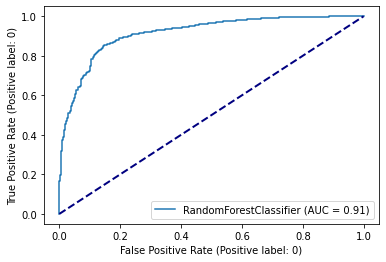



-------------Metrics for Decision Trees------------

Runtime for predicting:  0.036510467529296875

Confusion Matrix: 
 [[2935  187]
 [ 256  321]]

Accuracy for the model:  0.8802379021357124
F1 Score for the model:  0.5917050691244239
Precision Score for the model:  0.6318897637795275
Recall Score for the model:  0.5563258232235702


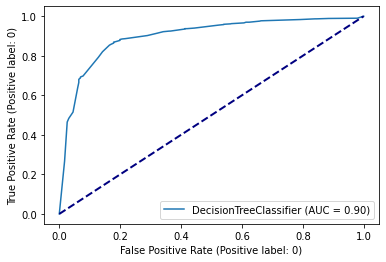



-------------Metrics for SVM------------

Runtime for predicting:  0.09177732467651367

Confusion Matrix: 
 [[3053   69]
 [ 357  220]]

Accuracy for the model:  0.8848337388483374
F1 Score for the model:  0.5080831408775981
Precision Score for the model:  0.7612456747404844
Recall Score for the model:  0.38128249566724437


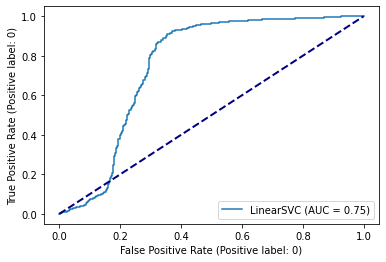



-------------Metrics for KNN------------

Runtime for predicting:  0.5852887630462646

Confusion Matrix: 
 [[2980  142]
 [ 378  199]]

Accuracy for the model:  0.8594214652608814
F1 Score for the model:  0.4335511982570806
Precision Score for the model:  0.5835777126099707
Recall Score for the model:  0.34488734835355284


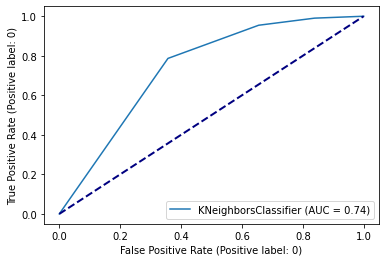



-------------Metrics for MLP------------

Runtime for predicting:  8.112044095993042

Confusion Matrix: 
 [[3061   61]
 [ 377  200]]

Accuracy for the model:  0.8815896188158961
F1 Score for the model:  0.47732696897374705
Precision Score for the model:  0.7662835249042146
Recall Score for the model:  0.3466204506065858


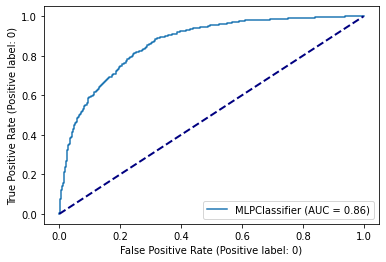

In [ ]:
f1_score_data1_1 = []
for name, clf in models1.items():
  print("-------------Metrics for {}------------\n".format(name))
  f1_score_0_data1.append(evaluate_model(clf, X_train, y_train, X_test, y_test))
  print("\n")

In [ ]:
f1_score_0_data1

[0.6030150753768844,
 0.5917050691244239,
 0.519774011299435,
 0.4335511982570806,
 0.49234393404004717]

#### 10% Unlabelled Data for Shoppers Data

-------------Metrics for Random Forest------------

[0. 0. 0. ... 0. 0. 0.]
Runtime: 5.7202441692352295 seconds
Confusion Matrix: 
 [[3012  110]
 [ 271  306]]
Accuracy for the model:  0.8969991889699919
F1 Score for the model:  0.6163141993957704
Precision Score for the model:  0.7355769230769231
Recall Score for the model: 0.5303292894280762


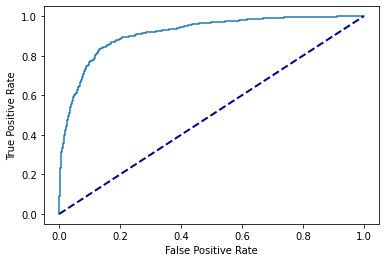



-------------Metrics for Decision Trees------------

[0. 0. 0. ... 0. 0. 0.]
Runtime: 0.1780533790588379 seconds
Confusion Matrix: 
 [[2981  141]
 [ 296  281]]
Accuracy for the model:  0.881859962151933
F1 Score for the model:  0.5625625625625625
Precision Score for the model:  0.6658767772511849
Recall Score for the model: 0.48700173310225303


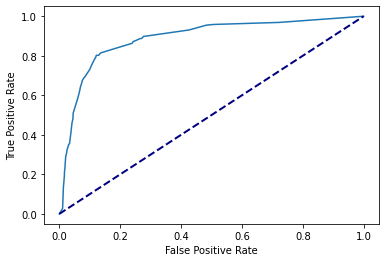



-------------Metrics for SVM------------

[1. 1. 1. ... 1. 1. 1.]
Runtime: 4.076197147369385 seconds
Confusion Matrix: 
 [[ 194 2928]
 [  66  511]]
Accuracy for the model:  0.19059205190592052
F1 Score for the model:  0.2544820717131474
Precision Score for the model:  0.14858970630997384
Recall Score for the model: 0.8856152512998267


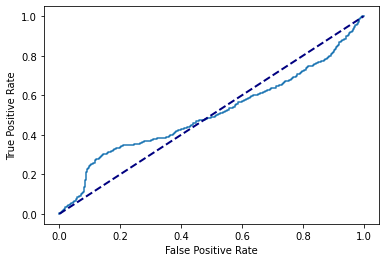



-------------Metrics for KNN------------

[0. 0. 0. ... 0. 0. 0.]
Runtime: 0.49809741973876953 seconds
Confusion Matrix: 
 [[2980  142]
 [ 383  194]]
Accuracy for the model:  0.8580697485806975
F1 Score for the model:  0.424972617743702
Precision Score for the model:  0.5773809523809523
Recall Score for the model: 0.3362218370883882


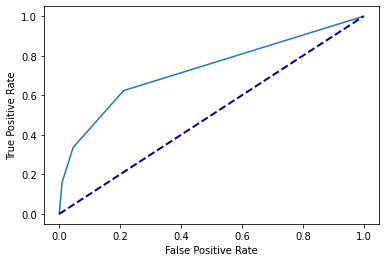



-------------Metrics for MLP------------

[0. 0. 0. ... 0. 0. 0.]
Runtime: 93.86997294425964 seconds
Confusion Matrix: 
 [[3059   63]
 [ 382  195]]
Accuracy for the model:  0.8796972154636388
F1 Score for the model:  0.46706586826347296
Precision Score for the model:  0.7558139534883721
Recall Score for the model: 0.3379549393414211


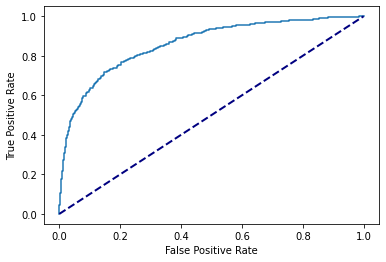

In [ ]:
# f1_score_10_data1 = []
for name, clf in models1.items():
  print("-------------Metrics for {}------------\n".format(name))
  if name == 'SVM':
    clf = SVC(C=1000, max_iter=300, probability=True)
  f1_score_data1_1.append(self_training(clf, X_train, y_train, X_test, y_test, 0.1, pos=1))
  print("\n")


#### 20% Unlabelled Data for Shoppers Data

-------------Metrics for Random Forest------------

[0. 0. 0. ... 0. 0. 0.]
Runtime: 11.690696477890015 seconds
Confusion Matrix: 
 [[3019  103]
 [ 273  304]]
Accuracy for the model:  0.8983509056501757
F1 Score for the model:  0.6178861788617886
Precision Score for the model:  0.7469287469287469
Recall Score for the model: 0.5268630849220104


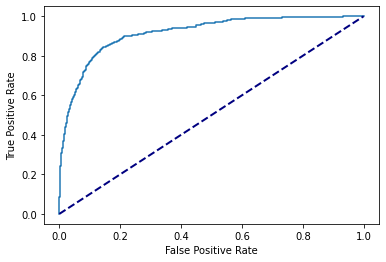



-------------Metrics for Decision Trees------------

[0. 0. 0. ... 0. 0. 0.]
Runtime: 0.2569301128387451 seconds
Confusion Matrix: 
 [[2936  186]
 [ 240  337]]
Accuracy for the model:  0.8848337388483374
F1 Score for the model:  0.6127272727272728
Precision Score for the model:  0.6443594646271511
Recall Score for the model: 0.584055459272097


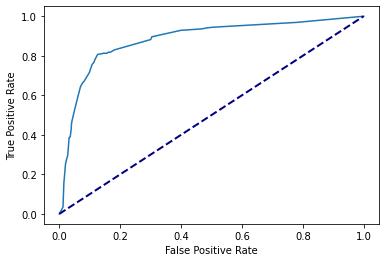



-------------Metrics for SVM------------

[1. 1. 1. ... 1. 1. 1.]
Runtime: 1.917696475982666 seconds
Confusion Matrix: 
 [[ 132 2990]
 [  54  523]]
Accuracy for the model:  0.17707488510408217
F1 Score for the model:  0.2557457212713936
Precision Score for the model:  0.1488756048961002
Recall Score for the model: 0.9064124783362218


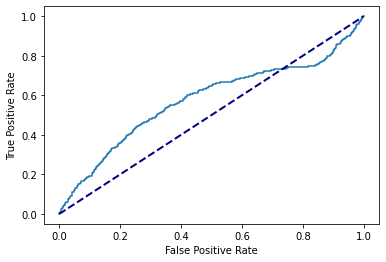



-------------Metrics for KNN------------

[0. 0. 0. ... 0. 0. 0.]
Runtime: 1.031073808670044 seconds
Confusion Matrix: 
 [[2979  143]
 [ 394  183]]
Accuracy for the model:  0.8548256285482563
F1 Score for the model:  0.4053156146179402
Precision Score for the model:  0.5613496932515337
Recall Score for the model: 0.317157712305026


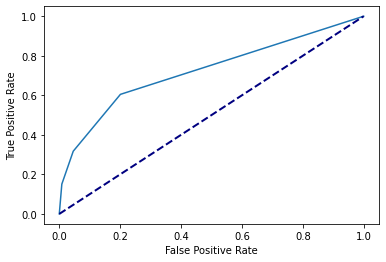



-------------Metrics for MLP------------

[0. 0. 0. ... 0. 0. 0.]
Runtime: 170.66483569145203 seconds
Confusion Matrix: 
 [[3058   64]
 [ 370  207]]
Accuracy for the model:  0.8826709921600433
F1 Score for the model:  0.48820754716981135
Precision Score for the model:  0.7638376383763837
Recall Score for the model: 0.3587521663778163


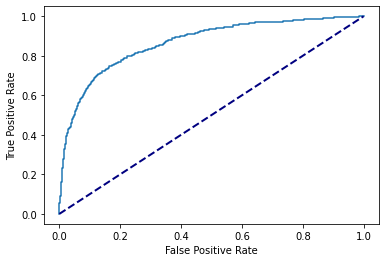

In [ ]:
# f1_score_20_data1 = []
for name, clf in models1.items():
  print("-------------Metrics for {}------------\n".format(name))
  if name == 'SVM':
    clf = SVC(C=1000, max_iter=300, probability=True)
  f1_score_data1_1.append(self_training(clf, X_train, y_train, X_test, y_test, 0.2, pos=1))
  print("\n")


In [ ]:
f1_score_20_data1

[0.6178861788617886,
 0.6127272727272728,
 0.2554470323065364,
 0.4053156146179402,
 0.49110320284697506]

#### 50% Unlabelled Data for Shoppers Data

-------------Metrics for Random Forest------------

[0. 0. 0. ... 0. 0. 0.]
Runtime: 27.477909088134766 seconds
Confusion Matrix: 
 [[3001  121]
 [ 275  302]]
Accuracy for the model:  0.8929440389294404
F1 Score for the model:  0.6040000000000001
Precision Score for the model:  0.7139479905437353
Recall Score for the model: 0.5233968804159446


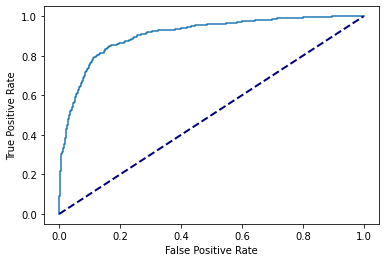



-------------Metrics for Decision Trees------------

[0. 0. 0. ... 0. 0. 1.]
Runtime: 0.28319311141967773 seconds
Confusion Matrix: 
 [[2985  137]
 [ 308  269]]
Accuracy for the model:  0.8796972154636388
F1 Score for the model:  0.5473041709053916
Precision Score for the model:  0.6625615763546798
Recall Score for the model: 0.4662045060658579


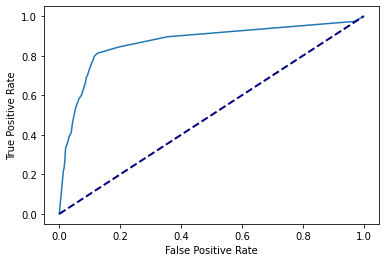



-------------Metrics for SVM------------

[0. 0. 0. ... 1. 0. 0.]
Runtime: 7.699586868286133 seconds
Confusion Matrix: 
 [[2780  342]
 [ 474  103]]
Accuracy for the model:  0.7793998377939984
F1 Score for the model:  0.20156555772994128
Precision Score for the model:  0.23146067415730337
Recall Score for the model: 0.17850953206239167


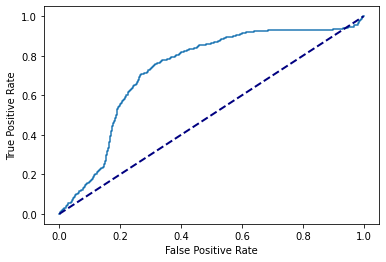



-------------Metrics for KNN------------

[0. 0. 0. ... 0. 0. 0.]
Runtime: 2.2077817916870117 seconds
Confusion Matrix: 
 [[3009  113]
 [ 405  172]]
Accuracy for the model:  0.8599621519329549
F1 Score for the model:  0.3990719257540603
Precision Score for the model:  0.6035087719298246
Recall Score for the model: 0.29809358752166376


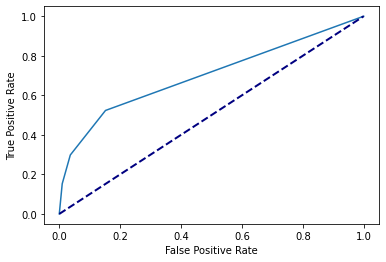



-------------Metrics for MLP------------

[0. 0. 0. ... 0. 0. 0.]
Runtime: 152.11080980300903 seconds
Confusion Matrix: 
 [[3056   66]
 [ 379  198]]
Accuracy for the model:  0.8796972154636388
F1 Score for the model:  0.4708680142687277
Precision Score for the model:  0.75
Recall Score for the model: 0.3431542461005199


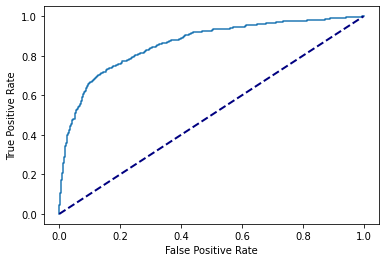

In [ ]:
# f1_score_50_data1 = []
for name, clf in models1.items():
  print("-------------Metrics for {}------------\n".format(name))
  if name == 'SVM':
    clf = SVC(C=1000, max_iter=500, probability=True)

  f1_score_data1_1.append(self_training(clf, X_train, y_train, X_test, y_test, 0.5, 1))
  print("\n")

In [ ]:
f1_score_50_data1

[0.6040000000000001,
 0.5473041709053916,
 0.25452716297786726,
 0.3990719257540603,
 0.47573964497041427]

#### 90% Unlabelled Data for Shoppers Data

-------------Metrics for Random Forest------------

[0. 0. 0. ... 0. 0. 0.]
Runtime: 27.17426824569702 seconds
Confusion Matrix: 
 [[3076   46]
 [ 384  193]]
Accuracy for the model:  0.8837523655041903
F1 Score for the model:  0.47303921568627455
Precision Score for the model:  0.8075313807531381
Recall Score for the model: 0.3344887348353553


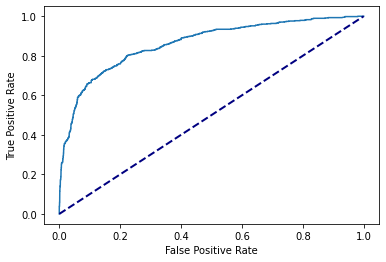



-------------Metrics for Decision Trees------------

[0. 0. 0. ... 1. 0. 1.]
Runtime: 0.18059301376342773 seconds
Confusion Matrix: 
 [[2979  143]
 [ 352  225]]
Accuracy for the model:  0.8661800486618005
F1 Score for the model:  0.4761904761904762
Precision Score for the model:  0.6114130434782609
Recall Score for the model: 0.389948006932409


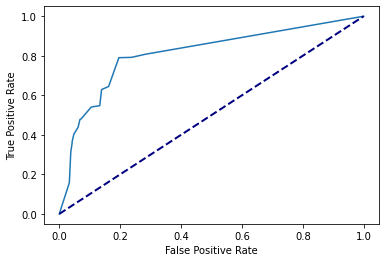



-------------Metrics for SVM------------

[0. 0. 0. ... 0. 0. 0.]
Runtime: 10.652989625930786 seconds
Confusion Matrix: 
 [[2868  254]
 [ 489   88]]
Accuracy for the model:  0.7991349013246823
F1 Score for the model:  0.191512513601741
Precision Score for the model:  0.2573099415204678
Recall Score for the model: 0.15251299826689774


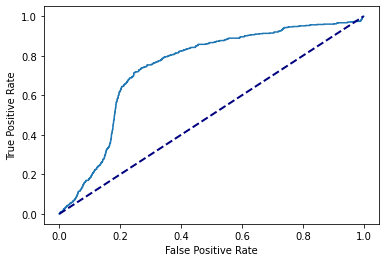



-------------Metrics for KNN------------

[0. 0. 0. ... 0. 0. 0.]
Runtime: 2.2737836837768555 seconds
Confusion Matrix: 
 [[3090   32]
 [ 487   90]]
Accuracy for the model:  0.8596918085969181
F1 Score for the model:  0.2575107296137339
Precision Score for the model:  0.7377049180327869
Recall Score for the model: 0.1559792027729636


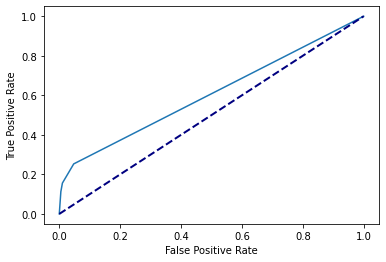



-------------Metrics for MLP------------

[0. 0. 0. ... 0. 0. 0.]
Runtime: 123.35178565979004 seconds
Confusion Matrix: 
 [[3113    9]
 [ 525   52]]
Accuracy for the model:  0.8556366585563666
F1 Score for the model:  0.16300940438871475
Precision Score for the model:  0.8524590163934426
Recall Score for the model: 0.09012131715771231


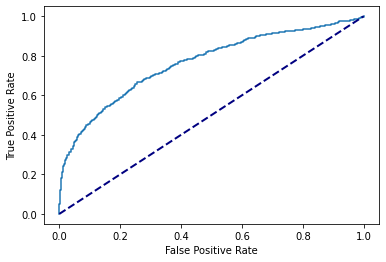

In [ ]:
# f1_score_90_data1 = []
for name, clf in models1.items():
  print("-------------Metrics for {}------------\n".format(name))
  if name == 'SVM':
    clf = SVC(C=1000, max_iter=500, probability=True)
  f1_score_data1_1.append(self_training(clf, X_train, y_train, X_test, y_test, 0.9, pos=1))
  print("\n")

In [ ]:
f1_score_90_data1

[0.47303921568627455,
 0.4761904761904762,
 0.23687089715536103,
 0.2575107296137339,
 0.13804173354735155]

#### 95% Unlabelled Data for Shoppers Data

-------------Metrics for Random Forest------------

[0. 0. 0. ... 0. 0. 0.]
Runtime: 14.736604928970337 seconds
Confusion Matrix: 
 [[3069   53]
 [ 374  203]]
Accuracy for the model:  0.8845633955123007
F1 Score for the model:  0.48739495798319327
Precision Score for the model:  0.79296875
Recall Score for the model: 0.35181975736568455


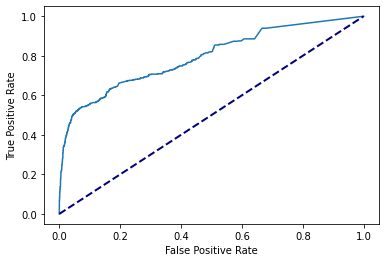



-------------Metrics for Decision Trees------------

[0. 0. 0. ... 0. 0. 0.]
Runtime: 0.1276261806488037 seconds
Confusion Matrix: 
 [[2941  181]
 [ 310  267]]
Accuracy for the model:  0.8672614220059476
F1 Score for the model:  0.5209756097560976
Precision Score for the model:  0.5959821428571429
Recall Score for the model: 0.462738301559792


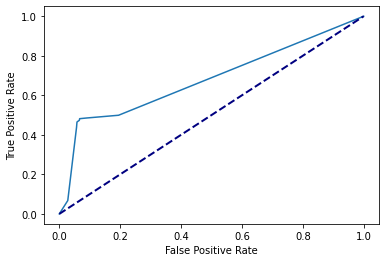



-------------Metrics for SVM------------

[0. 0. 0. ... 0. 0. 0.]
Runtime: 8.73131799697876 seconds
Confusion Matrix: 
 [[3100   22]
 [ 478   99]]
Accuracy for the model:  0.8648283319816167
F1 Score for the model:  0.2836676217765043
Precision Score for the model:  0.8181818181818182
Recall Score for the model: 0.17157712305025996


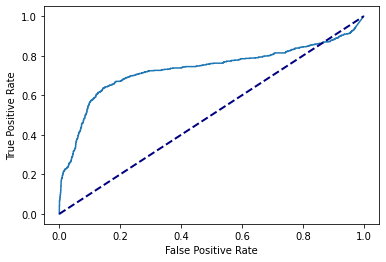



-------------Metrics for KNN------------

[0. 0. 0. ... 0. 0. 0.]
Runtime: 1.6448369026184082 seconds
Confusion Matrix: 
 [[3097   25]
 [ 484   93]]
Accuracy for the model:  0.8623952419572858
F1 Score for the model:  0.2676258992805755
Precision Score for the model:  0.788135593220339
Recall Score for the model: 0.1611785095320624


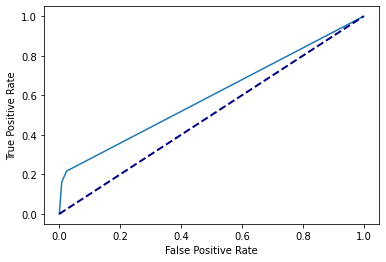



-------------Metrics for MLP------------

[0. 0. 0. ... 0. 0. 0.]
Runtime: 134.88671159744263 seconds
Confusion Matrix: 
 [[3113    9]
 [ 505   72]]
Accuracy for the model:  0.8610435252771019
F1 Score for the model:  0.21884498480243159
Precision Score for the model:  0.8888888888888888
Recall Score for the model: 0.12478336221837089


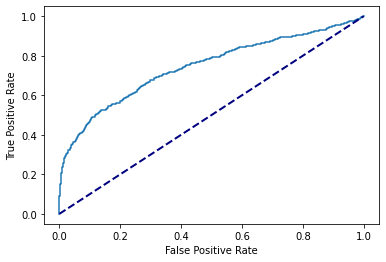

In [ ]:
# f1_score_95_data1 = []
for name, clf in models1.items():
  print("-------------Metrics for {}------------\n".format(name))
  if name == 'SVM':
    clf = SVC(C=1000, max_iter=500, probability=True)
  f1_score_data1_1.append(self_training(clf, X_train, y_train, X_test, y_test, 0.95, pos=1))
  print("\n")

In [ ]:
f1_score_95_data1

[0.48739495798319327,
 0.5209756097560976,
 0.5671641791044776,
 0.2676258992805755,
 0.19165378670788252]

In [ ]:
algo_1 = []
algo_1.append(max(f1_score_data1_1))

In [ ]:
models_under = {'Random Forest': RandomForestClassifier(max_depth=3, random_state=42), 
          'Decision Trees':DecisionTreeClassifier(max_depth=3, random_state=42), 
          'SVM': SVC(C=10,kernel='rbf', class_weight='balanced', probability=True),
          'KNN': KNeighborsClassifier(n_neighbors=5),
          'MLP': MLPClassifier(solver='sgd', learning_rate='adaptive', hidden_layer_sizes=(20,), alpha=0.1,activation='tanh')}

#### 0% Unlabelled Data for UnderSampled Shoppers Data

-------------Metrics for Random Forest------------

Runtime for predicting:  0.30975770950317383

Confusion Matrix: 
 [[2755  367]
 [ 115  462]]

Accuracy for the model:  0.8696945120302785
F1 Score for the model:  0.6571834992887625
Precision Score for the model:  0.5572979493365501
Recall Score for the model:  0.8006932409012132


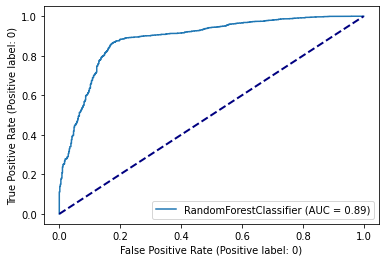



-------------Metrics for Decision Trees------------

Runtime for predicting:  0.011307954788208008

Confusion Matrix: 
 [[2765  357]
 [ 122  455]]

Accuracy for the model:  0.8705055420383887
F1 Score for the model:  0.6551475881929446
Precision Score for the model:  0.5603448275862069
Recall Score for the model:  0.7885615251299827


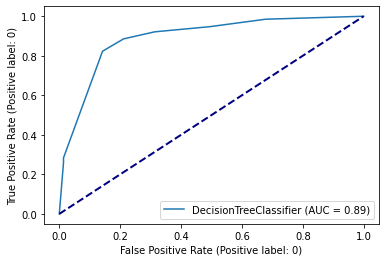



-------------Metrics for SVM------------

Runtime for predicting:  2.5352656841278076

Confusion Matrix: 
 [[2558  564]
 [ 203  374]]

Accuracy for the model:  0.7926466612598
F1 Score for the model:  0.4937293729372937
Precision Score for the model:  0.39872068230277186
Recall Score for the model:  0.6481802426343154


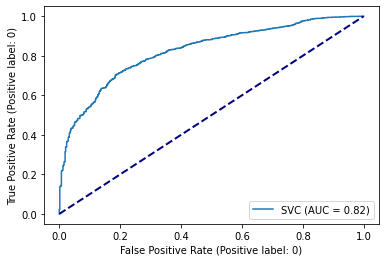



-------------Metrics for KNN------------

Runtime for predicting:  0.3231980800628662

Confusion Matrix: 
 [[2325  797]
 [ 162  415]]

Accuracy for the model:  0.7407407407407407
F1 Score for the model:  0.4639463387367245
Precision Score for the model:  0.3424092409240924
Recall Score for the model:  0.7192374350086655


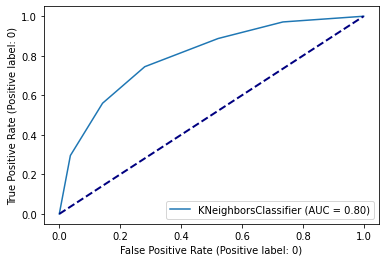



-------------Metrics for MLP------------

Runtime for predicting:  1.5759522914886475

Confusion Matrix: 
 [[2524  598]
 [ 134  443]]

Accuracy for the model:  0.8021086780210868
F1 Score for the model:  0.5475896168108776
Precision Score for the model:  0.425552353506244
Recall Score for the model:  0.7677642980935875


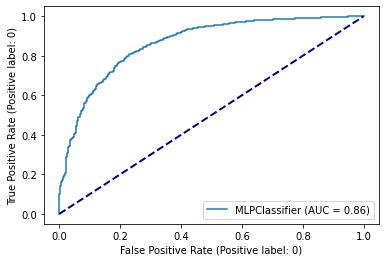

In [ ]:
f1_score_data2_1 = []
for name, clf in models_under.items():
  print("-------------Metrics for {}------------\n".format(name))
  f1_score_data2_1.append(evaluate_model(clf, X_train_under, y_train_under, X_test, y_test))
  print("\n")

In [ ]:
f1_score_0_data2

[0.6604717655468192,
 0.663287472845764,
 0.4831730769230769,
 0.4280666330136294,
 0.5802543912780133]

#### 10% Unlabelled Data for UnderSampled Shoppers Data

-------------Metrics for Random Forest------------

[0. 0. 0. ... 1. 0. 1.]
Runtime: 0.8658912181854248 seconds
Confusion Matrix: 
 [[2741  381]
 [ 111  466]]
Accuracy for the model:  0.8669910786699108
F1 Score for the model:  0.6544943820224719
Precision Score for the model:  0.5501770956316411
Recall Score for the model: 0.8076256499133448


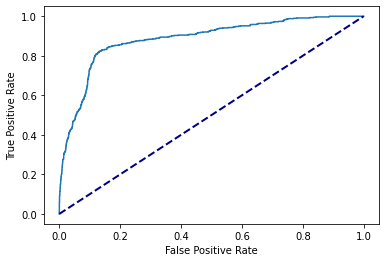



-------------Metrics for Decision Trees------------

[0. 0. 0. ... 1. 0. 1.]
Runtime: 0.020786762237548828 seconds
Confusion Matrix: 
 [[2755  367]
 [ 122  455]]
Accuracy for the model:  0.8678021086780211
F1 Score for the model:  0.6504646175839885
Precision Score for the model:  0.5535279805352799
Recall Score for the model: 0.7885615251299827


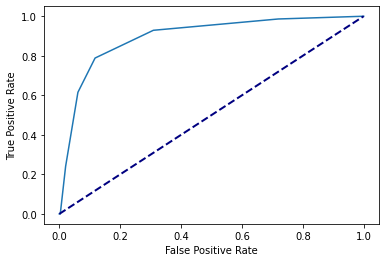



-------------Metrics for SVM------------

[0. 0. 0. ... 1. 0. 0.]
Runtime: 5.221140623092651 seconds
Confusion Matrix: 
 [[2580  542]
 [ 207  370]]
Accuracy for the model:  0.7975128413084618
F1 Score for the model:  0.49697783747481533
Precision Score for the model:  0.4057017543859649
Recall Score for the model: 0.6412478336221837


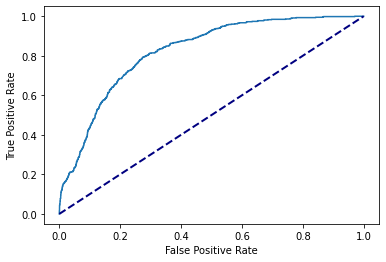



-------------Metrics for KNN------------

[0. 0. 0. ... 1. 0. 1.]
Runtime: 0.12698793411254883 seconds
Confusion Matrix: 
 [[2334  788]
 [ 162  415]]
Accuracy for the model:  0.7431738307650716
F1 Score for the model:  0.46629213483146076
Precision Score for the model:  0.34497090606816294
Recall Score for the model: 0.7192374350086655


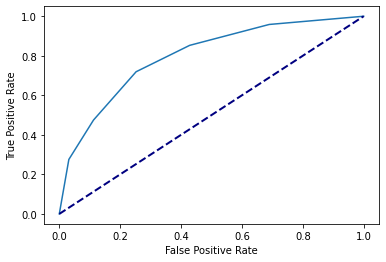



-------------Metrics for MLP------------

[0. 0. 0. ... 1. 0. 1.]
Runtime: 4.024304151535034 seconds
Confusion Matrix: 
 [[2398  724]
 [ 118  459]]
Accuracy for the model:  0.7723709110570425
F1 Score for the model:  0.5215909090909091
Precision Score for the model:  0.3879966187658495
Recall Score for the model: 0.7954939341421143


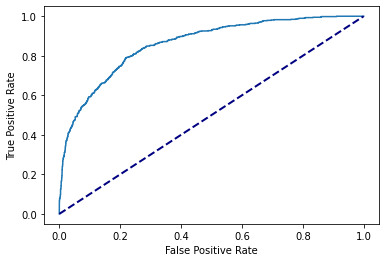

In [ ]:
# f1_score_20_data2 = []
for name, clf in models_under.items():
  print("-------------Metrics for {}------------\n".format(name))
  f1_score_data2_1.append(self_training(clf, X_train_under, y_train_under, X_test, y_test, 0.1, pos=1))
  # self_training(clf, X_train_under, y_train_under, X_test, y_test, 0.1, pos=0)

  print("\n")

#### 20% Unlabelled Data for UnderSampled Shoppers Data

-------------Metrics for Random Forest------------

[0. 0. 0. ... 1. 0. 1.]
Runtime: 1.3619625568389893 seconds
Confusion Matrix: 
 [[2751  371]
 [ 115  462]]
Accuracy for the model:  0.8686131386861314
F1 Score for the model:  0.6553191489361702
Precision Score for the model:  0.5546218487394958
Recall Score for the model: 0.8006932409012132


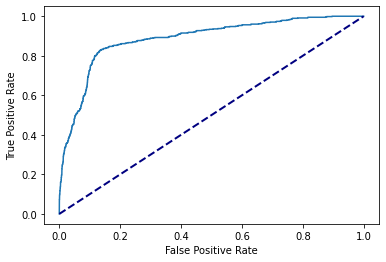



-------------Metrics for Decision Trees------------

[0. 0. 0. ... 0. 0. 1.]
Runtime: 0.022408246994018555 seconds
Confusion Matrix: 
 [[2787  335]
 [ 134  443]]
Accuracy for the model:  0.8732089753987564
F1 Score for the model:  0.6538745387453874
Precision Score for the model:  0.5694087403598972
Recall Score for the model: 0.7677642980935875


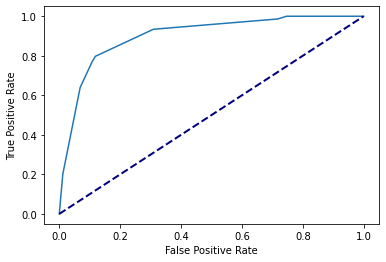



-------------Metrics for SVM------------

[0. 0. 0. ... 1. 0. 0.]
Runtime: 4.50029444694519 seconds
Confusion Matrix: 
 [[2590  532]
 [ 219  358]]
Accuracy for the model:  0.7969721546363883
F1 Score for the model:  0.4880708929788685
Precision Score for the model:  0.40224719101123596
Recall Score for the model: 0.6204506065857885


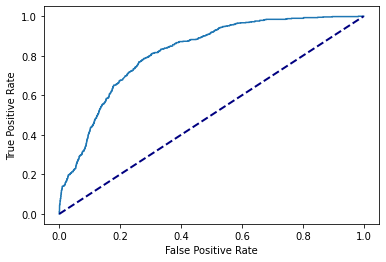



-------------Metrics for KNN------------

[0. 0. 0. ... 1. 0. 0.]
Runtime: 0.2969827651977539 seconds
Confusion Matrix: 
 [[2318  804]
 [ 170  407]]
Accuracy for the model:  0.7366855907001892
F1 Score for the model:  0.45525727069351235
Precision Score for the model:  0.3360858794384806
Recall Score for the model: 0.7053726169844021


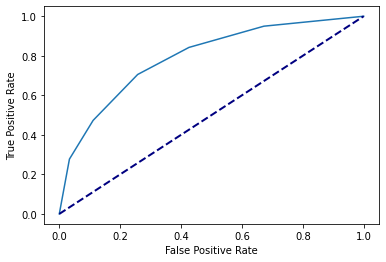



-------------Metrics for MLP------------

[0. 0. 0. ... 0. 0. 1.]
Runtime: 10.80597996711731 seconds
Confusion Matrix: 
 [[2332  790]
 [ 115  462]]
Accuracy for the model:  0.7553392808867262
F1 Score for the model:  0.505194095133953
Precision Score for the model:  0.36900958466453676
Recall Score for the model: 0.8006932409012132


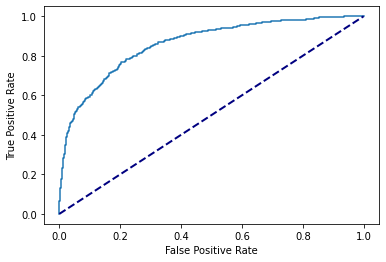

In [ ]:
# f1_score_20_data2 = []
for name, clf in models_under.items():
  print("-------------Metrics for {}------------\n".format(name))
  f1_score_data2_1.append(self_training(clf, X_train_under, y_train_under, X_test, y_test, 0.2, pos=1))
  print("\n")

In [ ]:
f1_score_20_data2

[0.662799129804206,
 0.6604717655468192,
 0.4251870324189526,
 0.4113842173350582,
 0.5729657027572294]

#### 50% Unlabelled Data for UnderSampled Shoppers Data

-------------Metrics for Random Forest------------

[0. 0. 0. ... 1. 0. 1.]
Runtime: 1.7841792106628418 seconds
Confusion Matrix: 
 [[2753  369]
 [ 118  459]]
Accuracy for the model:  0.8683427953500946
F1 Score for the model:  0.6533807829181495
Precision Score for the model:  0.5543478260869565
Recall Score for the model: 0.7954939341421143


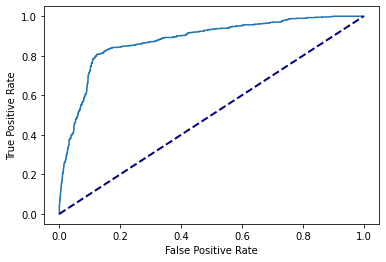



-------------Metrics for Decision Trees------------

[0. 0. 0. ... 1. 0. 1.]
Runtime: 0.018524646759033203 seconds
Confusion Matrix: 
 [[2754  368]
 [ 122  455]]
Accuracy for the model:  0.8675317653419843
F1 Score for the model:  0.65
Precision Score for the model:  0.5528554070473876
Recall Score for the model: 0.7885615251299827


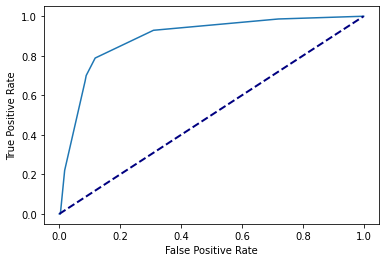



-------------Metrics for SVM------------

[0. 0. 0. ... 1. 0. 0.]
Runtime: 1.5344111919403076 seconds
Confusion Matrix: 
 [[2573  549]
 [ 265  312]]
Accuracy for the model:  0.7799405244660719
F1 Score for the model:  0.4339360222531293
Precision Score for the model:  0.3623693379790941
Recall Score for the model: 0.5407279029462738


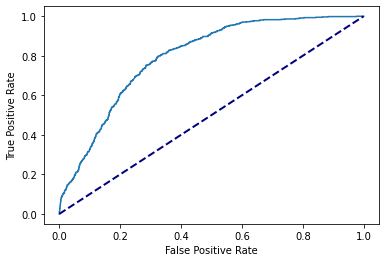



-------------Metrics for KNN------------

[0. 0. 0. ... 1. 0. 1.]
Runtime: 0.6591172218322754 seconds
Confusion Matrix: 
 [[2321  801]
 [ 181  396]]
Accuracy for the model:  0.7345228440118952
F1 Score for the model:  0.4464487034949267
Precision Score for the model:  0.3308270676691729
Recall Score for the model: 0.6863084922010398


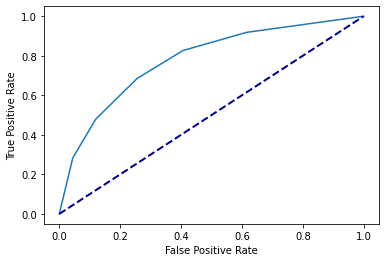



-------------Metrics for MLP------------

[0. 0. 1. ... 1. 0. 1.]
Runtime: 37.81381845474243 seconds
Confusion Matrix: 
 [[2247  875]
 [ 125  452]]
Accuracy for the model:  0.7296566639632333
F1 Score for the model:  0.4747899159663866
Precision Score for the model:  0.34061793519216277
Recall Score for the model: 0.7833622183708839


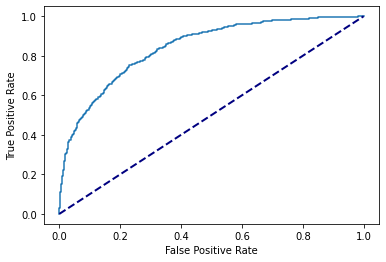

In [ ]:
# f1_score_50_data2 = []
for name, clf in models_under.items():
  print("-------------Metrics for {}------------\n".format(name))
  f1_score_data2_1.append(self_training(clf, X_train_under, y_train_under, X_test, y_test, 0.5, 1))
  print("\n")

#### 90% Unlabelled Data for UnderSampled Shoppers Data

-------------Metrics for Random Forest------------

[1. 0. 1. ... 1. 0. 1.]
Runtime: 2.5096240043640137 seconds
Confusion Matrix: 
 [[1997 1125]
 [  84  493]]
Accuracy for the model:  0.6731549067315491
F1 Score for the model:  0.4492027334851936
Precision Score for the model:  0.3046971569839308
Recall Score for the model: 0.854419410745234


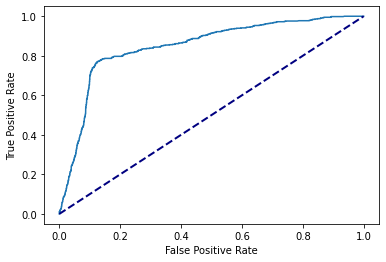



-------------Metrics for Decision Trees------------

[0. 0. 0. ... 1. 0. 1.]
Runtime: 0.046350955963134766 seconds
Confusion Matrix: 
 [[2787  335]
 [ 145  432]]
Accuracy for the model:  0.870235198702352
F1 Score for the model:  0.6428571428571429
Precision Score for the model:  0.5632333767926988
Recall Score for the model: 0.7487001733102253


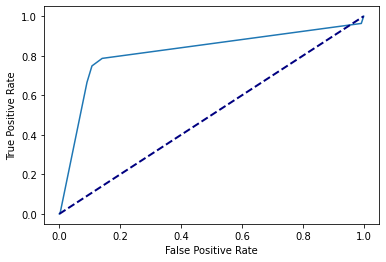



-------------Metrics for SVM------------

[0. 0. 0. ... 1. 0. 0.]
Runtime: 1.7155942916870117 seconds
Confusion Matrix: 
 [[2684  438]
 [ 434  143]]
Accuracy for the model:  0.7642606109759394
F1 Score for the model:  0.2469775474956822
Precision Score for the model:  0.24612736660929432
Recall Score for the model: 0.24783362218370883


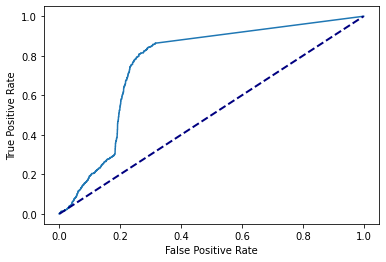



-------------Metrics for KNN------------

[0. 0. 0. ... 1. 0. 1.]
Runtime: 1.4917776584625244 seconds
Confusion Matrix: 
 [[2192  930]
 [ 185  392]]
Accuracy for the model:  0.6985671803190051
F1 Score for the model:  0.41284886782517116
Precision Score for the model:  0.29652042360060515
Recall Score for the model: 0.6793760831889082


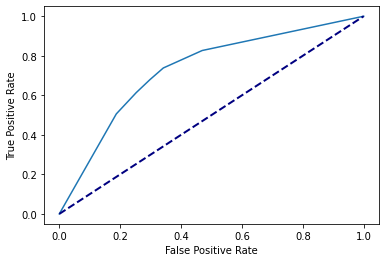



-------------Metrics for MLP------------

[1. 0. 1. ... 1. 0. 1.]
Runtime: 15.300315141677856 seconds
Confusion Matrix: 
 [[1445 1677]
 [  48  529]]
Accuracy for the model:  0.5336577453365775
F1 Score for the model:  0.3801652892561983
Precision Score for the model:  0.2398005439709882
Recall Score for the model: 0.9168110918544194


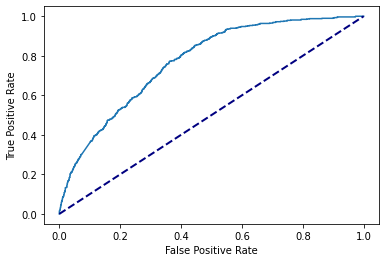

In [ ]:
for name, clf in models_under.items():
  print("-------------Metrics for {}------------\n".format(name))
  f1_score_data2_1.append(self_training(clf, X_train_under, y_train_under, X_test, y_test, 0.90, pos=1))
  print("\n")

#### 95% Unlabelled Data for UnderSampled Shoppers Data

-------------Metrics for Random Forest------------

[1. 0. 1. ... 1. 0. 1.]
Runtime: 2.401151180267334 seconds
Confusion Matrix: 
 [[2246  876]
 [  76  501]]
Accuracy for the model:  0.7426331440929981
F1 Score for the model:  0.5127942681678608
Precision Score for the model:  0.3638344226579521
Recall Score for the model: 0.8682842287694974


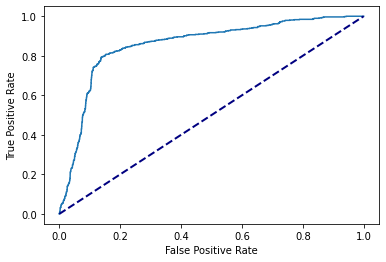



-------------Metrics for Decision Trees------------

[0. 0. 0. ... 1. 0. 1.]
Runtime: 0.06562280654907227 seconds
Confusion Matrix: 
 [[2568  554]
 [ 110  467]]
Accuracy for the model:  0.8204920248715869
F1 Score for the model:  0.5844806007509387
Precision Score for the model:  0.4573947110675808
Recall Score for the model: 0.8093587521663779


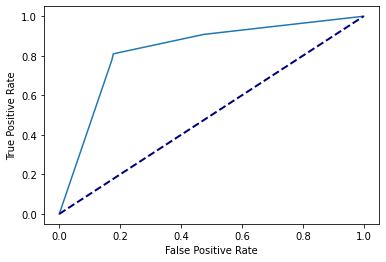



-------------Metrics for SVM------------

[0. 0. 0. ... 0. 0. 0.]
Runtime: 0.06560564041137695 seconds
Confusion Matrix: 
 [[2808  314]
 [ 466  111]]
Accuracy for the model:  0.7891321978913219
F1 Score for the model:  0.22155688622754488
Precision Score for the model:  0.2611764705882353
Recall Score for the model: 0.1923743500866551


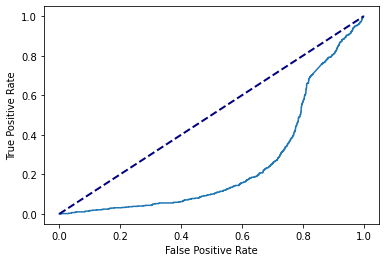



-------------Metrics for KNN------------

[0. 0. 0. ... 1. 0. 1.]
Runtime: 2.8596153259277344 seconds
Confusion Matrix: 
 [[2229  893]
 [ 201  376]]
Accuracy for the model:  0.7042443903757772
F1 Score for the model:  0.40736728060671723
Precision Score for the model:  0.2962962962962963
Recall Score for the model: 0.6516464471403813


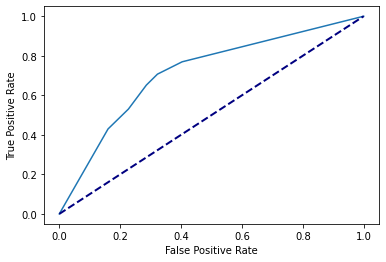



-------------Metrics for MLP------------

[0. 0. 1. ... 1. 0. 0.]
Runtime: 0.17076563835144043 seconds
Confusion Matrix: 
 [[2298  824]
 [ 168  409]]
Accuracy for the model:  0.7318194106515274
F1 Score for the model:  0.45193370165745855
Precision Score for the model:  0.33171127331711275
Recall Score for the model: 0.708838821490468


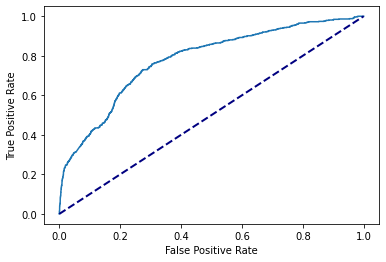

In [ ]:
for name, clf in models_under.items():
  print("-------------Metrics for {}------------\n".format(name))
  f1_score_data2_1.append(self_training(clf, X_train_under, y_train_under, X_test, y_test, 0.95))
  # self_training(clf, X_train_under, y_train_under, X_test, y_test, 0.95, pos=1)
  print("\n")

In [ ]:
algo_1.append(max(f1_score_data2_1))

#### 0% Unlabelled Data for Oversampled Shoppers

-------------Metrics for Random Forest------------

Runtime for predicting:  2.4943184852600098

Confusion Matrix: 
 [[2831  291]
 [ 134  443]]

Accuracy for the model:  0.8851040821843742
F1 Score for the model:  0.6758199847444698
Precision Score for the model:  0.603542234332425
Recall Score for the model:  0.7677642980935875


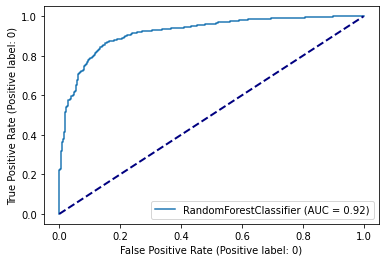



-------------Metrics for Decision Trees------------

Runtime for predicting:  0.08577227592468262

Confusion Matrix: 
 [[2781  341]
 [ 139  438]]

Accuracy for the model:  0.870235198702352
F1 Score for the model:  0.6460176991150443
Precision Score for the model:  0.5622593068035944
Recall Score for the model:  0.7590987868284229


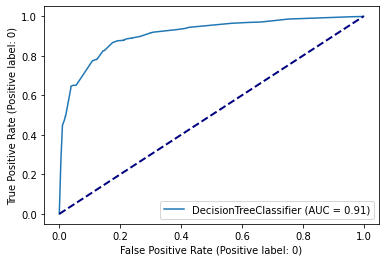



-------------Metrics for SVM------------

Runtime for predicting:  0.16558170318603516

Confusion Matrix: 
 [[2847  275]
 [ 217  360]]

Accuracy for the model:  0.8669910786699108
F1 Score for the model:  0.594059405940594
Precision Score for the model:  0.5669291338582677
Recall Score for the model:  0.6239168110918544


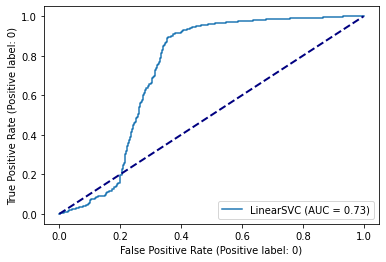



-------------Metrics for KNN------------

Runtime for predicting:  0.9440054893493652

Confusion Matrix: 
 [[2546  576]
 [ 222  355]]

Accuracy for the model:  0.7842660178426601
F1 Score for the model:  0.4708222811671087
Precision Score for the model:  0.38131041890440387
Recall Score for the model:  0.6152512998266898


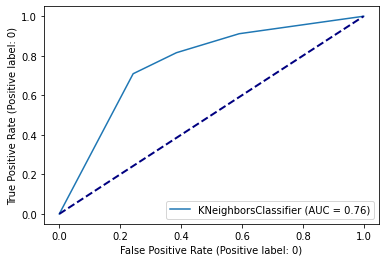



-------------Metrics for MLP------------

Runtime for predicting:  13.411252737045288

Confusion Matrix: 
 [[2682  440]
 [ 139  438]]

Accuracy for the model:  0.8434712084347121
F1 Score for the model:  0.6020618556701031
Precision Score for the model:  0.4988610478359909
Recall Score for the model:  0.7590987868284229


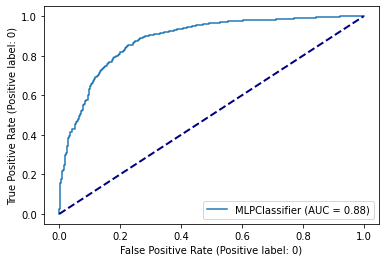

In [ ]:
f1_score_data3_1 = []
for name, clf in models1.items():
  print("-------------Metrics for {}------------\n".format(name))
  f1_score_data3_1.append(evaluate_model(clf, X_train_over, y_train_over, X_test, y_test))
  print("\n")

In [ ]:
f1_score_0_data3

[0.6811819595645412,
 0.6585760517799353,
 0.6320346320346321,
 0.3056397816858702,
 0.4781405644714998]

[1. 0. 1. ... 1. 1. 1.]
Runtime: 3.4087977409362793 seconds
Confusion Matrix: 
 [[ 168 2956]
 [  68  507]]
Accuracy for the model:  0.18248175182481752
F1 Score for the model:  0.2511144130757801
Precision Score for the model:  0.146404851285013
Recall Score for the model: 0.8817391304347826


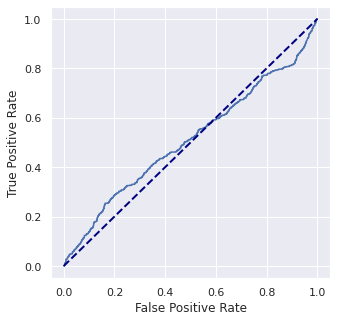

0.2511144130757801

In [ ]:
clf = SVC(C=100, max_iter=300, probability=True)
self_training(clf, X_train_over, y_train_over, X_test, y_test, 0.2, 1)

#### 10% Unlabelled Data for Oversampled Shoppers

-------------Metrics for Random Forest------------

[0. 0. 0. ... 0. 0. 0.]
Runtime: 16.08456254005432 seconds
Confusion Matrix: 
 [[2830  292]
 [ 139  438]]
Accuracy for the model:  0.8834820221681535
F1 Score for the model:  0.6702371843917369
Precision Score for the model:  0.6
Recall Score for the model: 0.7590987868284229


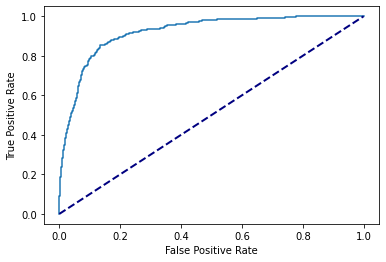



-------------Metrics for Decision Trees------------

[0. 0. 0. ... 0. 0. 1.]
Runtime: 0.2768270969390869 seconds
Confusion Matrix: 
 [[2804  318]
 [ 157  420]]
Accuracy for the model:  0.8715869153825359
F1 Score for the model:  0.6387832699619772
Precision Score for the model:  0.5691056910569106
Recall Score for the model: 0.7279029462738301


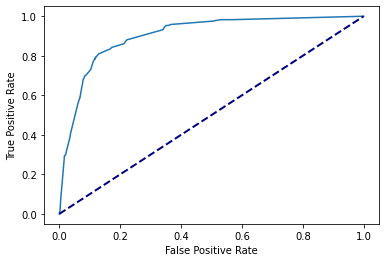



-------------Metrics for SVM------------

[0. 0. 0. ... 1. 0. 0.]
Runtime: 0.5859735012054443 seconds
Confusion Matrix: 
 [[2810  312]
 [ 452  125]]
Accuracy for the model:  0.7934576912679102
F1 Score for the model:  0.2465483234714004
Precision Score for the model:  0.28604118993135014
Recall Score for the model: 0.21663778162911612


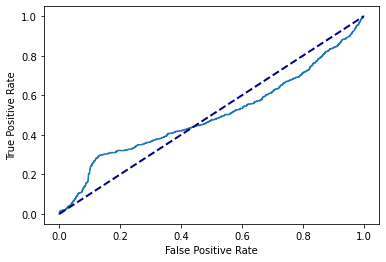



-------------Metrics for KNN------------

[0. 0. 0. ... 1. 0. 1.]
Runtime: 0.8788061141967773 seconds
Confusion Matrix: 
 [[2524  598]
 [ 215  362]]
Accuracy for the model:  0.7802108678021087
F1 Score for the model:  0.4710474951203644
Precision Score for the model:  0.3770833333333333
Recall Score for the model: 0.6273830155979203


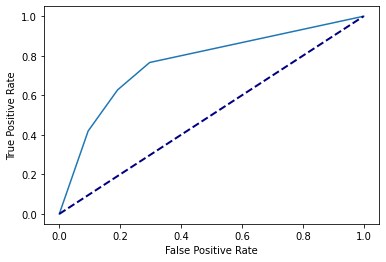



-------------Metrics for MLP------------

[0. 0. 0. ... 0. 0. 1.]
Runtime: 221.84635758399963 seconds
Confusion Matrix: 
 [[2668  454]
 [ 123  454]]
Accuracy for the model:  0.8440118951067856
F1 Score for the model:  0.6114478114478115
Precision Score for the model:  0.5
Recall Score for the model: 0.7868284228769498


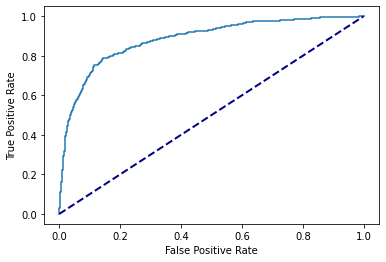

In [ ]:
for name, clf in models1.items():
  print("-------------Metrics for {}------------\n".format(name))
  if name == 'SVM':
    clf = SVC(C=1000, max_iter=50, probability=True)
  f1_score_data3_1.append(self_training(clf, X_train_over, y_train_over, X_test, y_test, 0.1, 1))
  print("\n")

#### 20% Unlabelled Data for Oversampled Shoppers

-------------Metrics for Random Forest------------

[0. 0. 0. ... 0. 0. 1.]
Runtime: 25.150367498397827 seconds
Confusion Matrix: 
 [[2829  293]
 [ 134  443]]
Accuracy for the model:  0.8845633955123007
F1 Score for the model:  0.6747905559786748
Precision Score for the model:  0.6019021739130435
Recall Score for the model: 0.7677642980935875


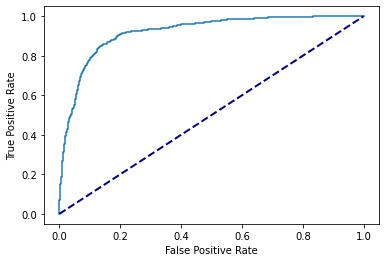



-------------Metrics for Decision Trees------------

[0. 0. 0. ... 0. 0. 0.]
Runtime: 0.2609858512878418 seconds
Confusion Matrix: 
 [[2820  302]
 [ 152  425]]
Accuracy for the model:  0.8772641254393079
F1 Score for the model:  0.651840490797546
Precision Score for the model:  0.5845942228335625
Recall Score for the model: 0.7365684575389948


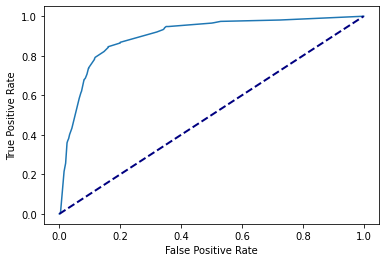



-------------Metrics for SVM------------

[1. 1. 1. ... 0. 1. 1.]
Runtime: 0.5637848377227783 seconds
Confusion Matrix: 
 [[ 419 2703]
 [ 142  435]]
Accuracy for the model:  0.23087320897539876
F1 Score for the model:  0.23418573351278602
Precision Score for the model:  0.13862332695984703
Recall Score for the model: 0.7538994800693241


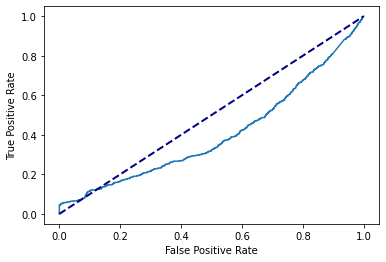



-------------Metrics for KNN------------

[0. 0. 0. ... 1. 0. 1.]
Runtime: 1.8050003051757812 seconds
Confusion Matrix: 
 [[2493  629]
 [ 205  372]]
Accuracy for the model:  0.7745336577453366
F1 Score for the model:  0.47148288973384034
Precision Score for the model:  0.37162837162837165
Recall Score for the model: 0.6447140381282496


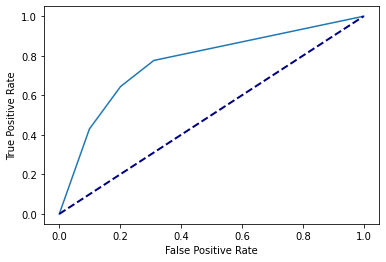



-------------Metrics for MLP------------

[0. 0. 0. ... 0. 0. 1.]
Runtime: 329.20545291900635 seconds
Confusion Matrix: 
 [[2660  462]
 [ 133  444]]
Accuracy for the model:  0.8391457150581239
F1 Score for the model:  0.5987862440997976
Precision Score for the model:  0.4900662251655629
Recall Score for the model: 0.7694974003466204


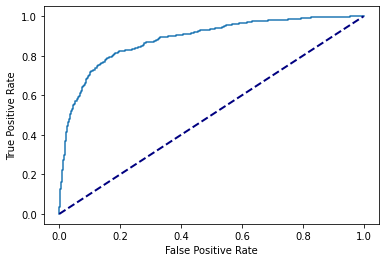

In [ ]:
# f1_score_20_data3 = []
for name, clf in models1.items():
  print("-------------Metrics for {}------------\n".format(name))
  if name == 'SVM':
    clf = SVC(C=1000, max_iter=50, probability=True)
  f1_score_data3_1.append(self_training(clf, X_train_over, y_train_over, X_test, y_test, 0.2, 1))
  print("\n")

In [ ]:
f1_score_20_data3

[0.6783161239078634,
 0.6628757108042242,
 0.17296389588581024,
 0.3050847457627119,
 0.4742268041237113]

#### 50% Unlabelled Data for Oversampled Shoppers

-------------Metrics for Random Forest------------

[0. 0. 0. ... 0. 0. 1.]
Runtime: 53.88510584831238 seconds
Confusion Matrix: 
 [[2819  303]
 [ 127  450]]
Accuracy for the model:  0.8837523655041903
F1 Score for the model:  0.6766917293233082
Precision Score for the model:  0.5976095617529881
Recall Score for the model: 0.779896013864818


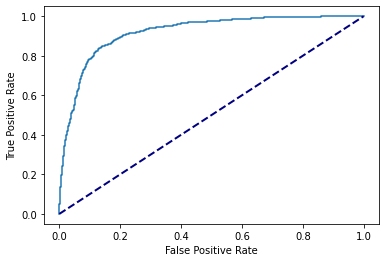



-------------Metrics for Decision Trees------------

[0. 0. 0. ... 0. 0. 0.]
Runtime: 0.4140775203704834 seconds
Confusion Matrix: 
 [[2818  304]
 [ 156  421]]
Accuracy for the model:  0.8756420654230873
F1 Score for the model:  0.6466973886328725
Precision Score for the model:  0.5806896551724138
Recall Score for the model: 0.729636048526863


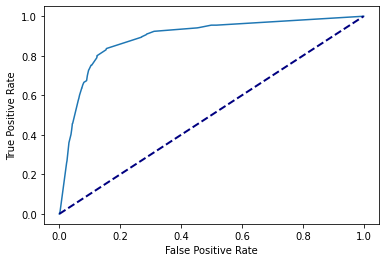



-------------Metrics for SVM------------

[1. 1. 1. ... 1. 1. 1.]
Runtime: 3.9236183166503906 seconds
Confusion Matrix: 
 [[ 225 2897]
 [  72  505]]
Accuracy for the model:  0.1973506353068397
F1 Score for the model:  0.2538326212616235
Precision Score for the model:  0.14844209288653734
Recall Score for the model: 0.8752166377816292


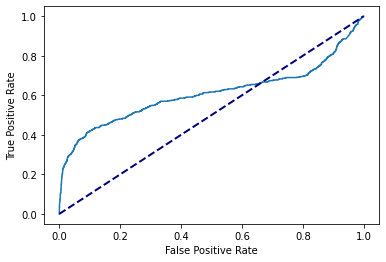



-------------Metrics for KNN------------

[0. 0. 0. ... 1. 0. 1.]
Runtime: 4.396775960922241 seconds
Confusion Matrix: 
 [[2385  737]
 [ 175  402]]
Accuracy for the model:  0.7534468775344688
F1 Score for the model:  0.4685314685314686
Precision Score for the model:  0.35294117647058826
Recall Score for the model: 0.6967071057192374


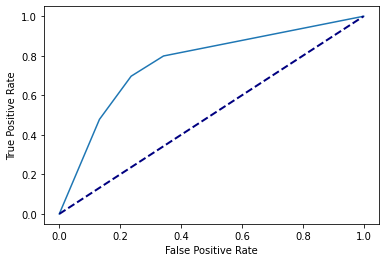



-------------Metrics for MLP------------

[0. 0. 0. ... 1. 0. 1.]
Runtime: 458.94804549217224 seconds
Confusion Matrix: 
 [[2578  544]
 [ 132  445]]
Accuracy for the model:  0.8172479048391457
F1 Score for the model:  0.5683269476372925
Precision Score for the model:  0.4499494438827098
Recall Score for the model: 0.7712305025996534


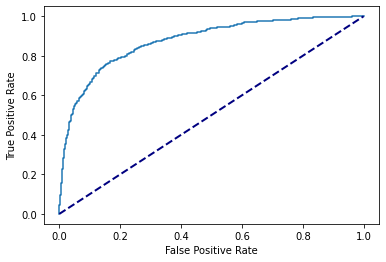

In [ ]:
# f1_score_50_data3 = []
for name, clf in models1.items():
  print("-------------Metrics for {}------------\n".format(name))
  if name == 'SVM':
    clf = SVC(C=1000, max_iter=500, probability=True)
  f1_score_data3_1.append(self_training(clf, X_train_over, y_train_over, X_test, y_test, 0.5, 1))
  print("\n")
  

In [ ]:
f1_score_50_data3

[0.6194174757281553,
 0.6061185468451242,
 0.24777862401624776,
 0.2537878787878788,
 0.003472222222222222]

#### 90% Unlabelled Data for Oversampled Shoppers

-------------Metrics for Random Forest------------

[0. 0. 0. ... 0. 0. 1.]
Runtime: 62.3435332775116 seconds
Confusion Matrix: 
 [[2756  366]
 [ 118  459]]
Accuracy for the model:  0.869153825358205
F1 Score for the model:  0.6547788873038516
Precision Score for the model:  0.5563636363636364
Recall Score for the model: 0.7954939341421143


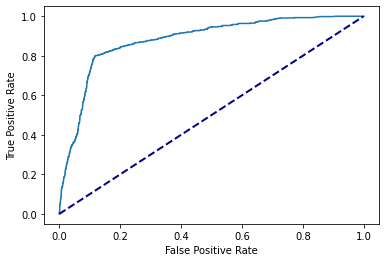



-------------Metrics for Decision Trees------------

[0. 0. 0. ... 0. 0. 0.]
Runtime: 0.5181937217712402 seconds
Confusion Matrix: 
 [[2807  315]
 [ 153  424]]
Accuracy for the model:  0.8734793187347932
F1 Score for the model:  0.6443768996960487
Precision Score for the model:  0.5737483085250338
Recall Score for the model: 0.7348353552859619


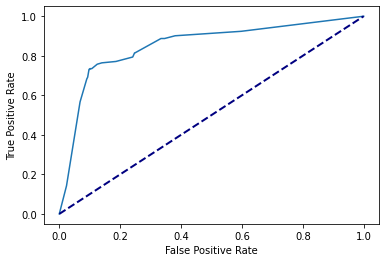



-------------Metrics for SVM------------

[0. 0. 0. ... 0. 0. 0.]
Runtime: 7.693477153778076 seconds
Confusion Matrix: 
 [[2796  326]
 [ 372  205]]
Accuracy for the model:  0.8113003514463368
F1 Score for the model:  0.37003610108303253
Precision Score for the model:  0.3860640301318267
Recall Score for the model: 0.35528596187175043


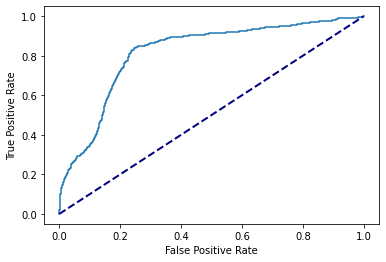



-------------Metrics for KNN------------

[0. 0. 1. ... 1. 0. 0.]
Runtime: 7.479374170303345 seconds
Confusion Matrix: 
 [[2204  918]
 [ 187  390]]
Accuracy for the model:  0.7012706136793728
F1 Score for the model:  0.41379310344827586
Precision Score for the model:  0.2981651376146789
Recall Score for the model: 0.6759098786828422


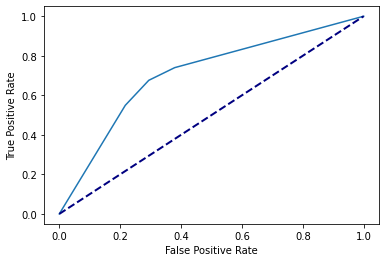



-------------Metrics for MLP------------

[0. 0. 0. ... 1. 0. 1.]
Runtime: 141.20348072052002 seconds
Confusion Matrix: 
 [[2483  639]
 [ 142  435]]
Accuracy for the model:  0.7888618545552852
F1 Score for the model:  0.5269533615990308
Precision Score for the model:  0.40502793296089384
Recall Score for the model: 0.7538994800693241


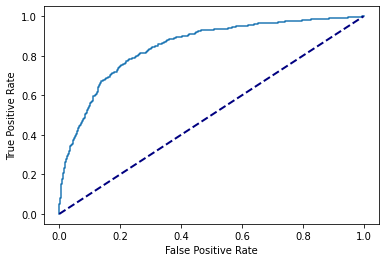

In [ ]:
# f1_score_90_data3 = []
for name, clf in models1.items():
  print("-------------Metrics for {}------------\n".format(name))
  if name == 'SVM':
    clf = SVC(C=1000, max_iter=500, probability=True)
  f1_score_data3_1.append(self_training(clf, X_train_over, y_train_over, X_test, y_test, 0.9, 1))
  print("\n")

#### 95% Unlabelled Data for Oversampled Shoppers

-------------Metrics for Random Forest------------

[0. 0. 0. ... 1. 0. 1.]
Runtime: 69.21141862869263 seconds
Confusion Matrix: 
 [[2755  367]
 [ 118  459]]
Accuracy for the model:  0.8688834820221681
F1 Score for the model:  0.654312188168211
Precision Score for the model:  0.5556900726392252
Recall Score for the model: 0.7954939341421143


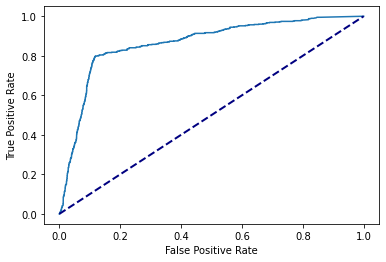



-------------Metrics for Decision Trees------------

[0. 0. 0. ... 0. 0. 1.]
Runtime: 0.7633354663848877 seconds
Confusion Matrix: 
 [[2694  428]
 [ 139  438]]
Accuracy for the model:  0.8467153284671532
F1 Score for the model:  0.6070686070686071
Precision Score for the model:  0.5057736720554272
Recall Score for the model: 0.7590987868284229


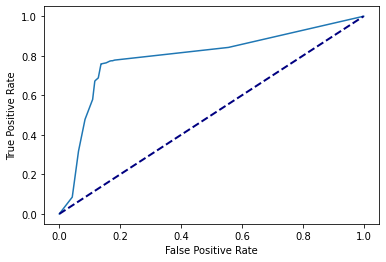



-------------Metrics for SVM------------

[0. 0. 0. ... 1. 0. 0.]
Runtime: 14.092468738555908 seconds
Confusion Matrix: 
 [[2615  507]
 [ 373  204]]
Accuracy for the model:  0.7620978642876453
F1 Score for the model:  0.31677018633540377
Precision Score for the model:  0.2869198312236287
Recall Score for the model: 0.3535528596187175


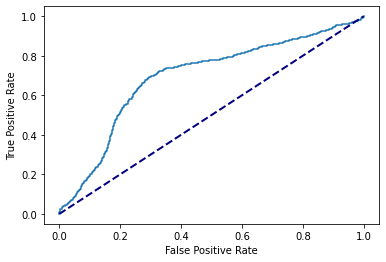



-------------Metrics for KNN------------

[0. 0. 0. ... 1. 0. 0.]
Runtime: 7.307729244232178 seconds
Confusion Matrix: 
 [[2239  883]
 [ 206  371]]
Accuracy for the model:  0.7055961070559611
F1 Score for the model:  0.40524303659202626
Precision Score for the model:  0.2958532695374801
Recall Score for the model: 0.6429809358752167


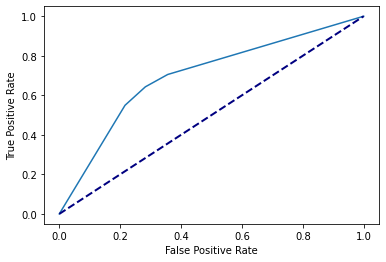



-------------Metrics for MLP------------

[0. 0. 0. ... 1. 0. 1.]
Runtime: 332.045774936676 seconds
Confusion Matrix: 
 [[2572  550]
 [ 149  428]]
Accuracy for the model:  0.8110300081103001
F1 Score for the model:  0.5504823151125402
Precision Score for the model:  0.4376278118609407
Recall Score for the model: 0.7417677642980935


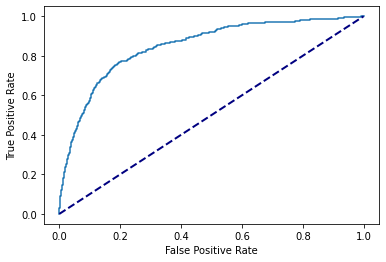

In [ ]:
for name, clf in models1.items():
  print("-------------Metrics for {}------------\n".format(name))
  if name == 'SVM':
    clf = SVC(C=1000, max_iter=500, probability=True)
  f1_score_data3_1.append(self_training(clf, X_train_over, y_train_over, X_test, y_test, 0.95, 1))
  print("\n")

In [ ]:
algo_1.append(max(f1_score_data3_1))

In [ ]:
models2 = {'Random Forest': RandomForestClassifier(max_depth=11, random_state=425), 
          'Decision Trees':DecisionTreeClassifier(max_depth=7, random_state=425), 
          'SVM': SVC(C=10, probability=True),
          'KNN': KNeighborsClassifier(n_neighbors=5),
          'MLP': MLPClassifier(solver='sgd', learning_rate='adaptive', hidden_layer_sizes=(20,), alpha=0.1,activation='tanh')}

#### 0% Unlabelled Data for Customer Data

-------------Metrics for Random Forest------------

Runtime for predicting:  0.37328624725341797

Confusion Matrix: 
 [[200  27]
 [ 24 197]]

Accuracy for the model:  0.8861607142857143
F1 Score for the model:  0.8853932584269663
Precision Score for the model:  0.8794642857142857
Recall Score for the model:  0.8914027149321267


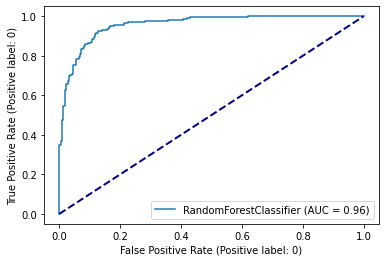



-------------Metrics for Decision Trees------------

Runtime for predicting:  0.012737274169921875

Confusion Matrix: 
 [[183  44]
 [ 21 200]]

Accuracy for the model:  0.8549107142857143
F1 Score for the model:  0.860215053763441
Precision Score for the model:  0.819672131147541
Recall Score for the model:  0.9049773755656109


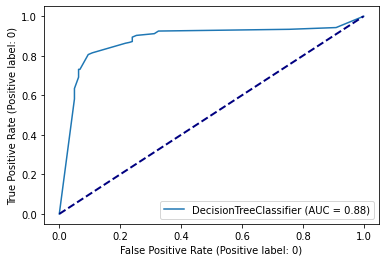



-------------Metrics for SVM------------

Runtime for predicting:  0.6605513095855713

Confusion Matrix: 
 [[200  27]
 [ 23 198]]

Accuracy for the model:  0.8883928571428571
F1 Score for the model:  0.8878923766816144
Precision Score for the model:  0.88
Recall Score for the model:  0.8959276018099548


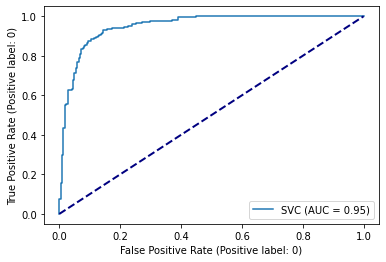



-------------Metrics for KNN------------

Runtime for predicting:  0.05033397674560547

Confusion Matrix: 
 [[174  53]
 [ 31 190]]

Accuracy for the model:  0.8125
F1 Score for the model:  0.8189655172413793
Precision Score for the model:  0.7818930041152263
Recall Score for the model:  0.8597285067873304


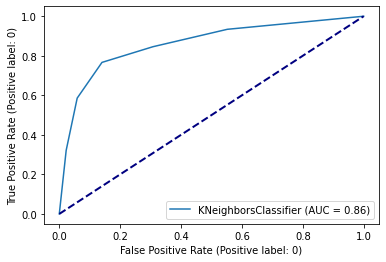



-------------Metrics for MLP------------

Runtime for predicting:  1.1795520782470703

Confusion Matrix: 
 [[188  39]
 [ 43 178]]

Accuracy for the model:  0.8169642857142857
F1 Score for the model:  0.812785388127854
Precision Score for the model:  0.8202764976958525
Recall Score for the model:  0.8054298642533937


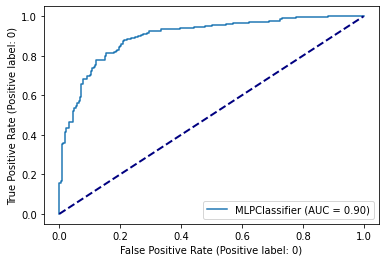

In [ ]:
f1_score_data4_1 = []
for name, clf in models2.items():
  print("-------------Metrics for {}------------\n".format(name))
  f1_score_data4_1.append(evaluate_model(clf, X_train2, y_train2, X_test2, y_test2))
  # evaluate_model(clf, X_train2, y_train2, X_test2, y_test2)
  print("\n")

#### 20% Unlabelled Data for Customer Data

-------------Metrics for Random Forest------------

Runtime: 2.800034999847412 seconds
Confusion Matrix: 
 [[201  26]
 [ 28 193]]
Accuracy for the model:  0.8794642857142857
F1 Score for the model:  0.8772727272727272
Precision Score for the model:  0.8812785388127854
Recall Score for the model: 0.8733031674208145


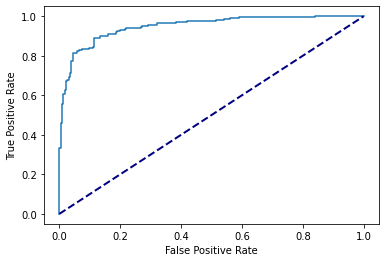



-------------Metrics for Decision Trees------------

Runtime: 0.049530982971191406 seconds
Confusion Matrix: 
 [[177  50]
 [ 28 193]]
Accuracy for the model:  0.8258928571428571
F1 Score for the model:  0.8318965517241379
Precision Score for the model:  0.7942386831275721
Recall Score for the model: 0.8733031674208145


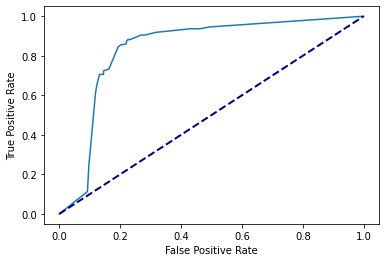



-------------Metrics for SVM------------

Runtime: 1.6243901252746582 seconds
Confusion Matrix: 
 [[200  27]
 [ 25 196]]
Accuracy for the model:  0.8839285714285714
F1 Score for the model:  0.8828828828828829
Precision Score for the model:  0.8789237668161435
Recall Score for the model: 0.8868778280542986


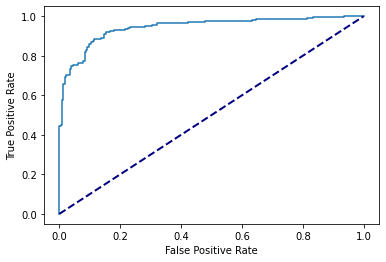



-------------Metrics for KNN------------

Runtime: 0.18885469436645508 seconds
Confusion Matrix: 
 [[169  58]
 [ 31 190]]
Accuracy for the model:  0.8013392857142857
F1 Score for the model:  0.8102345415778252
Precision Score for the model:  0.7661290322580645
Recall Score for the model: 0.8597285067873304


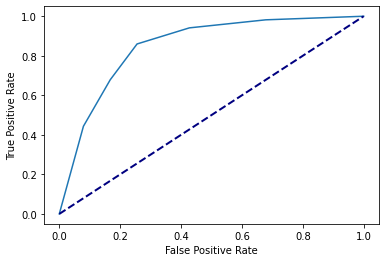



-------------Metrics for MLP------------

Runtime: 6.884899616241455 seconds
Confusion Matrix: 
 [[195  32]
 [ 37 184]]
Accuracy for the model:  0.8459821428571429
F1 Score for the model:  0.8421052631578948
Precision Score for the model:  0.8518518518518519
Recall Score for the model: 0.832579185520362


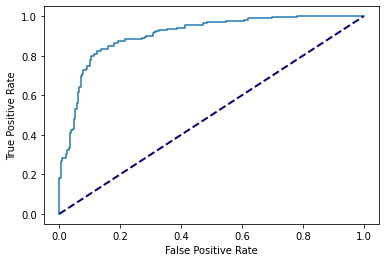

In [ ]:
for name, clf in models2.items():
  print("-------------Metrics for {}------------\n".format(name))
  f1_score_data4_1.append(self_training(clf, X_train2, y_train2, X_test2, y_test2, 0.2, pos=1))
  print("\n")




#### 10% Unlabelled Data for Customer Data

-------------Metrics for Random Forest------------

Runtime: 2.5473995208740234 seconds
Confusion Matrix: 
 [[208  19]
 [ 27 194]]
Accuracy for the model:  0.8973214285714286
F1 Score for the model:  0.8940092165898618
Precision Score for the model:  0.9107981220657277
Recall Score for the model: 0.8778280542986425


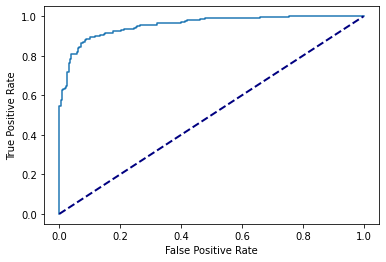



-------------Metrics for Decision Trees------------

Runtime: 0.05893874168395996 seconds
Confusion Matrix: 
 [[189  38]
 [ 24 197]]
Accuracy for the model:  0.8616071428571429
F1 Score for the model:  0.8640350877192983
Precision Score for the model:  0.8382978723404255
Recall Score for the model: 0.8914027149321267


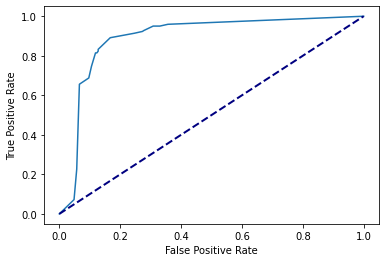



-------------Metrics for SVM------------

Runtime: 1.719712734222412 seconds
Confusion Matrix: 
 [[198  29]
 [ 24 197]]
Accuracy for the model:  0.8816964285714286
F1 Score for the model:  0.8814317673378076
Precision Score for the model:  0.8716814159292036
Recall Score for the model: 0.8914027149321267


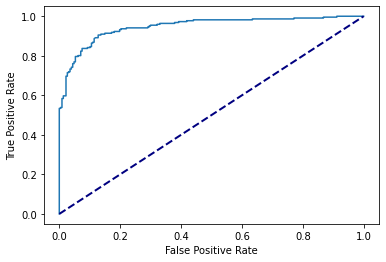



-------------Metrics for KNN------------

Runtime: 0.08983016014099121 seconds
Confusion Matrix: 
 [[170  57]
 [ 32 189]]
Accuracy for the model:  0.8013392857142857
F1 Score for the model:  0.809421841541756
Precision Score for the model:  0.7682926829268293
Recall Score for the model: 0.8552036199095022


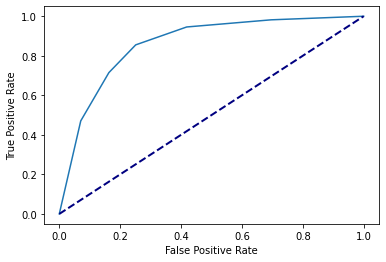



-------------Metrics for MLP------------

Runtime: 8.625171899795532 seconds
Confusion Matrix: 
 [[190  37]
 [ 41 180]]
Accuracy for the model:  0.8258928571428571
F1 Score for the model:  0.8219178082191781
Precision Score for the model:  0.8294930875576036
Recall Score for the model: 0.8144796380090498


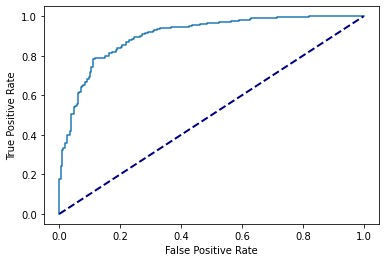

In [ ]:
for name, clf in models2.items():
  print("-------------Metrics for {}------------\n".format(name))
  f1_score_data4_1.append(self_training(clf, X_train2, y_train2, X_test2, y_test2, 0.1, pos=1))
  print("\n")




#### 50% Unlabelled Data for Customer Data

-------------Metrics for Random Forest------------

Runtime: 4.472110986709595 seconds
Confusion Matrix: 
 [[200  27]
 [ 27 194]]
Accuracy for the model:  0.8794642857142857
F1 Score for the model:  0.8778280542986425
Precision Score for the model:  0.8778280542986425
Recall Score for the model: 0.8778280542986425


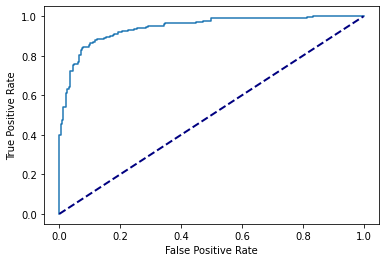



-------------Metrics for Decision Trees------------

Runtime: 0.0665123462677002 seconds
Confusion Matrix: 
 [[180  47]
 [ 26 195]]
Accuracy for the model:  0.8370535714285714
F1 Score for the model:  0.8423326133909287
Precision Score for the model:  0.8057851239669421
Recall Score for the model: 0.8823529411764706


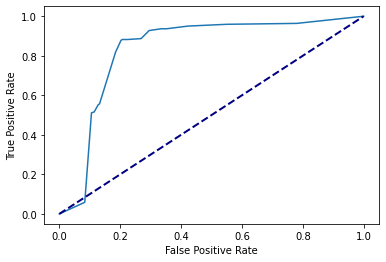



-------------Metrics for SVM------------

Runtime: 4.467437028884888 seconds
Confusion Matrix: 
 [[198  29]
 [ 30 191]]
Accuracy for the model:  0.8683035714285714
F1 Score for the model:  0.8662131519274378
Precision Score for the model:  0.8681818181818182
Recall Score for the model: 0.8642533936651584


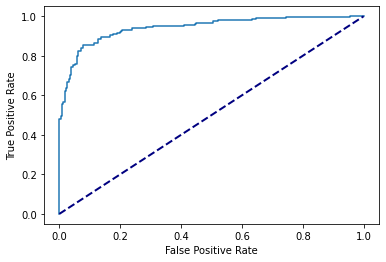



-------------Metrics for KNN------------

Runtime: 0.5230979919433594 seconds
Confusion Matrix: 
 [[170  57]
 [ 33 188]]
Accuracy for the model:  0.7991071428571429
F1 Score for the model:  0.8068669527896994
Precision Score for the model:  0.7673469387755102
Recall Score for the model: 0.8506787330316742


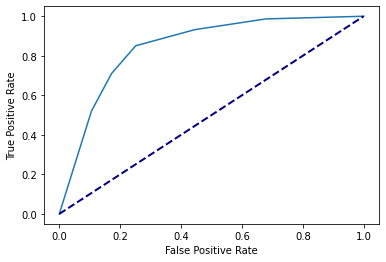



-------------Metrics for MLP------------

Runtime: 23.110026836395264 seconds
Confusion Matrix: 
 [[193  34]
 [ 39 182]]
Accuracy for the model:  0.8370535714285714
F1 Score for the model:  0.8329519450800915
Precision Score for the model:  0.8425925925925926
Recall Score for the model: 0.8235294117647058


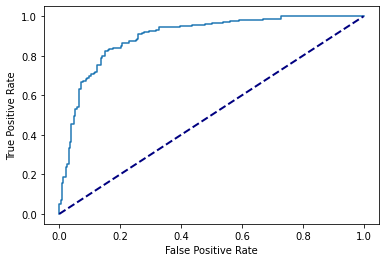

In [ ]:
for name, clf in models2.items():
  print("-------------Metrics for {}------------\n".format(name))
  f1_score_data4_1.append(self_training(clf, X_train2, y_train2, X_test2, y_test2, 0.5, pos=1))
  print("\n")




#### 90% Unlabelled Data for Customer Data

-------------Metrics for Random Forest------------

Runtime: 6.948827266693115 seconds
Confusion Matrix: 
 [[189  38]
 [ 31 190]]
Accuracy for the model:  0.8459821428571429
F1 Score for the model:  0.846325167037862
Precision Score for the model:  0.8333333333333334
Recall Score for the model: 0.8597285067873304


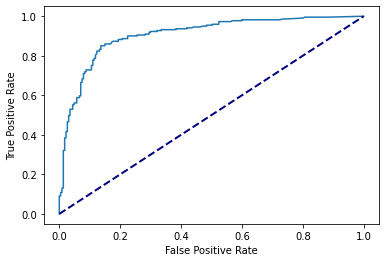



-------------Metrics for Decision Trees------------

Runtime: 0.02915167808532715 seconds
Confusion Matrix: 
 [[162  65]
 [ 37 184]]
Accuracy for the model:  0.7723214285714286
F1 Score for the model:  0.7829787234042553
Precision Score for the model:  0.7389558232931727
Recall Score for the model: 0.832579185520362


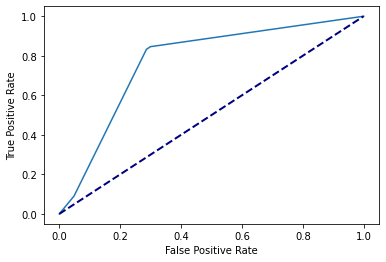



-------------Metrics for SVM------------

Runtime: 4.60401177406311 seconds
Confusion Matrix: 
 [[179  48]
 [ 35 186]]
Accuracy for the model:  0.8147321428571429
F1 Score for the model:  0.8175824175824176
Precision Score for the model:  0.7948717948717948
Recall Score for the model: 0.8416289592760181


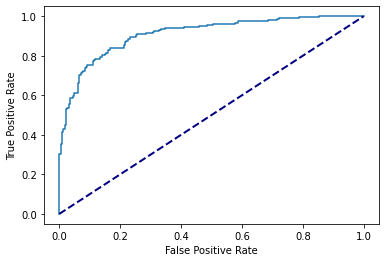



-------------Metrics for KNN------------

Runtime: 0.5974438190460205 seconds
Confusion Matrix: 
 [[151  76]
 [ 62 159]]
Accuracy for the model:  0.6919642857142857
F1 Score for the model:  0.6973684210526315
Precision Score for the model:  0.676595744680851
Recall Score for the model: 0.7194570135746606


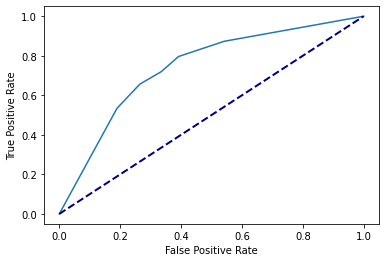



-------------Metrics for MLP------------

Runtime: 29.79710578918457 seconds
Confusion Matrix: 
 [[169  58]
 [ 33 188]]
Accuracy for the model:  0.796875
F1 Score for the model:  0.8051391862955032
Precision Score for the model:  0.7642276422764228
Recall Score for the model: 0.8506787330316742


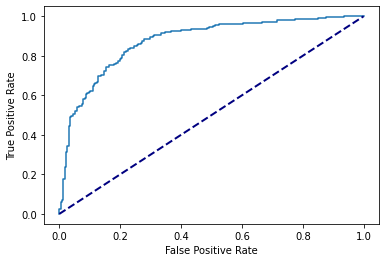

In [ ]:
for name, clf in models2.items():
  print("-------------Metrics for {}------------\n".format(name))
  f1_score_data4_1.append(self_training(clf, X_train2, y_train2, X_test2, y_test2, 0.9, pos=1))
  print("\n")




#### 95% Unlabelled Data for Customer Data

-------------Metrics for Random Forest------------

Runtime: 4.6630637645721436 seconds
Confusion Matrix: 
 [[201  26]
 [ 62 159]]
Accuracy for the model:  0.8035714285714286
F1 Score for the model:  0.7832512315270935
Precision Score for the model:  0.8594594594594595
Recall Score for the model: 0.7194570135746606


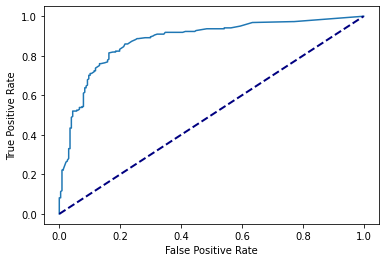



-------------Metrics for Decision Trees------------

Runtime: 0.03473949432373047 seconds
Confusion Matrix: 
 [[180  47]
 [ 66 155]]
Accuracy for the model:  0.7477678571428571
F1 Score for the model:  0.7328605200945626
Precision Score for the model:  0.7673267326732673
Recall Score for the model: 0.7013574660633484


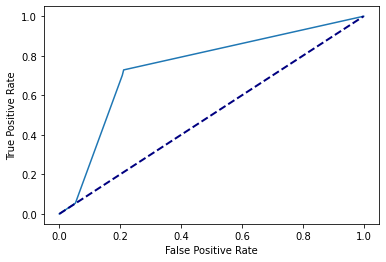



-------------Metrics for SVM------------

Runtime: 3.36013126373291 seconds
Confusion Matrix: 
 [[181  46]
 [ 53 168]]
Accuracy for the model:  0.7790178571428571
F1 Score for the model:  0.7724137931034482
Precision Score for the model:  0.7850467289719626
Recall Score for the model: 0.7601809954751131


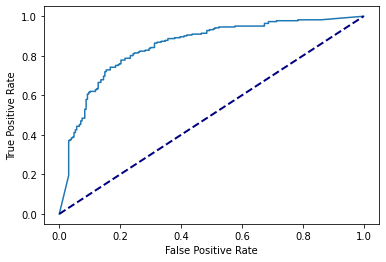



-------------Metrics for KNN------------

Runtime: 0.5412130355834961 seconds
Confusion Matrix: 
 [[124 103]
 [ 74 147]]
Accuracy for the model:  0.6049107142857143
F1 Score for the model:  0.6242038216560509
Precision Score for the model:  0.588
Recall Score for the model: 0.665158371040724


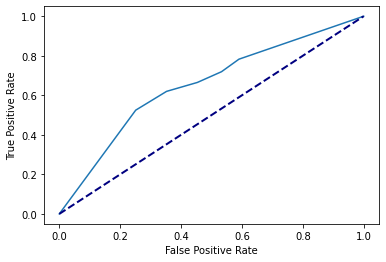



-------------Metrics for MLP------------

Runtime: 23.155365705490112 seconds
Confusion Matrix: 
 [[ 71 156]
 [ 28 193]]
Accuracy for the model:  0.5892857142857143
F1 Score for the model:  0.6771929824561403
Precision Score for the model:  0.5530085959885387
Recall Score for the model: 0.8733031674208145


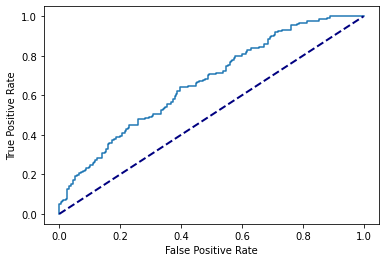

In [ ]:
for name, clf in models2.items():
  print("-------------Metrics for {}------------\n".format(name))
  f1_score_data4_1.append(self_training(clf, X_train2, y_train2, X_test2, y_test2, 0.95, pos=1))
  print("\n")




In [ ]:
algo_1.append(max(f1_score_data4_1))

In [ ]:
algo_1 

[0.6178861788617886,
 0.6571834992887625,
 0.6766917293233082,
 0.8940092165898618]

#### 0% Unlabelled Data for Heart Data

In [ ]:
models3 = {'Random Forest': RandomForestClassifier(max_depth=1, random_state=42), 
          'Decision Trees':DecisionTreeClassifier(max_depth=5, random_state=42), 
          'SVM': SVC(C=0.099, probability=True),
          'KNN': KNeighborsClassifier(n_neighbors=9),
          'MLP': MLPClassifier(solver='sgd', learning_rate='adaptive', hidden_layer_sizes=(20,), alpha=0.1,activation='tanh')}

-------------Metrics for Random Forest------------

Runtime for predicting:  0.15896177291870117

Confusion Matrix: 
 [[16 11]
 [ 2 32]]

Accuracy for the model:  0.7868852459016393
F1 Score for the model:  0.8311688311688312
Precision Score for the model:  0.7441860465116279
Recall Score for the model:  0.9411764705882353


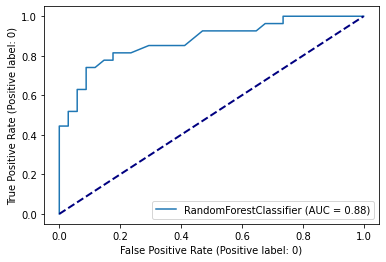



-------------Metrics for Decision Trees------------

Runtime for predicting:  0.0016736984252929688

Confusion Matrix: 
 [[17 10]
 [ 3 31]]

Accuracy for the model:  0.7868852459016393
F1 Score for the model:  0.8266666666666665
Precision Score for the model:  0.7560975609756098
Recall Score for the model:  0.9117647058823529


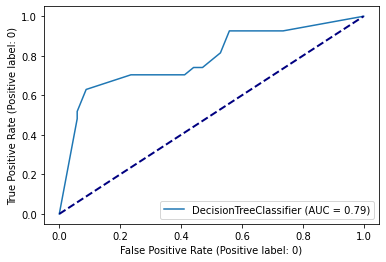



-------------Metrics for SVM------------

Runtime for predicting:  0.024329662322998047

Confusion Matrix: 
 [[18  9]
 [ 2 32]]

Accuracy for the model:  0.819672131147541
F1 Score for the model:  0.8533333333333334
Precision Score for the model:  0.7804878048780488
Recall Score for the model:  0.9411764705882353


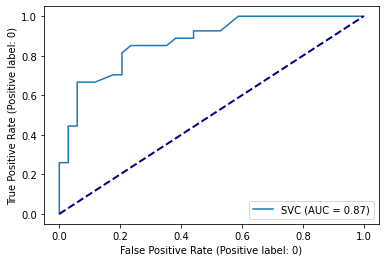



-------------Metrics for KNN------------

Runtime for predicting:  0.008101224899291992

Confusion Matrix: 
 [[17 10]
 [ 5 29]]

Accuracy for the model:  0.7540983606557377
F1 Score for the model:  0.7945205479452054
Precision Score for the model:  0.7435897435897436
Recall Score for the model:  0.8529411764705882


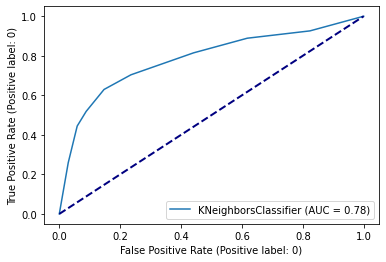



-------------Metrics for MLP------------

Runtime for predicting:  0.23067998886108398

Confusion Matrix: 
 [[19  8]
 [ 4 30]]

Accuracy for the model:  0.8032786885245902
F1 Score for the model:  0.8333333333333333
Precision Score for the model:  0.7894736842105263
Recall Score for the model:  0.8823529411764706


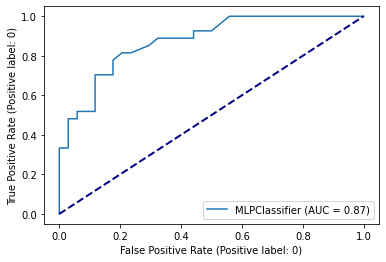

In [ ]:
f1_score_data5_1 = []
for name, clf in models3.items():
  print("-------------Metrics for {}------------\n".format(name))
  f1_score_data5_1.append(evaluate_model(clf, X_train3, y_train3, X_test3, y_test3))
  print("\n")

#### 10% Unlabelled Data for Heart Data

-------------Metrics for Random Forest------------

Runtime: 0.16275334358215332 seconds
Confusion Matrix: 
 [[17 10]
 [ 2 32]]
Accuracy for the model:  0.8032786885245902
F1 Score for the model:  0.8421052631578947
Precision Score for the model:  0.7619047619047619
Recall Score for the model: 0.9411764705882353


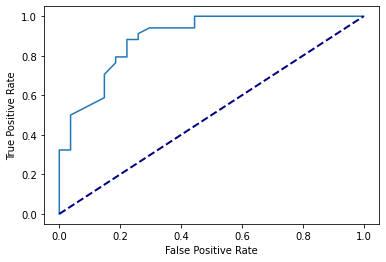



-------------Metrics for Decision Trees------------

Runtime: 0.01782989501953125 seconds
Confusion Matrix: 
 [[19  8]
 [ 6 28]]
Accuracy for the model:  0.7704918032786885
F1 Score for the model:  0.7999999999999999
Precision Score for the model:  0.7777777777777778
Recall Score for the model: 0.8235294117647058


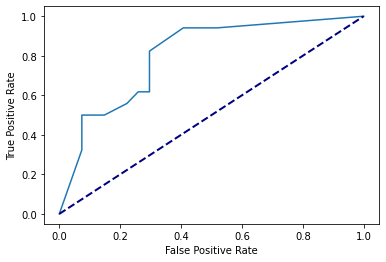



-------------Metrics for SVM------------

Runtime: 0.05916190147399902 seconds
Confusion Matrix: 
 [[18  9]
 [ 2 32]]
Accuracy for the model:  0.819672131147541
F1 Score for the model:  0.8533333333333334
Precision Score for the model:  0.7804878048780488
Recall Score for the model: 0.9411764705882353


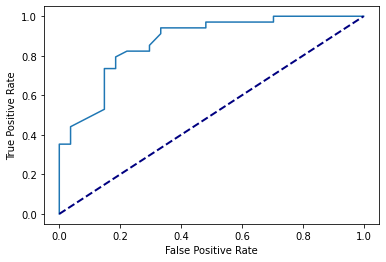



-------------Metrics for KNN------------

Runtime: 0.024452924728393555 seconds
Confusion Matrix: 
 [[18  9]
 [ 4 30]]
Accuracy for the model:  0.7868852459016393
F1 Score for the model:  0.8219178082191781
Precision Score for the model:  0.7692307692307693
Recall Score for the model: 0.8823529411764706


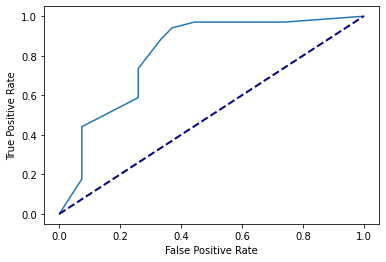



-------------Metrics for MLP------------

Runtime: 0.20539402961730957 seconds
Confusion Matrix: 
 [[22  5]
 [ 6 28]]
Accuracy for the model:  0.819672131147541
F1 Score for the model:  0.8358208955223881
Precision Score for the model:  0.8484848484848485
Recall Score for the model: 0.8235294117647058


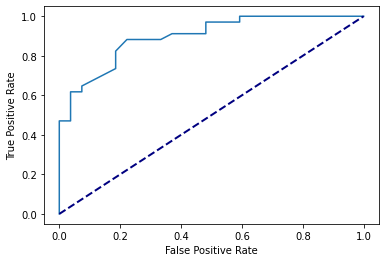

In [ ]:
for name, clf in models3.items():
  print("-------------Metrics for {}------------\n".format(name))
  f1_score_data5_1.append(self_training(clf, X_train3, y_train3, X_test3, y_test3, 0.1, pos=1))
  # self_training(clf, X_train3, y_train3, X_test3, y_test3, 0.1, pos=1)
  print("\n")




#### 20% Unlabelled Data for Heart Data

-------------Metrics for Random Forest------------

Runtime: 0.1886310577392578 seconds
Confusion Matrix: 
 [[17 10]
 [ 2 32]]
Accuracy for the model:  0.8032786885245902
F1 Score for the model:  0.8421052631578947
Precision Score for the model:  0.7619047619047619
Recall Score for the model: 0.9411764705882353


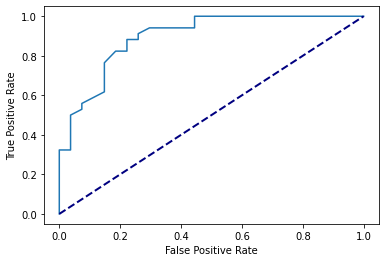



-------------Metrics for Decision Trees------------

Runtime: 0.011850118637084961 seconds
Confusion Matrix: 
 [[19  8]
 [ 7 27]]
Accuracy for the model:  0.7540983606557377
F1 Score for the model:  0.782608695652174
Precision Score for the model:  0.7714285714285715
Recall Score for the model: 0.7941176470588235


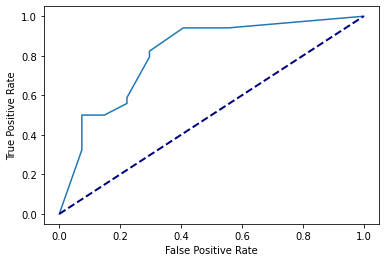



-------------Metrics for SVM------------

Runtime: 0.040346384048461914 seconds
Confusion Matrix: 
 [[17 10]
 [ 2 32]]
Accuracy for the model:  0.8032786885245902
F1 Score for the model:  0.8421052631578947
Precision Score for the model:  0.7619047619047619
Recall Score for the model: 0.9411764705882353


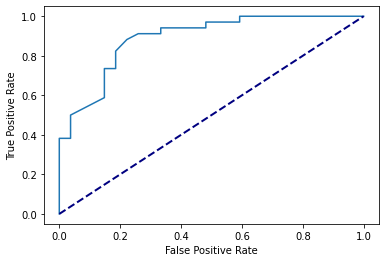



-------------Metrics for KNN------------

Runtime: 0.028705596923828125 seconds
Confusion Matrix: 
 [[18  9]
 [ 2 32]]
Accuracy for the model:  0.819672131147541
F1 Score for the model:  0.8533333333333334
Precision Score for the model:  0.7804878048780488
Recall Score for the model: 0.9411764705882353


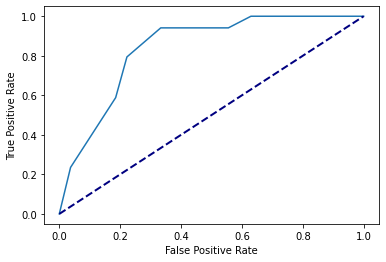



-------------Metrics for MLP------------

Runtime: 0.14015674591064453 seconds
Confusion Matrix: 
 [[20  7]
 [ 7 27]]
Accuracy for the model:  0.7704918032786885
F1 Score for the model:  0.7941176470588235
Precision Score for the model:  0.7941176470588235
Recall Score for the model: 0.7941176470588235


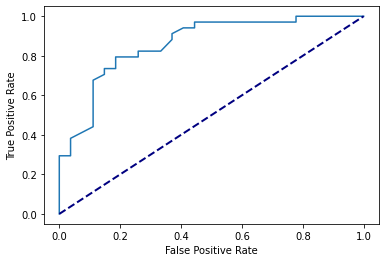

In [ ]:
for name, clf in models3.items():
  print("-------------Metrics for {}------------\n".format(name))
  f1_score_data5_1.append(self_training(clf, X_train3, y_train3, X_test3, y_test3, 0.2, pos=1))
  # self_training(clf, X_train3, y_train3, X_test3, y_test3, 0.2, pos=1)
  print("\n")




#### 50% Unlabelled Data for Heart Data

-------------Metrics for Random Forest------------

Runtime: 0.18509292602539062 seconds
Confusion Matrix: 
 [[17 10]
 [ 4 30]]
Accuracy for the model:  0.7704918032786885
F1 Score for the model:  0.8108108108108107
Precision Score for the model:  0.75
Recall Score for the model: 0.8823529411764706


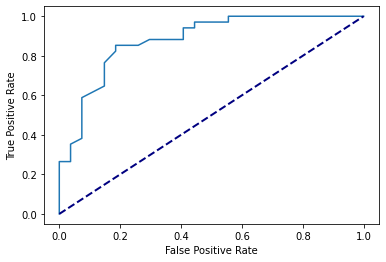



-------------Metrics for Decision Trees------------

Runtime: 0.03399252891540527 seconds
Confusion Matrix: 
 [[17 10]
 [ 6 28]]
Accuracy for the model:  0.7377049180327869
F1 Score for the model:  0.7777777777777778
Precision Score for the model:  0.7368421052631579
Recall Score for the model: 0.8235294117647058


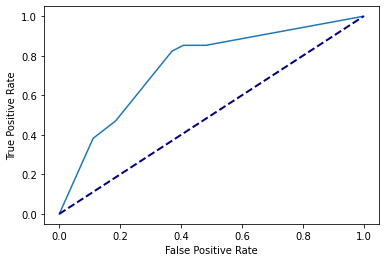



-------------Metrics for SVM------------

Runtime: 0.05307960510253906 seconds
Confusion Matrix: 
 [[16 11]
 [ 2 32]]
Accuracy for the model:  0.7868852459016393
F1 Score for the model:  0.8311688311688312
Precision Score for the model:  0.7441860465116279
Recall Score for the model: 0.9411764705882353


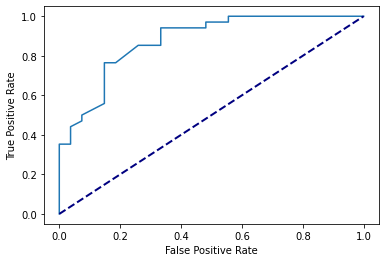



-------------Metrics for KNN------------

Runtime: 0.04595637321472168 seconds
Confusion Matrix: 
 [[18  9]
 [ 3 31]]
Accuracy for the model:  0.8032786885245902
F1 Score for the model:  0.8378378378378379
Precision Score for the model:  0.775
Recall Score for the model: 0.9117647058823529


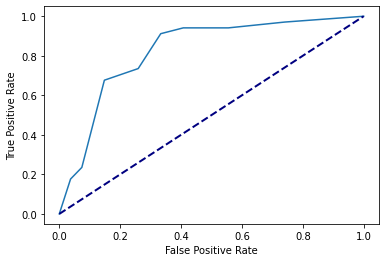



-------------Metrics for MLP------------

Runtime: 0.11216306686401367 seconds
Confusion Matrix: 
 [[20  7]
 [10 24]]
Accuracy for the model:  0.7213114754098361
F1 Score for the model:  0.7384615384615385
Precision Score for the model:  0.7741935483870968
Recall Score for the model: 0.7058823529411765


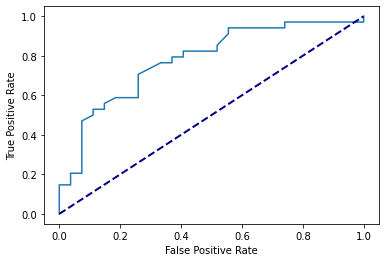

In [ ]:
for name, clf in models3.items():
  print("-------------Metrics for {}------------\n".format(name))
  f1_score_data5_1.append(self_training(clf, X_train3, y_train3, X_test3, y_test3, 0.5, pos=1))
  print("\n")

#### 90% Unlabeled Data for Heart Data

-------------Metrics for Random Forest------------

Runtime: 0.1846635341644287 seconds
Confusion Matrix: 
 [[18  9]
 [ 3 31]]
Accuracy for the model:  0.8032786885245902
F1 Score for the model:  0.8378378378378379
Precision Score for the model:  0.775
Recall Score for the model: 0.9117647058823529


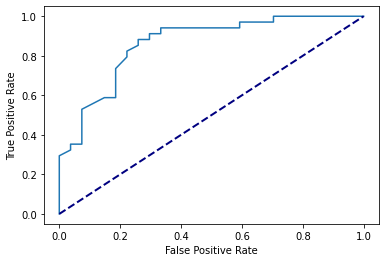



-------------Metrics for Decision Trees------------

Runtime: 0.028829097747802734 seconds
Confusion Matrix: 
 [[18  9]
 [ 8 26]]
Accuracy for the model:  0.7213114754098361
F1 Score for the model:  0.7536231884057971
Precision Score for the model:  0.7428571428571429
Recall Score for the model: 0.7647058823529411


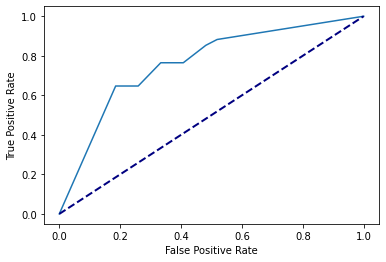



-------------Metrics for SVM------------

Runtime: 0.013455629348754883 seconds
Confusion Matrix: 
 [[15 12]
 [ 2 32]]
Accuracy for the model:  0.7704918032786885
F1 Score for the model:  0.8205128205128205
Precision Score for the model:  0.7272727272727273
Recall Score for the model: 0.9411764705882353


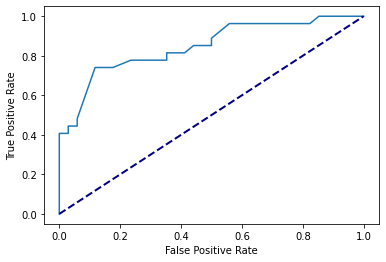



-------------Metrics for KNN------------

Runtime: 0.15514016151428223 seconds
Confusion Matrix: 
 [[10 17]
 [ 2 32]]
Accuracy for the model:  0.6885245901639344
F1 Score for the model:  0.7710843373493975
Precision Score for the model:  0.6530612244897959
Recall Score for the model: 0.9411764705882353


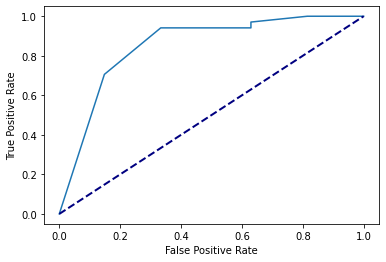



-------------Metrics for MLP------------

Runtime: 0.1024332046508789 seconds
Confusion Matrix: 
 [[21  6]
 [ 9 25]]
Accuracy for the model:  0.7540983606557377
F1 Score for the model:  0.7692307692307693
Precision Score for the model:  0.8064516129032258
Recall Score for the model: 0.7352941176470589


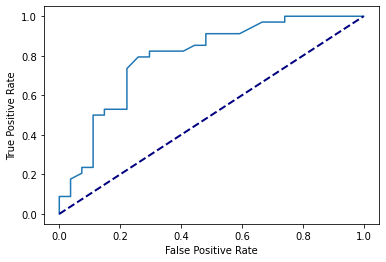

In [ ]:
for name, clf in models3.items():
  print("-------------Metrics for {}------------\n".format(name))
  if name == 'SVM':
    pos=0
  else: 
    pos=1
  # f1_score_data5_1.append(self_training(clf, X_train3, y_train3, X_test3, y_test3, 0.9, pos=1))
  self_training(clf, X_train3, y_train3, X_test3, y_test3, 0.9, pos)
  print("\n")

#### 95% Unlabelled Data for Heart Data

-------------Metrics for Random Forest------------

Runtime: 0.18504095077514648 seconds
Confusion Matrix: 
 [[11 16]
 [ 1 33]]
Accuracy for the model:  0.7213114754098361
F1 Score for the model:  0.7951807228915663
Precision Score for the model:  0.673469387755102
Recall Score for the model: 0.9705882352941176


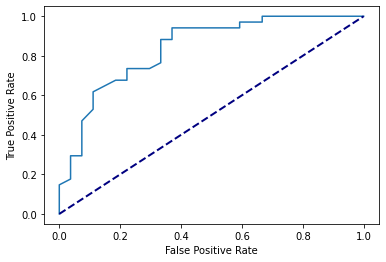



-------------Metrics for Decision Trees------------

Runtime: 0.020066261291503906 seconds
Confusion Matrix: 
 [[20  7]
 [22 12]]
Accuracy for the model:  0.5245901639344263
F1 Score for the model:  0.45283018867924524
Precision Score for the model:  0.631578947368421
Recall Score for the model: 0.35294117647058826


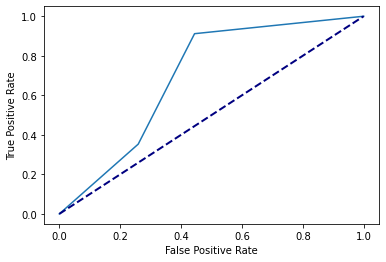



-------------Metrics for SVM------------

Runtime: 0.008959770202636719 seconds
Confusion Matrix: 
 [[ 0 27]
 [ 0 34]]
Accuracy for the model:  0.5573770491803278
F1 Score for the model:  0.7157894736842105
Precision Score for the model:  0.5573770491803278
Recall Score for the model: 1.0


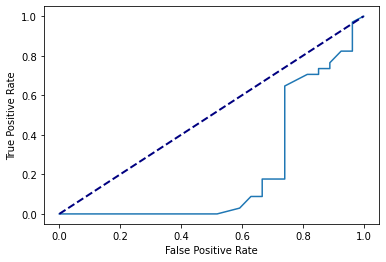



-------------Metrics for KNN------------

Runtime: 0.027878522872924805 seconds
Confusion Matrix: 
 [[13 14]
 [ 1 33]]
Accuracy for the model:  0.7540983606557377
F1 Score for the model:  0.8148148148148149
Precision Score for the model:  0.7021276595744681
Recall Score for the model: 0.9705882352941176


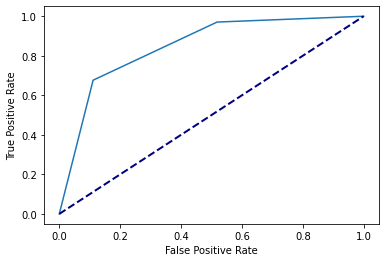



-------------Metrics for MLP------------

Runtime: 0.08815813064575195 seconds
Confusion Matrix: 
 [[14 13]
 [ 3 31]]
Accuracy for the model:  0.7377049180327869
F1 Score for the model:  0.794871794871795
Precision Score for the model:  0.7045454545454546
Recall Score for the model: 0.9117647058823529


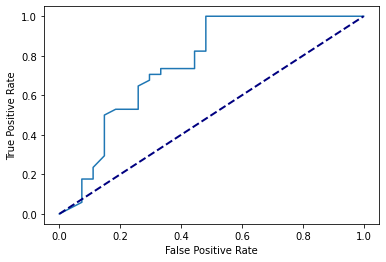

In [ ]:
for name, clf in models3.items():
  print("-------------Metrics for {}------------\n".format(name))
  if name == 'SVM':
    pos=0
  else: 
    pos=1
  f1_score_data5_1.append(self_training(clf, X_train3, y_train3, X_test3, y_test3, 0.95, pos=1))
  # self_training(clf, X_train3, y_train3, X_test3, y_test3, 0.95, pos)
  print("\n")

In [ ]:
algo_1.append(max(f1_score_data5_1))

In [ ]:
np.save('algo_1.npy', algo_1)

### 2. Semi Supervised Ensemble
VotingClassifier

In [ ]:
def Ensemble(X_train, y_train, X_test, y_test, depth, sub=0.9, col=0.2, neighbor=5, est=500, pos=0):  
  
  start = time.time()
  m1 = DecisionTreeClassifier(max_depth=depth)
  m2 = GaussianNB()
  m3 = XGBRFClassifier(n_estimators=est, subsample=sub, colsample_bynode=col) 
  ensem = VotingClassifier(estimators=[('ExtraT', m1), ('Gaussian', m2),('XGBRF', m3)], voting='hard', weights=[2, 2, 3])
  ensem.fit(X_train, y_train)
  preds = ensem.predict(X_test)
  # pred_proba = ensem.decision_function(X_test)
  # print("**************", pred_proba)
  end = time.time() - start
  print("Runtime for predicting: ", end)
  print("\nConfusion Matrix: \n", confusion_matrix(y_test, preds))
  print("\nAccuracy for the model: ", accuracy_score(y_test, preds))
  print("F1 Score for the model: ", f1_score(y_test, preds))
  print("Precision Score for the model: ", precision_score(y_test, preds))
  print("Recall Score for the model: ", recall_score(y_test, preds))

  fpr, tpr, thresholds = roc_curve(y_test, preds)
  plt.plot(fpr, tpr, linewidth=2)


  # plot_roc_curve(ensem, X_test, y_test, pos_label=pos)
  # display = PrecisionRecallDisplay.from_estimator(ensem, X_test, y_test, name='Voting')

  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.show()
  return f1_score(y_test, preds)


In [ ]:
def Ensemble_semi(X_train, y_train, X_test, y_test, depth, percent_of_unlabel, split, sub=0.9, col=0.2, est=500, pos=0):  
  
  start = time.time()
  m1 = DecisionTreeClassifier(max_depth=depth)  
  m2 = GaussianNB()
  m3 = XGBRFClassifier(n_estimators=est, subsample=sub, colsample_bynode=col)
  ensem = VotingClassifier(estimators=[('ExtraT', m1), ('Gaussian', m2),('XGBRF', m3)], voting='hard', weights=[2, 2, 3])
  new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(X_train, y_train, test_size=percent_of_unlabel, random_state=425)

  new_X_test, new_y_test = shuffle(new_X_test, new_y_test, random_state=42)

  for i in range(1, split+1):
    n = 0 
    ensem.fit(new_X_train, new_y_train)
    preds = ensem.predict(new_X_test[int(n*len(new_X_test)/split):int(i*len(new_X_test)/split)])
    new_X_train = np.concatenate((new_X_train, new_X_test[int(n*len(new_X_test)/split):int(i*len(new_X_test)/split)]), axis=0)
    new_y_train = np.concatenate((new_y_train, preds), axis=0)
    n += 1

  final_pred = ensem.predict(X_test)

  end = time.time() - start
  print("Runtime for predicting: ", end)
  print("\nConfusion Matrix: \n", confusion_matrix(y_test, final_pred))
  print("\nAccuracy for the model: ", accuracy_score(y_test, final_pred))
  print("F1 Score for the model: ", f1_score(y_test, final_pred))
  print("Precision Score for the model: ", precision_score(y_test, final_pred))
  print("Recall Score for the model: ", recall_score(y_test, final_pred))

  fpr, tpr, thresholds = roc_curve(y_test, final_pred)
  plt.plot(fpr, tpr, linewidth=2)


  # plot_roc_curve(ensem, X_test, y_test, pos_label=pos)
  # display = PrecisionRecallDisplay.from_estimator(ensem, X_test, y_test, name='Voting')

  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.show()
  return f1_score(y_test, final_pred)

#### 0% Unlaballed Data for Shoppers Data

In [ ]:
f1_score_data1_2 = []

Runtime for predicting:  1.1170604228973389

Confusion Matrix: 
 [[2896  226]
 [ 233  344]]

Accuracy for the model:  0.8759124087591241
F1 Score for the model:  0.5998256320836965
Precision Score for the model:  0.6035087719298246
Recall Score for the model:  0.5961871750433275


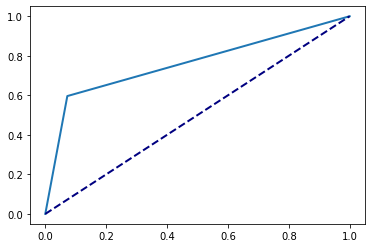

In [ ]:
f1_score_data1_2.append(Ensemble(X_train, y_train, X_test, y_test, 1,0.6, 0.2, neighbor=3, est=500, pos=0))

#### 10% Unlaballed Data for Shoppers Data

Runtime for predicting:  3.0945544242858887

Confusion Matrix: 
 [[2999  123]
 [ 321  256]]

Accuracy for the model:  0.8799675587996756
F1 Score for the model:  0.5355648535564853
Precision Score for the model:  0.6754617414248021
Recall Score for the model:  0.4436741767764298


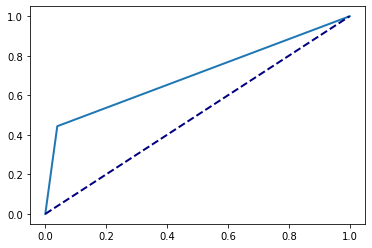

In [ ]:
f1_score_data1_2.append(Ensemble_semi(X_train, y_train, X_test, y_test, depth=7, percent_of_unlabel=0.1, split=3, sub=0.6, col=0.3, neighbor=4, est=500))

#### 20% Unlaballed Data for Shoppers Data

Runtime for predicting:  4.922593593597412

Confusion Matrix: 
 [[3010  112]
 [ 320  257]]

Accuracy for the model:  0.8832116788321168
F1 Score for the model:  0.5433403805496829
Precision Score for the model:  0.6964769647696477
Recall Score for the model:  0.44540727902946275


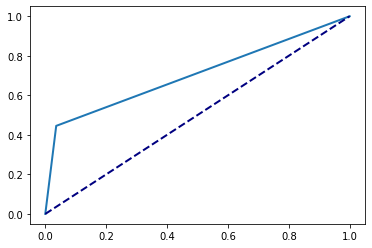

In [ ]:
f1_score_data1_2.append(Ensemble_semi(X_train, y_train, X_test, y_test, depth=5, percent_of_unlabel=0.1, split=6, sub=0.9, col=0.2, neighbor=5, est=500))

#### 50% Unlaballed Data for Shoppers Data

Runtime for predicting:  3.9397006034851074

Confusion Matrix: 
 [[3063   59]
 [ 366  211]]

Accuracy for the model:  0.8851040821843742
F1 Score for the model:  0.4982290436835891
Precision Score for the model:  0.7814814814814814
Recall Score for the model:  0.36568457538994803


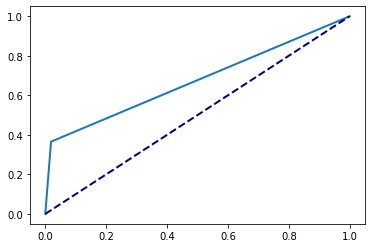

In [ ]:
f1_score_data1_2.append(Ensemble_semi(X_train, y_train, X_test, y_test, depth=5, percent_of_unlabel=0.5, split=5, sub=0.9, col=0.2, neighbor=6, est=500))

#### 90% Unlaballed Data for Shoppers Data

Runtime for predicting:  5.908384799957275

Confusion Matrix: 
 [[3068   54]
 [ 440  137]]

Accuracy for the model:  0.8664503919978372
F1 Score for the model:  0.35677083333333337
Precision Score for the model:  0.7172774869109948
Recall Score for the model:  0.23743500866551126


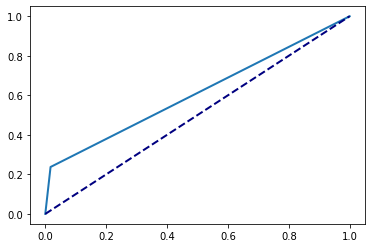

In [ ]:
f1_score_data1_2.append(Ensemble_semi(X_train, y_train, X_test, y_test, depth=5, percent_of_unlabel=0.9, split=4, sub=0.6, col=0.3, neighbor=6, est=1000))

#### 95% Unlaballed Data for Shoppers Data

Runtime for predicting:  4.7130372524261475

Confusion Matrix: 
 [[3079   43]
 [ 407  170]]

Accuracy for the model:  0.878345498783455
F1 Score for the model:  0.43037974683544306
Precision Score for the model:  0.7981220657276995
Recall Score for the model:  0.29462738301559793


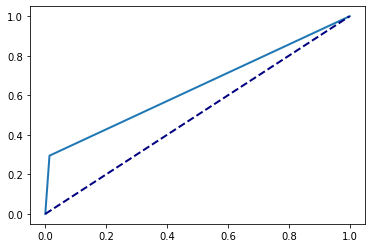

In [ ]:
f1_score_data1_2.append(Ensemble_semi(X_train, y_train, X_test, y_test, depth=5, percent_of_unlabel=0.95, split=5, sub=0.6, col=0.3, neighbor=6, est=500))

In [ ]:
algo_2 = []
algo_2.append(max(f1_score_data1_2))

#### 0% Unlaballed Data for Undersample Shoppers Data

Runtime for predicting:  0.40074872970581055

Confusion Matrix: 
 [[2586  536]
 [  86  491]]

Accuracy for the model:  0.8318464449851312
F1 Score for the model:  0.612219451371571
Precision Score for the model:  0.4780915287244401
Recall Score for the model:  0.8509532062391681


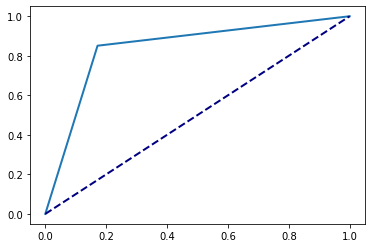

In [ ]:
f1_score_data12_2 = []
f1_score_data12_2.append(Ensemble(X_train_under, y_train_under, X_test, y_test, 3,0.6, 0.2, neighbor=3, est=500, pos=0))

#### 10% Unlaballed Data for Undersample Shoppers Data

Runtime for predicting:  1.7806570529937744

Confusion Matrix: 
 [[2652  470]
 [ 102  475]]

Accuracy for the model:  0.8453636117869695
F1 Score for the model:  0.6241787122207622
Precision Score for the model:  0.5026455026455027
Recall Score for the model:  0.8232235701906413


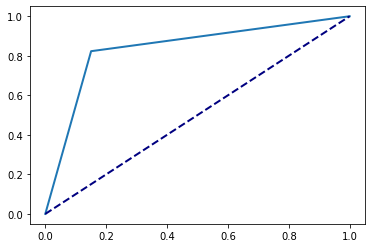

In [ ]:
f1_score_data12_2.append(Ensemble_semi(X_train_under, y_train_under, X_test, y_test, depth=7, percent_of_unlabel=0.1, split=6, sub=0.9, col=0.2, neighbor=5, est=500))

#### 20% Unlaballed Data for Undersample Shoppers Data

Runtime for predicting:  1.8104171752929688

Confusion Matrix: 
 [[2649  473]
 [ 104  473]]

Accuracy for the model:  0.8440118951067856
F1 Score for the model:  0.6211424819435325
Precision Score for the model:  0.5
Recall Score for the model:  0.8197573656845754


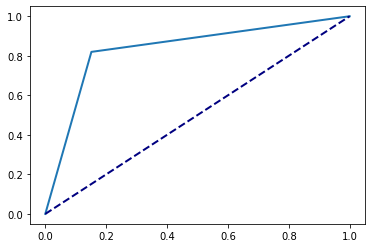

In [ ]:
f1_score_data12_2.append(Ensemble_semi(X_train_under, y_train_under, X_test, y_test, depth=7, percent_of_unlabel=0.2, split=6, sub=0.9, col=0.2, neighbor=5, est=500))

#### 50% Unlaballed Data for UnderSample Shoppers Data

Runtime for predicting:  3.270704746246338

Confusion Matrix: 
 [[2372  750]
 [  94  483]]

Accuracy for the model:  0.771830224384969
F1 Score for the model:  0.5337016574585636
Precision Score for the model:  0.39172749391727496
Recall Score for the model:  0.8370883882149047


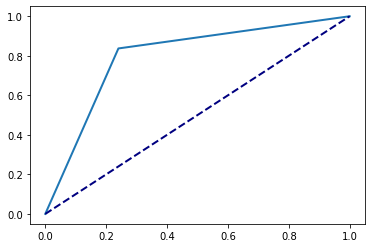

In [ ]:
f1_score_data12_2.append(Ensemble_semi(X_train_under, y_train_under, X_test, y_test, depth=9, percent_of_unlabel=0.5, split=9, sub=0.9, col=0.2, neighbor=7, est=500))

#### 90% Unlaballed Data for UnderSample Shoppers Data

Runtime for predicting:  4.918922662734985

Confusion Matrix: 
 [[2656  466]
 [ 117  460]]

Accuracy for the model:  0.842389835090565
F1 Score for the model:  0.612109115103127
Precision Score for the model:  0.49676025917926564
Recall Score for the model:  0.7972270363951474


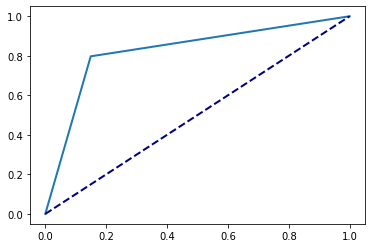

In [ ]:
f1_score_data12_2.append(Ensemble_semi(X_train_under, y_train_under, X_test, y_test, depth=9, percent_of_unlabel=0.9, split=10, sub=0.9, col=0.3, neighbor=7, est=500))

#### 95% Unlaballed Data for UnderSample Shoppers Data

Runtime for predicting:  4.80074667930603

Confusion Matrix: 
 [[2568  554]
 [ 103  474]]

Accuracy for the model:  0.8223844282238443
F1 Score for the model:  0.5906542056074767
Precision Score for the model:  0.46108949416342415
Recall Score for the model:  0.8214904679376083


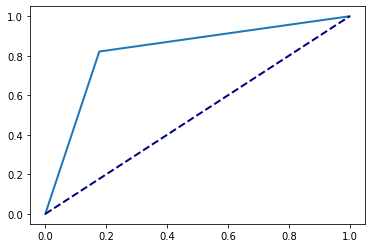

In [ ]:
f1_score_data12_2.append(Ensemble_semi(X_train_under, y_train_under, X_test, y_test, depth=9, percent_of_unlabel=0.95, split=9, sub=0.9, col=0.4, neighbor=7, est=500))

In [ ]:
algo_2.append(max(f1_score_data12_2))

In [ ]:
algo_2

[0.5998256320836965, 0.6241787122207622]

#### 0% Unlballed Data for Oversample Shoppers Data

In [ ]:
f1_score_data3_2 = []

Runtime for predicting:  1.7836427688598633

Confusion Matrix: 
 [[2719  403]
 [ 106  471]]

Accuracy for the model:  0.8623952419572858
F1 Score for the model:  0.6492074431426602
Precision Score for the model:  0.5389016018306636
Recall Score for the model:  0.8162911611785095


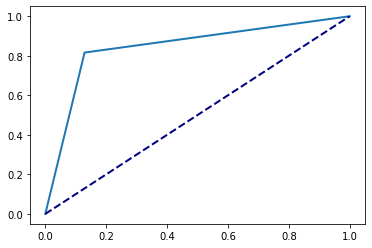

In [ ]:
f1_score_data3_2.append(Ensemble(X_train_over, y_train_over, X_test, y_test, 7,0.6, 0.2, neighbor=3, est=500, pos=0))

#### 10% Unlballed Data for Oversample Shoppers Data

Runtime for predicting:  9.152757406234741

Confusion Matrix: 
 [[2737  385]
 [ 104  473]]

Accuracy for the model:  0.8678021086780211
F1 Score for the model:  0.659233449477352
Precision Score for the model:  0.5512820512820513
Recall Score for the model:  0.8197573656845754


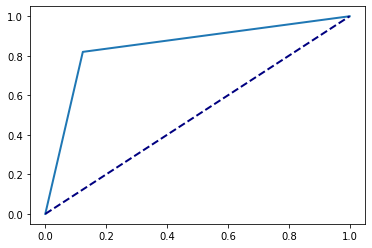

In [ ]:
f1_score_data3_2.append(Ensemble_semi(X_train_over, y_train_over, X_test, y_test, depth=7, percent_of_unlabel=0.1, split=6, sub=0.9, col=0.2, neighbor=5, est=500))

#### 20% Unlballed Data for Oversample Shoppers Data

Runtime for predicting:  11.023639440536499

Confusion Matrix: 
 [[2769  353]
 [ 127  450]]

Accuracy for the model:  0.870235198702352
F1 Score for the model:  0.6521739130434783
Precision Score for the model:  0.5603985056039851
Recall Score for the model:  0.779896013864818


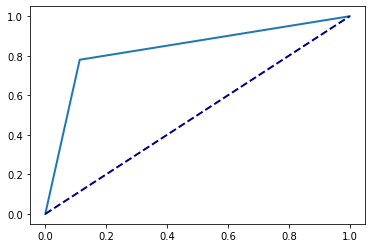

In [ ]:
f1_score_data3_2.append(Ensemble_semi(X_train_over, y_train_over, X_test, y_test, depth=6, percent_of_unlabel=0.2, split=7, sub=0.9, col=0.2, neighbor=4, est=500))

#### 50% Unlballed Data for Oversample Shoppers Data

Runtime for predicting:  17.51098322868347

Confusion Matrix: 
 [[2732  390]
 [ 112  465]]

Accuracy for the model:  0.8642876453095432
F1 Score for the model:  0.6494413407821229
Precision Score for the model:  0.543859649122807
Recall Score for the model:  0.8058925476603119


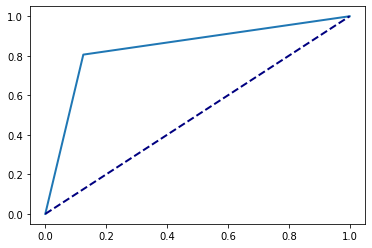

In [ ]:
f1_score_data3_2.append(Ensemble_semi(X_train_over, y_train_over, X_test, y_test, depth=9, percent_of_unlabel=0.5, split=9, sub=0.9, col=0.2, neighbor=7, est=500))

#### 90% Unlballed Data for Oversample Shoppers Data

Runtime for predicting:  24.552523374557495

Confusion Matrix: 
 [[2715  407]
 [ 115  462]]

Accuracy for the model:  0.8588807785888077
F1 Score for the model:  0.6390041493775933
Precision Score for the model:  0.5316455696202531
Recall Score for the model:  0.8006932409012132


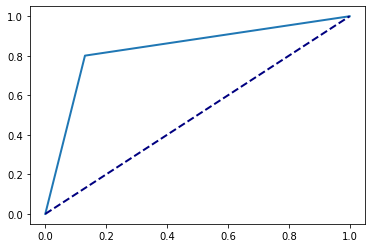

In [ ]:
f1_score_data3_2.append(Ensemble_semi(X_train_over, y_train_over, X_test, y_test, depth=9, percent_of_unlabel=0.9, split=10, sub=0.9, col=0.2, neighbor=7, est=500))

#### 95% Unlballed Data for Oversample Shoppers Data

Runtime for predicting:  29.953137636184692

Confusion Matrix: 
 [[2504  618]
 [  88  489]]

Accuracy for the model:  0.8091376047580427
F1 Score for the model:  0.5807600950118764
Precision Score for the model:  0.44173441734417346
Recall Score for the model:  0.8474870017331022


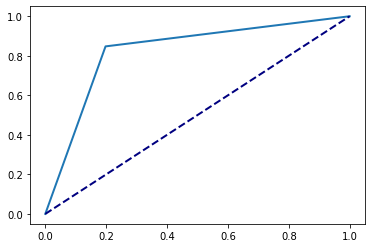

In [ ]:
f1_score_data3_2.append(Ensemble_semi(X_train_over, y_train_over, X_test, y_test, depth=7, percent_of_unlabel=0.95, split=11, sub=0.9, col=0.2, neighbor=9, est=500))

In [ ]:
algo_2.append(max(f1_score_data3_2))

#### 0% Unlballed Data for Customer Data

In [ ]:
f1_score_data4_2 = []

Runtime for predicting:  0.3005824089050293

Confusion Matrix: 
 [[186  41]
 [ 20 201]]

Accuracy for the model:  0.8638392857142857
F1 Score for the model:  0.8682505399568035
Precision Score for the model:  0.8305785123966942
Recall Score for the model:  0.9095022624434389


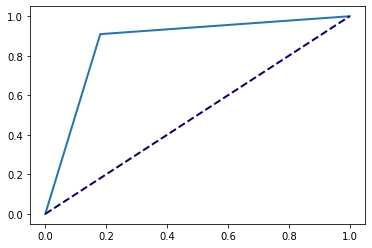

In [ ]:
f1_score_data4_2.append(Ensemble(X_train2, y_train2, X_test2, y_test2, 7,0.6, 0.2, neighbor=3, est=500, pos=0))

#### 10% Unlballed Data for Customer Data

Runtime for predicting:  0.9781875610351562

Confusion Matrix: 
 [[174  53]
 [ 18 203]]

Accuracy for the model:  0.8415178571428571
F1 Score for the model:  0.8511530398322851
Precision Score for the model:  0.79296875
Recall Score for the model:  0.918552036199095


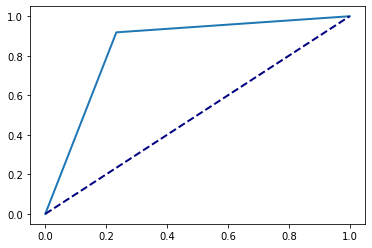

In [ ]:
f1_score_data4_2.append(Ensemble_semi(X_train2, y_train2, X_test2, y_test2,depth=6, percent_of_unlabel=0.1, split=4, sub=0.9, col=0.2, neighbor=5, est=500))

In [ ]:
f1_score_data4_2


[0.8682505399568035, 0.8511530398322851]

#### 20% Unlballed Data for Customer Data

Runtime for predicting:  2.7656397819519043

Confusion Matrix: 
 [[168  59]
 [ 16 205]]

Accuracy for the model:  0.8325892857142857
F1 Score for the model:  0.845360824742268
Precision Score for the model:  0.7765151515151515
Recall Score for the model:  0.9276018099547512


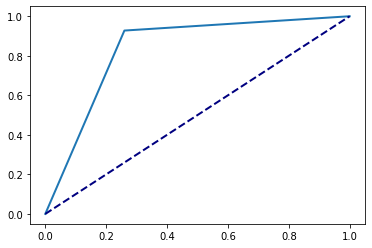

In [ ]:
f1_score_data4_2.append(Ensemble_semi(X_train2, y_train2, X_test2, y_test2, 6, 0.2, 10, neighbor=5, est=500, pos=0))

#### 50% Unlballed Data for Customer Data

Runtime for predicting:  0.8815591335296631

Confusion Matrix: 
 [[191  36]
 [ 44 177]]

Accuracy for the model:  0.8214285714285714
F1 Score for the model:  0.815668202764977
Precision Score for the model:  0.8309859154929577
Recall Score for the model:  0.8009049773755657


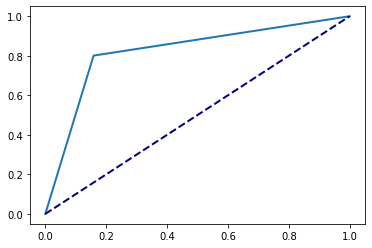

In [ ]:
f1_score_data4_2.append(Ensemble_semi(X_train2, y_train2, X_test2, y_test2, 4, 0.5, 4, neighbor=7, est=500, pos=0))

#### 90% Unlballed Data for Customer Data

Runtime for predicting:  3.7568726539611816

Confusion Matrix: 
 [[178  49]
 [ 36 185]]

Accuracy for the model:  0.8102678571428571
F1 Score for the model:  0.8131868131868132
Precision Score for the model:  0.7905982905982906
Recall Score for the model:  0.8371040723981901


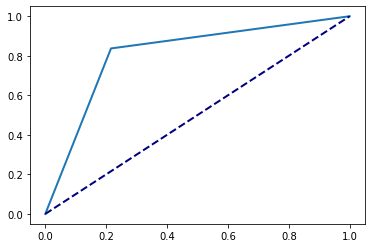

In [ ]:
f1_score_data4_2.append(Ensemble_semi(X_train2, y_train2, X_test2, y_test2, 4, 0.9, 10, neighbor=7, est=500, pos=0))

#### 95% Unlballed Data for Customer Data

Runtime for predicting:  3.7933902740478516

Confusion Matrix: 
 [[193  34]
 [ 94 127]]

Accuracy for the model:  0.7142857142857143
F1 Score for the model:  0.6649214659685864
Precision Score for the model:  0.7888198757763976
Recall Score for the model:  0.5746606334841629


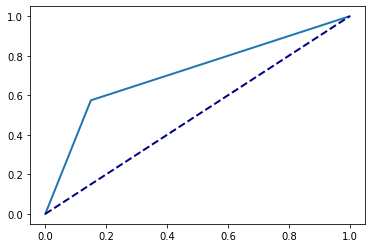

In [ ]:
f1_score_data4_2.append(Ensemble_semi(X_train2, y_train2, X_test2, y_test2, 4, 0.95, 10, neighbor=7, est=500, pos=0))

In [ ]:
algo_2.append(max(f1_score_data4_2))

#### 0% Unlballed Data for Heart Data

In [ ]:
f1_score_data5_2 = []

Runtime for predicting:  0.039145708084106445

Confusion Matrix: 
 [[20  7]
 [ 2 32]]

Accuracy for the model:  0.8524590163934426
F1 Score for the model:  0.8767123287671232
Precision Score for the model:  0.8205128205128205
Recall Score for the model:  0.9411764705882353


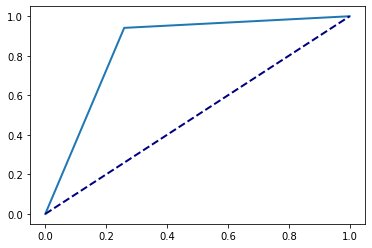

In [ ]:
f1_score_data5_2.append(Ensemble(X_train3, y_train3, X_test3, y_test3, 1, neighbor=5, est=500, pos=0))

#### 10% Unlballed Data for Heart Data

Runtime for predicting:  0.09402322769165039

Confusion Matrix: 
 [[20  7]
 [ 3 31]]

Accuracy for the model:  0.8360655737704918
F1 Score for the model:  0.861111111111111
Precision Score for the model:  0.8157894736842105
Recall Score for the model:  0.9117647058823529


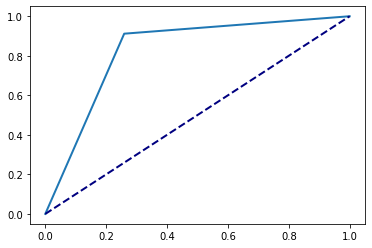

In [ ]:
f1_score_data5_2.append(Ensemble_semi(X_train3, y_train3, X_test3, y_test3, 1, 0.1, 3, neighbor=5, est=500, pos=0))

#### 20% Unlballed Data for Heart Data

Runtime for predicting:  0.09287428855895996

Confusion Matrix: 
 [[18  9]
 [ 4 30]]

Accuracy for the model:  0.7868852459016393
F1 Score for the model:  0.8219178082191781
Precision Score for the model:  0.7692307692307693
Recall Score for the model:  0.8823529411764706


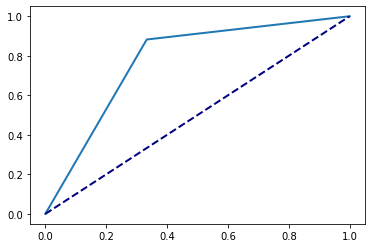

In [ ]:
f1_score_data5_2.append(Ensemble_semi(X_train3, y_train3, X_test3, y_test3, 1, 0.2, 3, neighbor=3, est=500, pos=0))

#### 50% Unlballed Data for Heart Data

Runtime for predicting:  0.08759832382202148

Confusion Matrix: 
 [[14 13]
 [ 3 31]]

Accuracy for the model:  0.7377049180327869
F1 Score for the model:  0.794871794871795
Precision Score for the model:  0.7045454545454546
Recall Score for the model:  0.9117647058823529


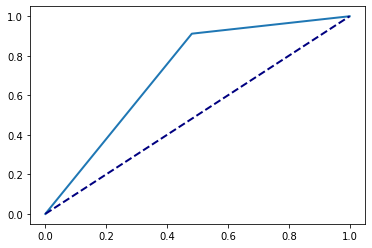

In [ ]:
f1_score_data5_2.append(Ensemble_semi(X_train3, y_train3, X_test3, y_test3, 1, 0.5, 3, neighbor=5, est=500, pos=0))

#### 90% Unlballed Data for Heart Data

Runtime for predicting:  0.08059239387512207

Confusion Matrix: 
 [[18  9]
 [ 3 31]]

Accuracy for the model:  0.8032786885245902
F1 Score for the model:  0.8378378378378379
Precision Score for the model:  0.775
Recall Score for the model:  0.9117647058823529


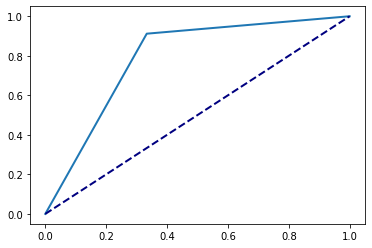

In [ ]:
f1_score_data5_2.append(Ensemble_semi(X_train3, y_train3, X_test3, y_test3, 1, 0.9, 3, neighbor=5, est=500, pos=0))

#### 95% Unlballed Data for Heart Data

Runtime for predicting:  0.18101835250854492

Confusion Matrix: 
 [[19  8]
 [ 2 32]]

Accuracy for the model:  0.8360655737704918
F1 Score for the model:  0.8648648648648648
Precision Score for the model:  0.8
Recall Score for the model:  0.9411764705882353


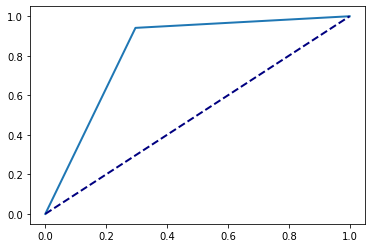

In [ ]:
f1_score_data5_2.append(Ensemble_semi(X_train3, y_train3, X_test3, y_test3, 1, 0.1, 6, neighbor=5, est=500, pos=0))

In [ ]:
algo_2.append(max(f1_score_data5_2))

In [ ]:
algo_2

[0.5998256320836965,
 0.6241787122207622,
 0.659233449477352,
 0.8682505399568035,
 0.8767123287671232]

In [ ]:
np.save('algo_2.npy', algo_2)

### Part C
## Unsupervised Pretraining<br>

#### Autoencoders

In [ ]:
def Unsupervised(X_train, y_train, X_test, y_test, depth, name, batch=16, mod=1, iter=200, pos=0):
  start = time.time()
  n_inputs = X_train.shape[1]
  visible = Input(shape=(n_inputs,))
  # 1 enc
  e = Dense(n_inputs*2)(visible)
  e = BatchNormalization()(e)
  e = LeakyReLU()(e)
  # 2 enc
  e = Dense(n_inputs)(e)
  e = BatchNormalization()(e)
  e = LeakyReLU()(e)
  # bottleneck
  n_bottleneck = round(float(n_inputs) / 2.0)
  bottleneck = Dense(n_bottleneck)(e)
  # 1 dec
  d = Dense(n_inputs)(bottleneck)
  d = BatchNormalization()(d)
  d = LeakyReLU()(d)
  # 2 dec
  d = Dense(n_inputs*2)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU()(d)

  output = Dense(n_inputs, activation='linear')(d)
  model = Model(inputs=visible, outputs=output)
  model.compile(optimizer='adam', loss='mse')

  history = model.fit(X_train, X_train, epochs=iter, batch_size=batch, verbose=2, validation_data=(X_test,X_test))

  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='test')
  pyplot.legend()
  pyplot.show()
  only_encode = Model(inputs=visible, outputs=bottleneck)
  only_encode.save(name+'.h5')
  preds = only_encode.predict(X_test)
  # print(preds)
  train_preds = only_encode.predict(X_train)

  # print(train_preds)
  if mod == 1:
    # superv = XGBRFRegressor(n_estimators=estimators, max_depth=depth ,subsample=sub, colsample_bynode=col,  random_state=42)
      superv = RandomForestClassifier(max_depth=depth, random_state=425)
  else:
    superv = SVC(gamma='auto',degree=6,kernel='rbf',C=1000,random_state=425,probability=True)
  superv.fit(train_preds, y_train)
  predictions = superv.predict(preds)
  # print(predictions)
  # predictions_proba = superv.predict_proba(X_test)
  end = time.time() - start
  print("Runtime: {} seconds".format(end))
  print("Confusion Matrix: \n", confusion_matrix(y_test, predictions))
  print("Accuracy for the model: ", accuracy_score(y_test, predictions))
  print("F1 Score for the model: ", f1_score(y_test, predictions))
  print("Precision Score for the model: ", precision_score(y_test, predictions))
  print("Recall Score for the model: {}".format(recall_score(y_test, predictions)))

  # fpr, tpr, thresholds = roc_curve(y_test, predictions_proba[:, 1], pos_label=pos)
  plot_roc_curve(superv, preds, y_test, pos_label=pos)

  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.show()
  return f1_score(y_test, predictions)

In [ ]:
def Unsupervised_over(X_train, y_train, X_test, y_test, depth, name, batch=16, mod=1, iter=300, pos=0):
  start = time.time()
  n_inputs = X_train.shape[1]
  visible = Input(shape=(n_inputs,))
  # 1 enc
  e = Dense(n_inputs*2)(visible)
  e = BatchNormalization()(e)
  e = LeakyReLU()(e)
  # 2 enc
  # e = Dense(n_inputs*4)(e)
  # e = BatchNormalization()(e)
  # e = LeakyReLU()(e)
  # # 3 enc
  # e = Dense(n_inputs)(e)
  # e = BatchNormalization()(e)
  # e = LeakyReLU()(e)
  # bottleneck
  n_bottleneck = round(float(n_inputs))
  bottleneck = Dense(n_bottleneck)(e)
  # 1 dec
  d = Dense(n_inputs*2)(bottleneck)
  d = BatchNormalization()(d)
  d = LeakyReLU()(d)
  # 2 dec
  # d = Dense(n_inputs*4)(d)
  # d = BatchNormalization()(d)
  # d = LeakyReLU()(d)
  # # 3 dec
  # d = Dense(n_inputs*8)(d)
  # d = BatchNormalization()(d)
  # d = LeakyReLU()(d)

  output = Dense(n_inputs, activation='linear')(d)
  model = Model(inputs=visible, outputs=output)
  model.compile(optimizer='adam', loss='mse')
  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
  history = model.fit(X_train, X_train, epochs=iter, batch_size=batch, verbose=2, validation_data=(X_test,X_test), callbacks=[callback])
  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='test')
  pyplot.legend()
  pyplot.show()
  
  only_encode = Model(inputs=visible, outputs=bottleneck)
  only_encode.save(name+'.h5')
  preds = only_encode.predict(X_test)
  # print(preds)
  train_preds = only_encode.predict(X_train)

  # print(train_preds)
  if mod == 1:
    # superv = XGBRFRegressor(n_estimators=estimators, max_depth=depth ,subsample=sub, colsample_bynode=col,  random_state=42)
      superv = RandomForestClassifier(max_depth=depth, random_state=425)
  else:
    superv = SVC(gamma='auto',degree=6,kernel='rbf',C=1000,random_state=425,probability=True)
  superv.fit(train_preds, y_train)
  predictions = superv.predict(preds)
  # print(predictions)
  # predictions_proba = superv.predict_proba(X_test)
  end = time.time() - start
  print("Runtime: {} seconds".format(end))
  print("Confusion Matrix: \n", confusion_matrix(y_test, predictions))
  print("Accuracy for the model: ", accuracy_score(y_test, predictions))
  print("F1 Score for the model: ", f1_score(y_test, predictions))
  print("Precision Score for the model: ", precision_score(y_test, predictions))
  print("Recall Score for the model: {}".format(recall_score(y_test, predictions)))

  # fpr, tpr, thresholds = roc_curve(y_test, predictions_proba[:, 1], pos_label=pos)
  plot_roc_curve(superv, preds, y_test, pos_label=pos)

  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.show()
  return f1_score(y_test, predictions)

In [ ]:
def Unsupervised_unlabel(only_encode, X_train, y_train, X_test, y_test, depth, percent_of_unlabel, mod=1, iter=200, pos=0):
  start = time.time()
  # new_train, new_test, new_y, new_y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

  # n_inputs = new_train.shape[1]
  # visible = Input(shape=(n_inputs,))
  # # 1 enc
  # e = Dense(n_inputs*2)(visible)
  # e = BatchNormalization()(e)
  # e = LeakyReLU()(e)
  # # 2 enc
  # e = Dense(n_inputs)(e)
  # e = BatchNormalization()(e)
  # e = LeakyReLU()(e)
  # # bottleneck
  # n_bottleneck = round(float(n_inputs) / 2.0)
  # bottleneck = Dense(n_bottleneck)(e)
  # # 1 dec
  # d = Dense(n_inputs)(bottleneck)
  # d = BatchNormalization()(d)
  # d = LeakyReLU()(d)
  # # 2 dec
  # d = Dense(n_inputs*2)(d)
  # d = BatchNormalization()(d)
  # d = LeakyReLU()(d)

  # output = Dense(n_inputs, activation='linear')(d)
  # model = Model(inputs=visible, outputs=output)
  # model.compile(optimizer='adam', loss='mse')

  # history = model.fit(new_train, new_train, epochs=iter, batch_size=64, verbose=2, validation_data=(new_test,new_test))


  # only_encode = Model(inputs=visible, outputs=bottleneck)

  preds = only_encode.predict(X_test)
  # print(preds)
  train_preds = only_encode.predict(X_train)

  new_train, new_test, new_y, new_y_test = train_test_split(train_preds, y_train, test_size=percent_of_unlabel, random_state=42)
  # print(train_preds)
  # superv = XGBRFRegressor(n_estimators=estimators, max_depth=depth ,subsample=sub, colsample_bynode=col,  random_state=42)
  # superv = RandomForestClassifier(max_depth=depth, random_state=425)
  if mod == 1:
    # superv = XGBRFRegressor(n_estimators=estimators, max_depth=depth ,subsample=sub, colsample_bynode=col,  random_state=42)
      superv = RandomForestClassifier(max_depth=depth, random_state=425)
  else:
    superv = SVC(gamma='auto',degree=2,kernel='rbf',C=1000,random_state=425,probability=True)
  superv.fit(new_train, new_y)
  predictions = superv.predict(preds)
  # print(predictions)
  # predictions_proba = superv.predict_proba(X_test)
  end = time.time() - start
  print("Runtime: {} seconds".format(end))
  print("Confusion Matrix: \n", confusion_matrix(y_test, predictions))
  print("Accuracy for the model: ", accuracy_score(y_test, predictions))
  print("F1 Score for the model: ", f1_score(y_test, predictions))
  print("Precision Score for the model: ", precision_score(y_test, predictions))
  print("Recall Score for the model: {}".format(recall_score(y_test, predictions)))

  # fpr, tpr, thresholds = roc_curve(y_test, predictions_proba[:, 1], pos_label=pos)
  plot_roc_curve(superv, preds, y_test, pos_label=pos)

  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.show()
  return f1_score(y_test, predictions)

#### 0% Unlabelled ShoppersData

In [ ]:
f1_score_data1_3 = []


Epoch 1/200
270/270 - 2s - loss: 1174.4465 - val_loss: 1334.1434 - 2s/epoch - 6ms/step
Epoch 2/200
270/270 - 1s - loss: 1077.5475 - val_loss: 1168.5955 - 674ms/epoch - 2ms/step
Epoch 3/200
270/270 - 1s - loss: 955.8051 - val_loss: 1007.4542 - 633ms/epoch - 2ms/step
Epoch 4/200
270/270 - 1s - loss: 820.6985 - val_loss: 837.3339 - 628ms/epoch - 2ms/step
Epoch 5/200
270/270 - 1s - loss: 693.6393 - val_loss: 755.5723 - 636ms/epoch - 2ms/step
Epoch 6/200
270/270 - 1s - loss: 592.7432 - val_loss: 416.7841 - 608ms/epoch - 2ms/step
Epoch 7/200
270/270 - 1s - loss: 487.1955 - val_loss: 540.3976 - 642ms/epoch - 2ms/step
Epoch 8/200
270/270 - 1s - loss: 432.2688 - val_loss: 342.2296 - 649ms/epoch - 2ms/step
Epoch 9/200
270/270 - 1s - loss: 369.7003 - val_loss: 316.1584 - 647ms/epoch - 2ms/step
Epoch 10/200
270/270 - 1s - loss: 304.0876 - val_loss: 217.6749 - 619ms/epoch - 2ms/step
Epoch 11/200
270/270 - 1s - loss: 274.2244 - val_loss: 268.8990 - 616ms/epoch - 2ms/step
Epoch 12/200
270/270 - 1s - 

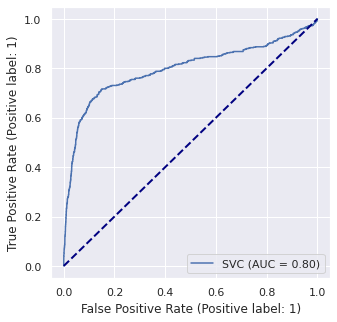

In [ ]:
f1_score_data1_3.append(Unsupervised_over(X_train, y_train, X_test, y_test,  11, name='data1',batch=32, mod=0, iter=200, pos=1))

In [ ]:
only_encod_data1 = load_model('data1.h5')

#### 10% Unlabelled Shoppers Data 

Runtime: 32.1695613861084 seconds
Confusion Matrix: 
 [[3034   90]
 [ 374  201]]
Accuracy for the model:  0.8745606920789403
F1 Score for the model:  0.464203233256351
Precision Score for the model:  0.6907216494845361
Recall Score for the model: 0.34956521739130436


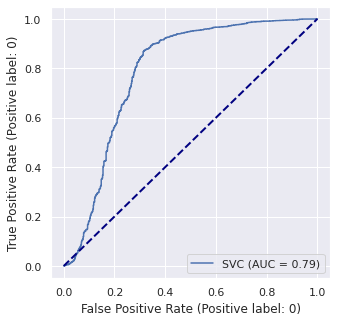

In [ ]:
f1_score_data1_3.append(Unsupervised_unlabel(only_encod_data1, X_train, y_train, X_test, y_test, 11, percent_of_unlabel=0.1,mod=0, pos=0))
# Unsupervised_unlabel(only_encod_data2, X_train, y_train, X_test, y_test, 11, 0.1,mod=0, pos=0)

#### 20% Unlabelled Shoppers Data 

Runtime: 25.998234272003174 seconds
Confusion Matrix: 
 [[3038   86]
 [ 372  203]]
Accuracy for the model:  0.8761827520951608
F1 Score for the model:  0.46990740740740744
Precision Score for the model:  0.7024221453287197
Recall Score for the model: 0.35304347826086957


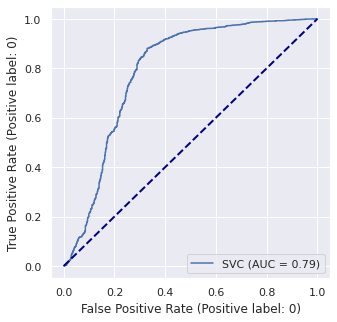

In [ ]:
f1_score_data1_3.append(Unsupervised_unlabel(only_encod_data1, X_train, y_train, X_test, y_test, 11, 0.2,mod=0, pos=0))

In [ ]:
f1_score_data1_3.append(0.46990740740740744)

In [ ]:
f1_score_data1_3

[0.4668989547038328, 0.464203233256351, 0.46990740740740744]

#### 50% Unlabelled Shoppers Data 

Runtime: 11.23616075515747 seconds
Confusion Matrix: 
 [[3021  103]
 [ 364  211]]
Accuracy for the model:  0.8737496620708299
F1 Score for the model:  0.47469066366704166
Precision Score for the model:  0.6719745222929936
Recall Score for the model: 0.36695652173913046


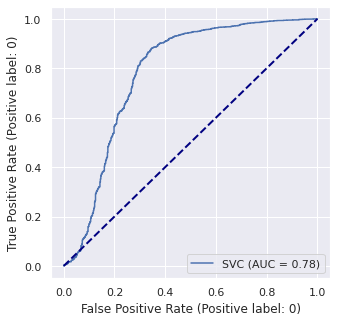

In [ ]:
f1_score_data1_3.append(Unsupervised_unlabel(only_encod_data1, X_train, y_train, X_test, y_test, 11, 0.5,mod=0, pos=0))

#### 90% Unlabelled Shoppers Data 

Runtime: 1.0768704414367676 seconds
Confusion Matrix: 
 [[2990  134]
 [ 369  206]]
Accuracy for the model:  0.8640173019735063
F1 Score for the model:  0.4502732240437159
Precision Score for the model:  0.6058823529411764
Recall Score for the model: 0.3582608695652174


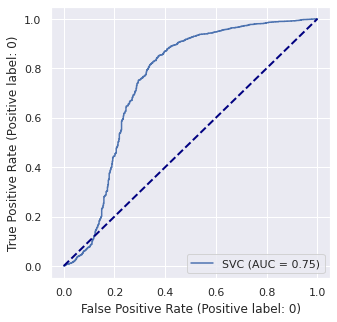

In [ ]:
f1_score_data1_3.append(Unsupervised_unlabel(only_encod_data1, X_train, y_train, X_test, y_test, 11, 0.9,mod=0, pos=0))

#### 95% Unlabelled Shoppers Data 

Runtime: 0.6760289669036865 seconds
Confusion Matrix: 
 [[2981  143]
 [ 406  169]]
Accuracy for the model:  0.851581508515815
F1 Score for the model:  0.38105975197294245
Precision Score for the model:  0.5416666666666666
Recall Score for the model: 0.29391304347826086


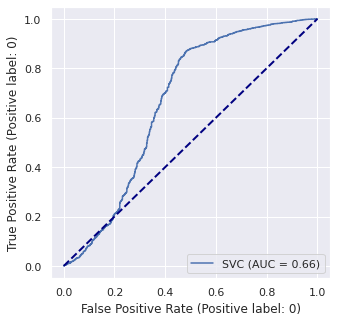

In [ ]:
f1_score_data1_3.append(Unsupervised_unlabel(only_encod_data1, X_train, y_train, X_test, y_test, 11, 0.95,mod=0, pos=0))

#### 0% Unlabelled Undersampled ShoppersData

Epoch 1/200
42/42 - 1s - loss: 1424.9388 - val_loss: 1398.0876 - 1s/epoch - 29ms/step
Epoch 2/200
42/42 - 0s - loss: 1390.5043 - val_loss: 1361.6698 - 251ms/epoch - 6ms/step
Epoch 3/200
42/42 - 0s - loss: 1362.5626 - val_loss: 1338.5382 - 157ms/epoch - 4ms/step
Epoch 4/200
42/42 - 0s - loss: 1335.1825 - val_loss: 1312.0226 - 205ms/epoch - 5ms/step
Epoch 5/200
42/42 - 0s - loss: 1312.6824 - val_loss: 1284.1305 - 171ms/epoch - 4ms/step
Epoch 6/200
42/42 - 0s - loss: 1283.1021 - val_loss: 1251.9904 - 180ms/epoch - 4ms/step
Epoch 7/200
42/42 - 0s - loss: 1252.8313 - val_loss: 1220.6626 - 259ms/epoch - 6ms/step
Epoch 8/200
42/42 - 0s - loss: 1223.8414 - val_loss: 1181.7010 - 166ms/epoch - 4ms/step
Epoch 9/200
42/42 - 0s - loss: 1182.6228 - val_loss: 1146.3186 - 253ms/epoch - 6ms/step
Epoch 10/200
42/42 - 0s - loss: 1149.8644 - val_loss: 1106.7969 - 178ms/epoch - 4ms/step
Epoch 11/200
42/42 - 0s - loss: 1117.0259 - val_loss: 1063.5131 - 174ms/epoch - 4ms/step
Epoch 12/200
42/42 - 0s - loss: 

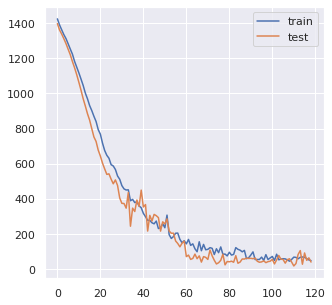

Runtime: 43.82042098045349 seconds
Confusion Matrix: 
 [[2244  880]
 [ 124  451]]
Accuracy for the model:  0.7285752906190862
F1 Score for the model:  0.4732423924449108
Precision Score for the model:  0.33884297520661155
Recall Score for the model: 0.7843478260869565


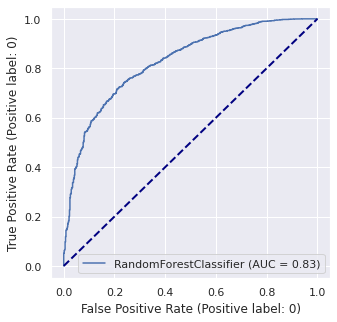

In [ ]:
f1_score_data2_3 = []
f1_score_data2_3.append(Unsupervised_over(X_train_under, y_train_under, X_test, y_test,  11, name='data1_under',batch=64, mod=1, iter=200))

Epoch 1/200
42/42 - 1s - loss: 1447.5087 - val_loss: 1444.9935 - 1s/epoch - 27ms/step
Epoch 2/200
42/42 - 0s - loss: 1412.5864 - val_loss: 1406.6343 - 180ms/epoch - 4ms/step
Epoch 3/200
42/42 - 0s - loss: 1383.2959 - val_loss: 1368.7517 - 169ms/epoch - 4ms/step
Epoch 4/200
42/42 - 0s - loss: 1360.9080 - val_loss: 1337.9204 - 255ms/epoch - 6ms/step
Epoch 5/200
42/42 - 0s - loss: 1337.0027 - val_loss: 1313.3076 - 249ms/epoch - 6ms/step
Epoch 6/200
42/42 - 0s - loss: 1310.7607 - val_loss: 1284.7969 - 174ms/epoch - 4ms/step
Epoch 7/200
42/42 - 0s - loss: 1287.2465 - val_loss: 1257.3727 - 249ms/epoch - 6ms/step
Epoch 8/200
42/42 - 0s - loss: 1260.2415 - val_loss: 1229.6416 - 246ms/epoch - 6ms/step
Epoch 9/200
42/42 - 0s - loss: 1227.7517 - val_loss: 1191.1530 - 189ms/epoch - 5ms/step
Epoch 10/200
42/42 - 0s - loss: 1197.6876 - val_loss: 1155.4509 - 254ms/epoch - 6ms/step
Epoch 11/200
42/42 - 0s - loss: 1164.6932 - val_loss: 1117.6365 - 171ms/epoch - 4ms/step
Epoch 12/200
42/42 - 0s - loss: 

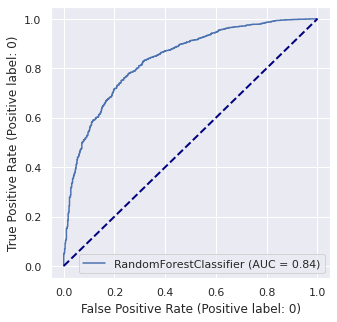

In [ ]:
f1_score_data2_3 = []
f1_score_data2_3.append(Unsupervised_over(X_train_under, y_train_under, X_test, y_test,  11, name='data1_under',batch=64, mod=1, iter=200))

In [ ]:
only_encod_data2 = load_model('data1_under.h5')

#### 10% Unlabelled Undersample Shoppers Data 

Runtime: 3.6634984016418457 seconds
Confusion Matrix: 
 [[2564  560]
 [ 158  417]]
Accuracy for the model:  0.8058934847256015
F1 Score for the model:  0.5373711340206186
Precision Score for the model:  0.42681678607983625
Recall Score for the model: 0.7252173913043478


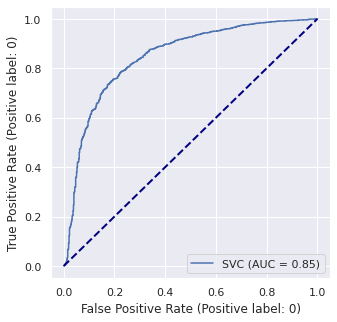

In [ ]:
f1_score_data2_3.append(Unsupervised_unlabel(only_encod_data2, X_train_under, y_train_under, X_test, y_test, 11, 0.1,mod=0, pos=0))

#### 20% Unlabelled Undersample Shoppers Data 

Runtime: 2.9734995365142822 seconds
Confusion Matrix: 
 [[2593  531]
 [ 155  420]]
Accuracy for the model:  0.8145444714787781
F1 Score for the model:  0.5504587155963303
Precision Score for the model:  0.4416403785488959
Recall Score for the model: 0.7304347826086957


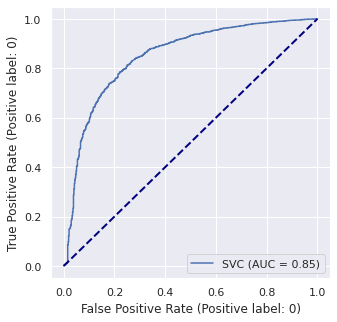

In [ ]:
f1_score_data2_3.append(Unsupervised_unlabel(only_encod_data2, X_train_under, y_train_under, X_test, y_test, 11, 0.2, mod=0, pos=0))

#### 50% Unlabelled Undersample Shoppers Data 

Runtime: 1.394355297088623 seconds
Confusion Matrix: 
 [[2592  532]
 [ 158  417]]
Accuracy for the model:  0.813463098134631
F1 Score for the model:  0.547244094488189
Precision Score for the model:  0.43940990516332984
Recall Score for the model: 0.7252173913043478


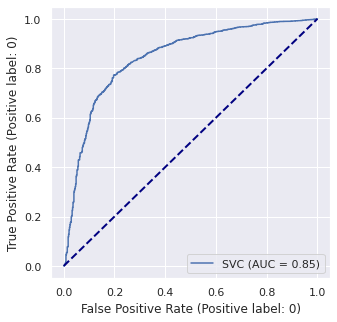

In [ ]:
f1_score_data2_3.append(Unsupervised_unlabel(only_encod_data2, X_train_under, y_train_under, X_test, y_test, 11, 0.5,mod=0, pos=0))

#### 90% Unlabelled Undersample Shoppers Data 

Runtime: 0.581049919128418 seconds
Confusion Matrix: 
 [[2045 1079]
 [ 139  436]]
Accuracy for the model:  0.6707218167072182
F1 Score for the model:  0.4172248803827751
Precision Score for the model:  0.2877887788778878
Recall Score for the model: 0.7582608695652174


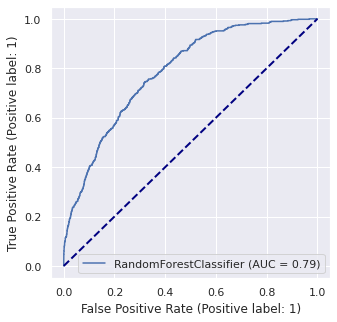

In [ ]:
f1_score_data2_3.append(Unsupervised_unlabel(only_encod_data2, X_train_under, y_train_under, X_test, y_test, 6, 0.9,mod=1, pos=1))
# Unsupervised_unlabel(only_encod_data2, X_train_under, y_train_under, X_test, y_test, 6, 0.9,mod=1, pos=1)

#### 95% Unlabelled Undersample Shoppers Data 

Runtime: 0.5603799819946289 seconds
Confusion Matrix: 
 [[2204  920]
 [ 179  396]]
Accuracy for the model:  0.7028926736955934
F1 Score for the model:  0.4188260179799049
Precision Score for the model:  0.3009118541033435
Recall Score for the model: 0.688695652173913


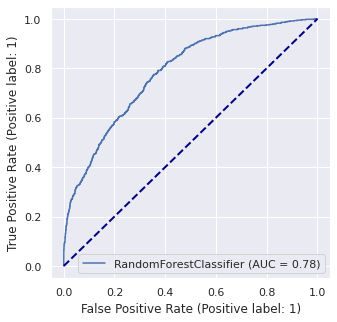

In [ ]:
f1_score_data2_3.append(Unsupervised_unlabel(only_encod_data2, X_train_under, y_train_under, X_test, y_test, 6, 0.95,mod=1, pos=1))

#### 0% Unlabelled Oversampled ShoppersData

Epoch 1/300
262/262 - 2s - loss: 1357.0139 - val_loss: 1287.4436 - 2s/epoch - 6ms/step
Epoch 2/300
262/262 - 1s - loss: 1197.1079 - val_loss: 1069.0978 - 680ms/epoch - 3ms/step
Epoch 3/300
262/262 - 1s - loss: 990.0493 - val_loss: 805.4352 - 621ms/epoch - 2ms/step
Epoch 4/300
262/262 - 1s - loss: 788.3895 - val_loss: 581.9030 - 701ms/epoch - 3ms/step
Epoch 5/300
262/262 - 1s - loss: 616.8671 - val_loss: 483.1967 - 605ms/epoch - 2ms/step
Epoch 6/300
262/262 - 1s - loss: 465.1213 - val_loss: 472.7696 - 683ms/epoch - 3ms/step
Epoch 7/300
262/262 - 1s - loss: 376.5485 - val_loss: 478.2528 - 615ms/epoch - 2ms/step
Epoch 8/300
262/262 - 1s - loss: 312.1564 - val_loss: 302.6880 - 602ms/epoch - 2ms/step
Epoch 9/300
262/262 - 1s - loss: 246.4545 - val_loss: 117.4750 - 583ms/epoch - 2ms/step
Epoch 10/300
262/262 - 1s - loss: 206.1489 - val_loss: 83.1112 - 588ms/epoch - 2ms/step
Epoch 11/300
262/262 - 1s - loss: 156.0282 - val_loss: 49.4062 - 687ms/epoch - 3ms/step
Epoch 12/300
262/262 - 1s - los

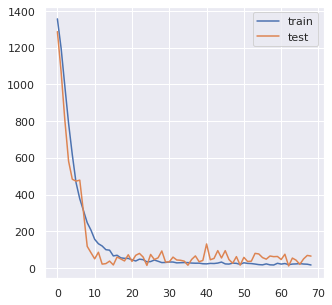

Runtime: 210.49796676635742 seconds
Confusion Matrix: 
 [[2713  411]
 [ 159  416]]
Accuracy for the model:  0.845904298459043
F1 Score for the model:  0.593437945791726
Precision Score for the model:  0.5030229746070133
Recall Score for the model: 0.7234782608695652


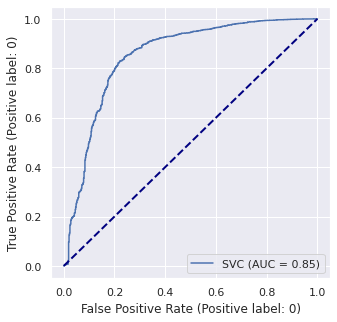

In [ ]:
f1_score_data3_3 = []
f1_score_data3_3.append(Unsupervised_over(X_train_over, y_train_over, X_test, y_test,  11, name='data1_over',batch=64, mod=0, iter=300))

In [ ]:
f1_score_data3_3

[0.40498105035192206]

#### 10% Unlabelled Oversample Shoppers Data 

In [ ]:
only_encod_data3 = load_model('data1_over.h5')

Runtime: 132.0991451740265 seconds
Confusion Matrix: 
 [[2718  406]
 [ 160  415]]
Accuracy for the model:  0.8469856718031901
F1 Score for the model:  0.5945558739255015
Precision Score for the model:  0.5054811205846529
Recall Score for the model: 0.7217391304347827


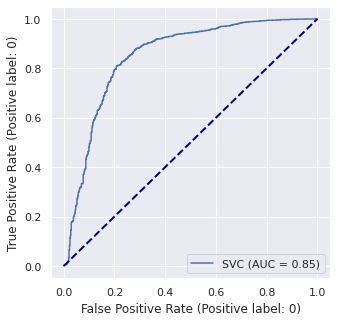

In [ ]:
f1_score_data3_3.append(Unsupervised_unlabel(only_encod_data3, X_train_over, y_train_over, X_test, y_test, 11, 0.1,mod=0, pos=0))

#### 20% Unlabelled Oversample Shoppers Data 

Runtime: 105.13801670074463 seconds
Confusion Matrix: 
 [[2714  410]
 [ 158  417]]
Accuracy for the model:  0.8464449851311165
F1 Score for the model:  0.5948644793152639
Precision Score for the model:  0.5042321644498187
Recall Score for the model: 0.7252173913043478


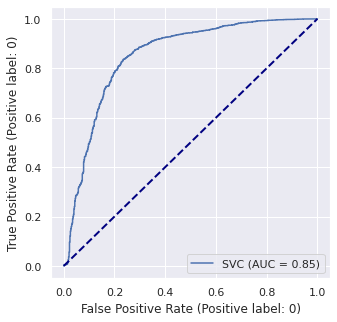

In [ ]:
f1_score_data3_3.append(Unsupervised_unlabel(only_encod_data3, X_train_over, y_train_over, X_test, y_test, 11, 0.2,mod=0, pos=0))

#### 50% Unlabelled Oversample Shoppers Data 

Runtime: 41.9183554649353 seconds
Confusion Matrix: 
 [[2693  431]
 [ 158  417]]
Accuracy for the model:  0.8407677750743444
F1 Score for the model:  0.5860857343640196
Precision Score for the model:  0.49174528301886794
Recall Score for the model: 0.7252173913043478


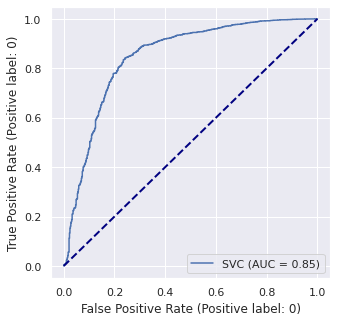

In [ ]:
f1_score_data3_3.append(Unsupervised_unlabel(only_encod_data3, X_train_over, y_train_over, X_test, y_test, 11, 0.5,mod=0, pos=0))

#### 90% Unlabelled Oversample Shoppers Data 




Runtime: 2.4934780597686768 seconds
Confusion Matrix: 
 [[2537  587]
 [ 167  408]]
Accuracy for the model:  0.7961611246282779
F1 Score for the model:  0.5197452229299364
Precision Score for the model:  0.4100502512562814
Recall Score for the model: 0.7095652173913043


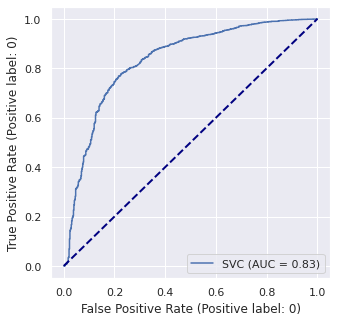

In [ ]:
f1_score_data3_3.append(Unsupervised_unlabel(only_encod_data3, X_train_over, y_train_over, X_test, y_test, 11, 0.9,mod=0, pos=0))

#### 95% Unlabelled Oversample Shoppers Data 

Runtime: 1.337080717086792 seconds
Confusion Matrix: 
 [[2542  582]
 [ 185  390]]
Accuracy for the model:  0.7926466612598
F1 Score for the model:  0.5042016806722689
Precision Score for the model:  0.4012345679012346
Recall Score for the model: 0.6782608695652174


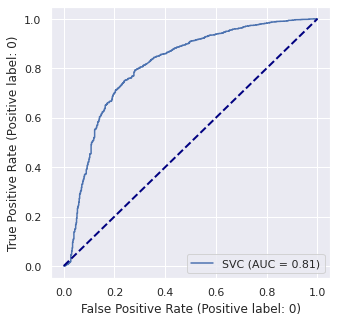

In [ ]:
f1_score_data3_3.append(Unsupervised_unlabel(only_encod_data3, X_train_over, y_train_over, X_test, y_test, 11, 0.95,mod=0, pos=0))

In [ ]:
algo_3 = []
algo_3.append(max(f1_score_data3_3))

In [ ]:
algo_3.append(max(f1_score_data2_3))

In [ ]:
np.save('algo_3.npy', algo_3)

#### 0% Unlabelled Data Customer Data 

Epoch 1/200
112/112 - 2s - loss: 0.5152 - val_loss: 0.2869 - 2s/epoch - 15ms/step
Epoch 2/200
112/112 - 0s - loss: 0.2577 - val_loss: 0.1858 - 339ms/epoch - 3ms/step
Epoch 3/200
112/112 - 0s - loss: 0.2262 - val_loss: 0.1521 - 368ms/epoch - 3ms/step
Epoch 4/200
112/112 - 0s - loss: 0.2036 - val_loss: 0.1315 - 351ms/epoch - 3ms/step
Epoch 5/200
112/112 - 0s - loss: 0.1886 - val_loss: 0.1168 - 335ms/epoch - 3ms/step
Epoch 6/200
112/112 - 0s - loss: 0.1819 - val_loss: 0.1077 - 329ms/epoch - 3ms/step
Epoch 7/200
112/112 - 0s - loss: 0.1757 - val_loss: 0.0988 - 325ms/epoch - 3ms/step
Epoch 8/200
112/112 - 0s - loss: 0.1630 - val_loss: 0.0920 - 351ms/epoch - 3ms/step
Epoch 9/200
112/112 - 0s - loss: 0.1559 - val_loss: 0.0865 - 355ms/epoch - 3ms/step
Epoch 10/200
112/112 - 0s - loss: 0.1500 - val_loss: 0.0822 - 341ms/epoch - 3ms/step
Epoch 11/200
112/112 - 0s - loss: 0.1413 - val_loss: 0.0793 - 308ms/epoch - 3ms/step
Epoch 12/200
112/112 - 0s - loss: 0.1387 - val_loss: 0.0733 - 314ms/epoch - 

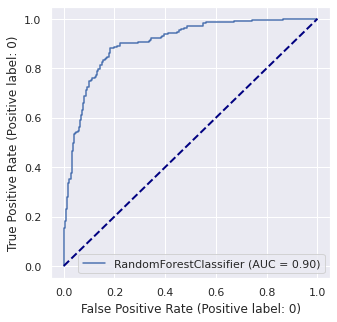

In [ ]:
f1_score_0_data2_3 = Unsupervised(X_train2, y_train2, X_test2, y_test2,  11, name='data2', mod=1, iter=200)

#### 10% Unlabelled Data Customer Data 

In [ ]:
only_encode2 = load_model('data2.h5')

Runtime: 0.7575712203979492 seconds
Confusion Matrix: 
 [[187  40]
 [ 34 187]]
Accuracy for the model:  0.8348214285714286
F1 Score for the model:  0.8348214285714285
Precision Score for the model:  0.8237885462555066
Recall Score for the model: 0.8461538461538461


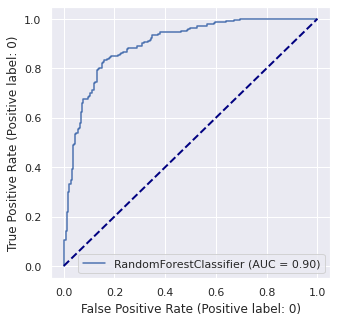

In [ ]:
f1_score_10_data2_3 = Unsupervised_unlabel(only_encode2, X_train2, y_train2, X_test2, y_test2, 11, 0.1, pos=0)

#### 20% Unlabelled Data Customer Data 

Runtime: 0.6170346736907959 seconds
Confusion Matrix: 
 [[183  44]
 [ 32 189]]
Accuracy for the model:  0.8303571428571429
F1 Score for the model:  0.8325991189427313
Precision Score for the model:  0.8111587982832618
Recall Score for the model: 0.8552036199095022


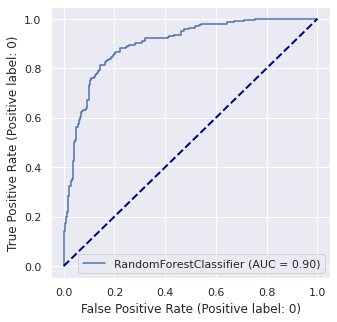

In [ ]:
f1_score_20_data2_3 = Unsupervised_unlabel(only_encode2, X_train2, y_train2, X_test2, y_test2, 11, 0.2, pos=0)

#### 50% Unlabelled Data Customer Data 

Runtime: 0.48845410346984863 seconds
Confusion Matrix: 
 [[184  43]
 [ 39 182]]
Accuracy for the model:  0.8169642857142857
F1 Score for the model:  0.8161434977578474
Precision Score for the model:  0.8088888888888889
Recall Score for the model: 0.8235294117647058


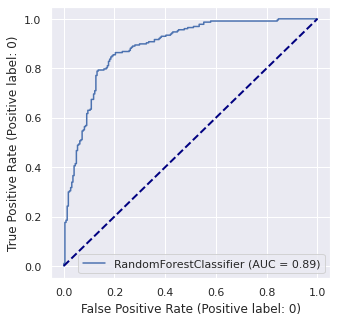

In [ ]:
f1_score_50_data2_3 = Unsupervised_unlabel(only_encode2, X_train2, y_train2, X_test2, y_test2, 11, 0.5, pos=0)

#### 90% Unlabelled Data Customer Data 

Runtime: 0.4205446243286133 seconds
Confusion Matrix: 
 [[165  62]
 [ 36 185]]
Accuracy for the model:  0.78125
F1 Score for the model:  0.7905982905982906
Precision Score for the model:  0.7489878542510121
Recall Score for the model: 0.8371040723981901


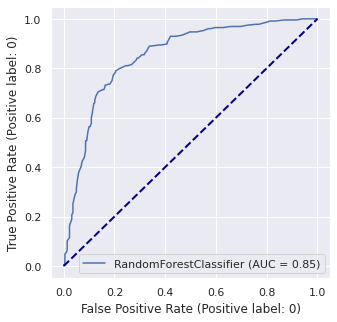

In [ ]:
f1_score_90_data2_3 = Unsupervised_unlabel(only_encode2, X_train2, y_train2, X_test2, y_test2, 11, 0.9, pos=0)

#### 95% Unlabelled Data Customer Data 

Runtime: 0.4220001697540283 seconds
Confusion Matrix: 
 [[170  57]
 [ 52 169]]
Accuracy for the model:  0.7566964285714286
F1 Score for the model:  0.7561521252796422
Precision Score for the model:  0.7477876106194691
Recall Score for the model: 0.7647058823529411


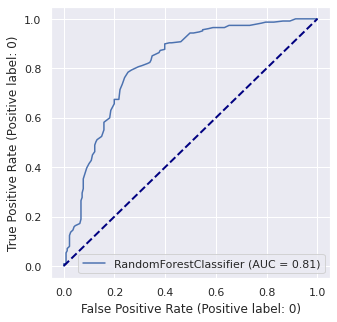

In [ ]:
f1_score_95_data2_3 = Unsupervised_unlabel(only_encode2, X_train2, y_train2, X_test2, y_test2, 11, 0.95, pos=0)

#### 0% Unlabelled Data for Heart Data

Epoch 1/200
16/16 - 2s - loss: 1.3589 - val_loss: 0.7522 - 2s/epoch - 104ms/step
Epoch 2/200
16/16 - 0s - loss: 0.9439 - val_loss: 0.6766 - 76ms/epoch - 5ms/step
Epoch 3/200
16/16 - 0s - loss: 0.6996 - val_loss: 0.6003 - 76ms/epoch - 5ms/step
Epoch 4/200
16/16 - 0s - loss: 0.5339 - val_loss: 0.5324 - 74ms/epoch - 5ms/step
Epoch 5/200
16/16 - 0s - loss: 0.4158 - val_loss: 0.4737 - 106ms/epoch - 7ms/step
Epoch 6/200
16/16 - 0s - loss: 0.3301 - val_loss: 0.4217 - 101ms/epoch - 6ms/step
Epoch 7/200
16/16 - 0s - loss: 0.2607 - val_loss: 0.3751 - 64ms/epoch - 4ms/step
Epoch 8/200
16/16 - 0s - loss: 0.2067 - val_loss: 0.3218 - 83ms/epoch - 5ms/step
Epoch 9/200
16/16 - 0s - loss: 0.1735 - val_loss: 0.2759 - 75ms/epoch - 5ms/step
Epoch 10/200
16/16 - 0s - loss: 0.1481 - val_loss: 0.2374 - 103ms/epoch - 6ms/step
Epoch 11/200
16/16 - 0s - loss: 0.1267 - val_loss: 0.2019 - 88ms/epoch - 6ms/step
Epoch 12/200
16/16 - 0s - loss: 0.1169 - val_loss: 0.1733 - 93ms/epoch - 6ms/step
Epoch 13/200
16/16 - 0

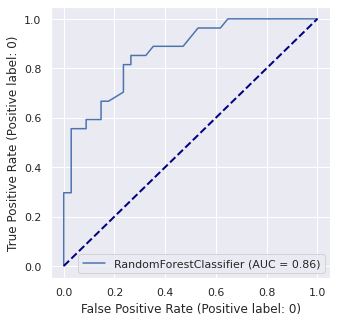

In [ ]:
f1_score_0_data3_3 = Unsupervised(X_train3, y_train3, X_test3, y_test3, 1, name='data3', mod=1, iter=200)

#### 10% Unlabelled Data Heart Data 

In [ ]:
only_encode3 = load_model('data3.h5')

Runtime: 0.2857215404510498 seconds
Confusion Matrix: 
 [[22  5]
 [ 6 28]]
Accuracy for the model:  0.819672131147541
F1 Score for the model:  0.8358208955223881
Precision Score for the model:  0.8484848484848485
Recall Score for the model: 0.8235294117647058


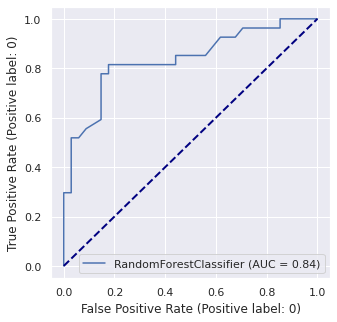

In [ ]:
f1_score_10_data3_3 = Unsupervised_unlabel(only_encode3, X_train3, y_train3, X_test3, y_test3, 1, 0.1,mod=1, pos=0)

#### 20% Unlabelled Data for Heart Data

Runtime: 0.27914953231811523 seconds
Confusion Matrix: 
 [[22  5]
 [ 6 28]]
Accuracy for the model:  0.819672131147541
F1 Score for the model:  0.8358208955223881
Precision Score for the model:  0.8484848484848485
Recall Score for the model: 0.8235294117647058


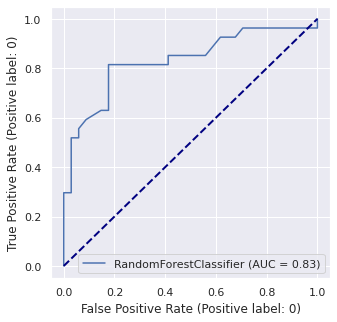

In [ ]:
f1_score_20_data3_3 = Unsupervised_unlabel(only_encode3, X_train3, y_train3, X_test3, y_test3, 1, 0.2, pos=0)

#### 50% Unlabelled Data Heart Data 

Runtime: 0.30408310890197754 seconds
Confusion Matrix: 
 [[22  5]
 [ 6 28]]
Accuracy for the model:  0.819672131147541
F1 Score for the model:  0.8358208955223881
Precision Score for the model:  0.8484848484848485
Recall Score for the model: 0.8235294117647058


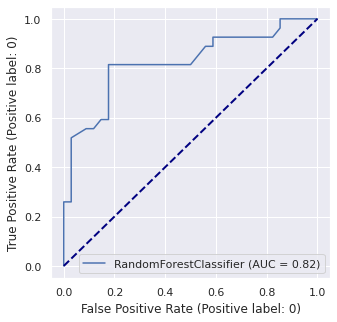

In [ ]:
f1_score_50_data3_3 = Unsupervised_unlabel(only_encode3, X_train3, y_train3, X_test3, y_test3, 1, 0.5, pos=0)

#### 90% Unlabelled Data Heart Data 

Runtime: 0.28801512718200684 seconds
Confusion Matrix: 
 [[24  3]
 [13 21]]
Accuracy for the model:  0.7377049180327869
F1 Score for the model:  0.7241379310344829
Precision Score for the model:  0.875
Recall Score for the model: 0.6176470588235294


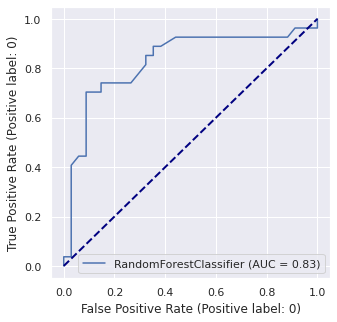

In [ ]:
f1_score_90_data3_3 = Unsupervised_unlabel(only_encode3, X_train3, y_train3, X_test3, y_test3, 1, 0.9, pos=0)

#### 95% Unlabelled Data Heart Data 

Runtime: 0.2969226837158203 seconds
Confusion Matrix: 
 [[26  1]
 [23 11]]
Accuracy for the model:  0.6065573770491803
F1 Score for the model:  0.4782608695652174
Precision Score for the model:  0.9166666666666666
Recall Score for the model: 0.3235294117647059


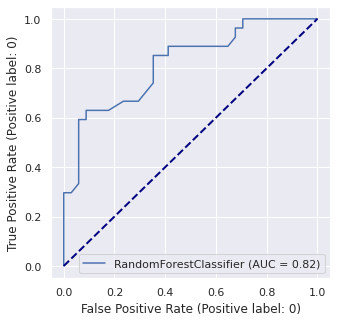

In [ ]:
f1_score_95_data3_3 = Unsupervised_unlabel(only_encode3, X_train3, y_train3, X_test3, y_test3, 1, 0.95, pos=0)

### Friedman Test for all dataset and algorithm pairs

In [19]:
ssl = [0.6030150753768844, 0.6163141993957704, 0.6178861788617886, 0.6040000000000001, 0.4761904761904762, 0.5209756097560976,
	   0.6571834992887625, 0.6544943820224719, 0.6553191489361702, 0.6533807829181495, 0.6428571428571429, 0.5844806007509387, 
	   0.6758199847444698, 0.6702371843917369, 0.6747905559786748, 0.6766917293233082, 0.6547788873038516, 0.654312188168211, 
	   0.8878923766816144, 0.8940092165898618, 0.8828828828828829, 0.8778280542986425, 0.846325167037862, 0.7832512315270935, 
	   0.8533333333333334, 0.8533333333333334, 0.8533333333333334, 0.8378378378378379, 0.8378378378378379, 0.7951807228915663]

semi_ensem = [0.5998256320836965, 0.5355648535564853, 0.5433403805496829, 0.4982290436835891, 0.35677083333333337, 0.43037974683544306, 
			  0.612219451371571, 0.6241787122207622, 0.6211424819435325, 0.5337016574585636, 0.612109115103127, 0.5906542056074767, 
			  0.6492074431426602, 0.659233449477352, 0.6521739130434783, 0.6494413407821229, 0.6390041493775933, 0.5807600950118764, 
			  0.8682505399568035, 0.8511530398322851, 0.845360824742268, 0.815668202764977, 0.8131868131868132, 0.6649214659685864, 
			  0.8767123287671232, 0.861111111111111, 0.8219178082191781, 0.794871794871795, 0.8378378378378379, 0.8648648648648648]

unsup_pre = [0.4668989547038328, 0.464203233256351, 0.46990740740740744, 0.47469066366704166, 0.4502732240437159, 0.38105975197294245, 
			 0.4946478873239437, 0.5373711340206186, 0.5504587155963303, 0.547244094488189, 0.4172248803827751, 0.4188260179799049, 
			 0.593437945791726, 0.5945558739255015, 0.5948644793152639, 0.5860857343640196, 0.5197452229299364, 0.5042016806722689,
			 0.8348214285714285, 0.8348214285714285, 0.8325991189427313, 0.8161434977578474, 0.7905982905982906, 0.7561521252796422,
			 0.8055555555555555, 0.8358208955223881, 0.8358208955223881, 0.8358208955223881, 0.7241379310344829, 0.4782608695652174]

names = ['data1_0', 'data1_10', 'data1_20', 'data1_50', 'data1_90', 'data1_95',
		 'data2_0', 'data2_10', 'data2_20', 'data2_50', 'data2_90', 'data2_95', 
		 'data3_0', 'data3_10', 'data3_20', 'data3_50', 'data3_90', 'data3_95', 
		 'data4_0', 'data4_10', 'data4_20', 'data4_50', 'data4_90', 'data4_95', 
		 'data5_0', 'data5_10', 'data5_20', 'data5_50', 'data5_90', 'data5_95']


In [18]:
len(ssl)

30

### F1 Score for Balanced and Imbalanced Shoppers Data

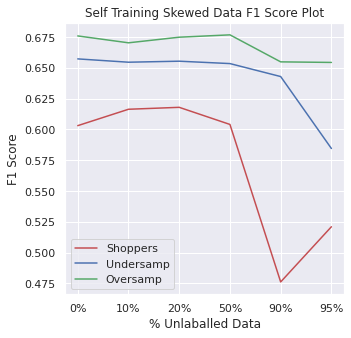

In [ ]:
plt.title('Self Training Skewed Data F1 Score Plot')
# plt.legend(l)
plt.plot(['0%', '10%', '20%', '50%', '90%', '95%'], ssl[:6], 'r', label='Shoppers')  
plt.plot(['0%', '10%', '20%', '50%', '90%', '95%'], ssl[6:12], 'b', label='Undersamp') 
plt.plot(['0%', '10%', '20%', '50%', '90%', '95%'], ssl[12:18], 'g', label='Oversamp')
plt.xlabel('% Unlaballed Data')
plt.ylabel('F1 Score')
plt.legend(loc="lower left")
plt.show()

## F1 Score Plot for Self Training Algorithm 

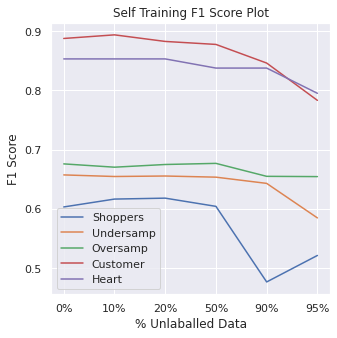

In [ ]:
plt.title('Self Training F1 Score Plot')
# plt.legend(l)
x = ['0%', '10%', '20%', '50%', '90%', '95%']
plt.plot(x, ssl[:6], label='Shoppers')  
plt.plot(x, ssl[6:12], label='Undersamp') 
plt.plot(x, ssl[12:18], label='Oversamp')
plt.plot(x, ssl[18:24], label='Customer')
plt.plot(x, ssl[24:30], label='Heart')
plt.xlabel('% Unlaballed Data')
plt.ylabel('F1 Score')
plt.legend(loc="lower left")
plt.show()

### F1 Score for Balanced and Imbalanced Shoppers Data for Semi Supervised Ensemble Learning

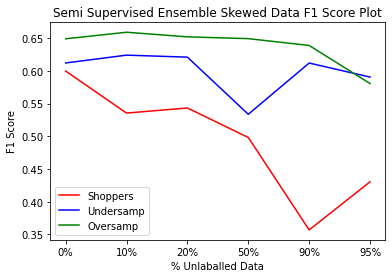

In [24]:
plt.title('Semi Supervised Ensemble Skewed Data F1 Score Plot')
# plt.legend(l)
plt.plot(['0%', '10%', '20%', '50%', '90%', '95%'], semi_ensem[:6], 'r', label='Shoppers')  
plt.plot(['0%', '10%', '20%', '50%', '90%', '95%'], semi_ensem[6:12], 'b', label='Undersamp') 
plt.plot(['0%', '10%', '20%', '50%', '90%', '95%'], semi_ensem[12:18], 'g', label='Oversamp')
plt.xlabel('% Unlaballed Data')
plt.ylabel('F1 Score')
plt.legend(loc="lower left")
plt.show()

## F1 Score Plot for Semi Supervised Ensemble Algorithm 

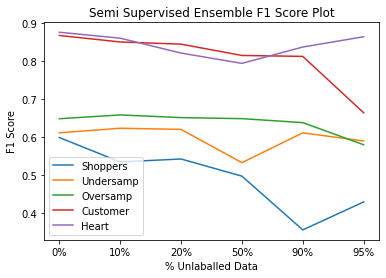

In [20]:
plt.title('Semi Supervised Ensemble F1 Score Plot')
# plt.legend(l)
x = ['0%', '10%', '20%', '50%', '90%', '95%']
plt.plot(x, semi_ensem[:6], label='Shoppers')  
plt.plot(x, semi_ensem[6:12], label='Undersamp') 
plt.plot(x, semi_ensem[12:18], label='Oversamp')
plt.plot(x, semi_ensem[18:24], label='Customer')
plt.plot(x, semi_ensem[24:30], label='Heart')
plt.xlabel('% Unlaballed Data')
plt.ylabel('F1 Score')
plt.legend(loc="lower left")
plt.show()

## F1 Score for Balanced and Imbalanced Shoppers Data for Unsupervised Pretraining

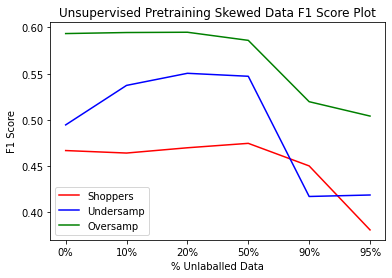

In [33]:
plt.title('Unsupervised Pretraining Skewed Data F1 Score Plot')
x = ['0%', '10%', '20%', '50%', '90%', '95%']
plt.plot(x, unsup_pre[:6], 'r', label='Shoppers')  
plt.plot(x, unsup_pre[6:12], 'b', label='Undersamp') 
plt.plot(x, unsup_pre[12:18], 'g', label='Oversamp')
plt.xlabel('% Unlaballed Data')
plt.ylabel('F1 Score')
plt.legend(loc="lower left")
plt.show()

## F1 Score Plot for Unsupervised Pretraining Algorithm 

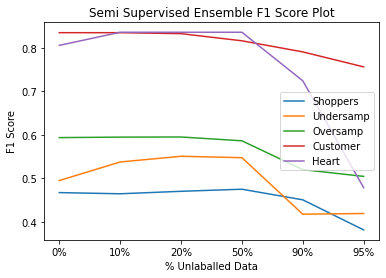

In [38]:
plt.title('Semi Supervised Ensemble F1 Score Plot')
# plt.legend(l)
x = ['0%', '10%', '20%', '50%', '90%', '95%']
plt.plot(x, unsup_pre[:6], label='Shoppers')  
plt.plot(x, unsup_pre[6:12], label='Undersamp') 
plt.plot(x, unsup_pre[12:18], label='Oversamp')
plt.plot(x, unsup_pre[18:24], label='Customer')
plt.plot(x, unsup_pre[24:30], label='Heart')
plt.xlabel('% Unlaballed Data')
plt.ylabel('F1 Score')
plt.legend(loc="best")
plt.show()

[]

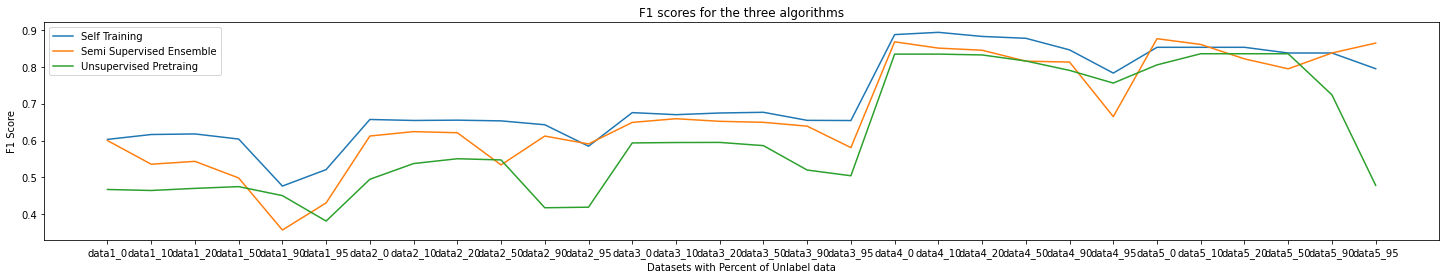

In [25]:
plt.figure(figsize=(25, 4))
plt.title('F1 scores for the three algorithms')
plt.plot(names, ssl, label='Self Training')
plt.plot(names, semi_ensem, label='Semi Supervised Ensemble')
plt.plot(names, unsup_pre, label='Unsupervised Pretraing')
plt.xlabel('Datasets with Percent of Unlabel data')
plt.ylabel('F1 Score')
plt.legend(loc='best')
plt.plot()

In [ ]:
results1 = pd.DataFrame({'Data': names, 'Self_train' : ssl, 'SemiSuper-Ensemble' : semi_ensem, 'Unsup_pretrain' : unsup_pre})
results1

Data  Self_train  SemiSuper-Ensemble  Unsup_pretrain
0    data1_0    0.603015            0.599826        0.466899
1   data1_10    0.616314            0.535565        0.464203
2   data1_20    0.617886            0.543340        0.469907
3   data1_50    0.604000            0.498229        0.474691
4   data1_90    0.476190            0.356771        0.450273
5   data1_95    0.520976            0.430380        0.381060
6    data2_0    0.657183            0.612219        0.494648
7   data2_10    0.654494            0.624179        0.537371
8   data2_20    0.655319            0.621142        0.550459
9   data2_50    0.653381            0.533702        0.547244
10  data2_90    0.642857            0.612109        0.417225
11  data2_95    0.584481            0.590654        0.418826
12   data3_0    0.675820            0.649207        0.593438
13  data3_10    0.670237            0.659233        0.594556
14  data3_20    0.674791            0.652174        0.594864
15  data3_50    0.676692            0.649441        0.586086
16  data3_90    0.654779            0.639004        0.519745
17  data3_95    0.654312            0.580760        0.504202
18   data4_0    0.887892            0.868251        0.834821
19  data4_10    0.894009            0.851153        0.834821
20  data4_20    0.882883            0.845361        0.832599
21  data4_50    0.877828            0.815668        0.816143
22  data4_90    0.846325            0.813187        0.790598
23  data4_95    0.783251            0.664921        0.756152
24   data5_0    0.853333            0.876712        0.805556
25  data5_10    0.853333            0.861111        0.835821
26  data5_20    0.853333            0.821918        0.835821
27  data5_50    0.837838            0.794872        0.835821
28  data5_90    0.837838            0.837838        0.724138
29  data5_95    0.795181            0.864865        0.478261

data1 = Shoppers Data<br>
data2 = Undersampled Shoppers Data<br>
data3 = Oversampled Data<br>
data4 = Customer Data<br>
data5 = Heart Data

In [5]:
results = pd.DataFrame({'Self_train' : ssl, 'SemiSuper-Ensemble' : semi_ensem, 'Unsup_pretrain' : unsup_pre})

In [6]:
results

Self_train  SemiSuper-Ensemble  Unsup_pretrain
0     0.603015            0.599826        0.466899
1     0.616314            0.535565        0.464203
2     0.617886            0.543340        0.469907
3     0.604000            0.498229        0.474691
4     0.476190            0.356771        0.450273
5     0.520976            0.430380        0.381060
6     0.657183            0.612219        0.494648
7     0.654494            0.624179        0.537371
8     0.655319            0.621142        0.550459
9     0.653381            0.533702        0.547244
10    0.642857            0.612109        0.417225
11    0.584481            0.590654        0.418826
12    0.675820            0.649207        0.593438
13    0.670237            0.659233        0.594556
14    0.674791            0.652174        0.594864
15    0.676692            0.649441        0.586086
16    0.654779            0.639004        0.519745
17    0.654312            0.580760        0.504202
18    0.887892            0.868251        0.834821
19    0.894009            0.851153        0.834821
20    0.882883            0.845361        0.832599
21    0.877828            0.815668        0.816143
22    0.846325            0.813187        0.790598
23    0.783251            0.664921        0.756152
24    0.853333            0.876712        0.805556
25    0.853333            0.861111        0.835821
26    0.853333            0.821918        0.835821
27    0.837838            0.794872        0.835821
28    0.837838            0.837838        0.724138
29    0.795181            0.864865        0.478261

In [ ]:
friedmanchisquare(*[row for index, row in results.iterrows()])

FriedmanchisquareResult(statistic=80.48764378478666, pvalue=9.8269099311638e-07)

### Friedman Chi Square Table


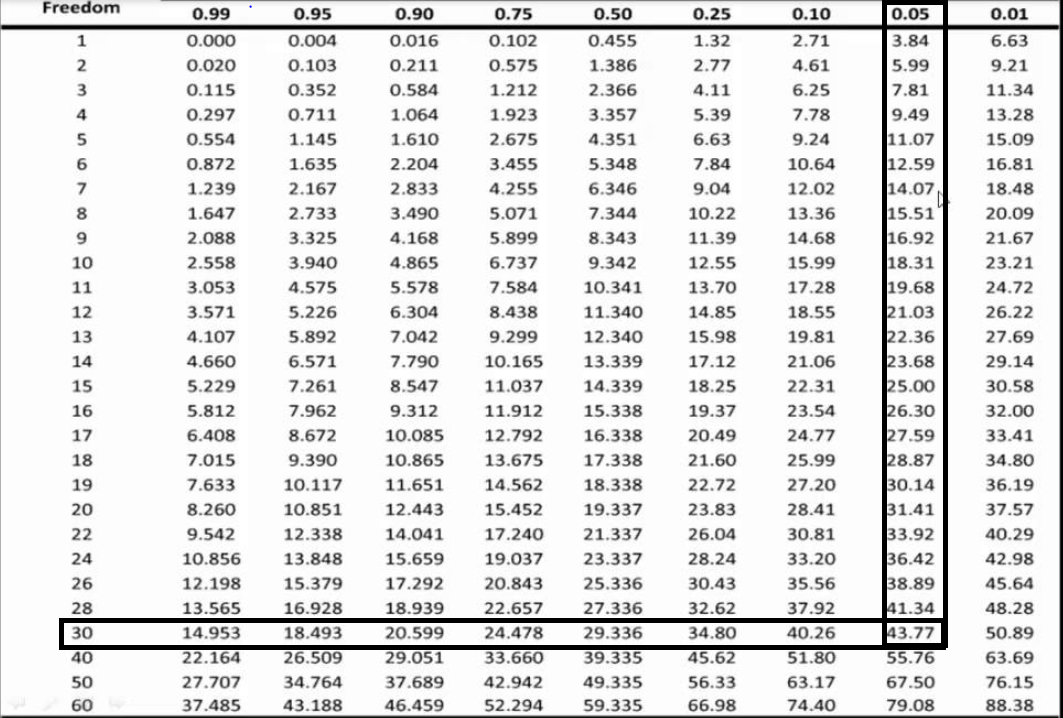

### Nemenyi Post Hoc Test 

1.   List item
2.   List item



In [7]:
all_ranks = results.rank(axis=1,ascending=False)
mod_avg_rank = all_ranks.mean(axis=0)

In [8]:
mod_avg_rank

Self_train            1.15
SemiSuper-Ensemble    2.05
Unsup_pretrain        2.80
dtype: float64

cd= 0.6051409960993112


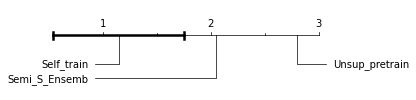

In [13]:
names = ["Self_train", "Semi_S_Ensemb", "Unsup_pretrain"]

cd = Orange.evaluation.compute_CD(mod_avg_rank, 30, test="nemenyi") 
#tested on 14 datasets 
print("cd=",cd)
Orange.evaluation.graph_ranks(mod_avg_rank, names, cd=cd, cdmethod=0, width=5, textspace=1.0)
plt.show();

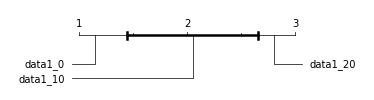

In [26]:
Orange.evaluation.graph_ranks(mod_avg_rank, names, cd=cd, cdmethod=1, width=5, textspace=1.0)
plt.show();